In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Konfigurasi agar GPU digunakan secara efisien
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU Terdeteksi: ", physical_devices[0])
else:
    print("Peringatan: GPU tidak terdeteksi. Training akan lambat.")

GPU Terdeteksi:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
# IMPORTANT: Make sure you have uploaded kaggle.json to your Colab session's /content/ directory first.
# If you uploaded it somewhere else, adjust the source path accordingly.
!mv /content/kaggle.json ~/.kaggle/

# Set read-only permissions for the kaggle.json file for security
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API credentials set up successfully!")

mv: cannot stat '/content/kaggle.json': No such file or directory
Kaggle API credentials set up successfully!


In [ ]:
# Install kaggle if not already installed
!pip install -q kaggle

# Make sure your Kaggle API credentials (kaggle.json) are set up in ~/.kaggle/
# If you haven't done this, please refer to the previous instructions.

# Download the dataset
!kaggle datasets download -d joosthazelzet/lego-brick-images

# Unzip the downloaded dataset to the specified directory
# The zip file will be downloaded to the current working directory (/content/)
!unzip -q /content/lego-brick-images.zip -d /content/dataset/

# Clean up the zip file after extraction
!rm /content/lego-brick-images.zip

print("Dataset downloaded and extracted to /content/dataset/")

Dataset URL: https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images
License(s): GPL-2.0
 96% 981M/1.00G [00:03<00:00, 206MB/s]
100% 1.00G/1.00G [00:03<00:00, 312MB/s]
replace /content/dataset/Collada models/14719 flat tile corner 2x2.dae? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/dataset/Collada models/15672 roof tile 1x2.dae? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/dataset/Collada models/18654 beam 1M.dae? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/dataset/Collada models/2357 brick corner 1x2x2.dae? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/dataset/Collada models/2420 plate corner 2x2.dae? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/dataset/Collada models/2780 Peg with friction.dae? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/dataset/Collada models/27925 flat tile round 2x2.dae? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/dataset/Collada models/3001 brick 2x4.dae? [y]es, [n]o, 

In [ ]:
# Parameter Konfigurasi
BATCH_SIZE = 64
IMG_HEIGHT = 64  # Menggunakan 64x64 agar detail LEGO cukup terlihat
IMG_WIDTH = 64
CHANNELS = 3     # RGB


# --- OPSI B: Membuat Dataset Loader ---
# Ganti 'path/to/images' dengan path folder dataset Anda
dataset_dir = '/content/dataset/LEGO brick images v1'

# Jika folder kosong/tidak ada, kita buat dummy data agar kode tetap jalan (untuk testing)
if not os.path.exists(dataset_dir) or not os.listdir(dataset_dir):
    print("Dataset tidak ditemukan. Membuat data dummy untuk demonstrasi struktur kode.")
    os.makedirs(dataset_dir, exist_ok=True)
    # Membuat 100 gambar random noise sebagai placeholder
    for i in range(100):
        img = np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8)
        tf.keras.utils.save_img(f"{dataset_dir}/dummy_{i}.png", img)

# Memuat dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    label_mode=None, # Kita tidak butuh label untuk GAN
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Normalisasi ke [-1, 1]
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

# Optimasi performa (Caching & Prefetching)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 6379 files.


In [ ]:
latent_dim = 128

def build_generator():
    model = keras.Sequential(name="generator")

    # Input: Latent Vector
    # Mulai dengan dense layer yang cukup besar untuk di-reshape
    # Kita ingin mulai dari ukuran 8x8 dengan 512 filter
    model.add(layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Reshape menjadi tensor 3D
    model.add(layers.Reshape((8, 8, 512)))

    # Upsampling 1: 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 2: 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 3: 32x32 -> 64x64
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Output Layer: 64x64 -> 64x64x3 (RGB)
    # Aktivasi TANH penting agar output di range [-1, 1]
    model.add(layers.Conv2D(CHANNELS, (3, 3), padding='same', activation='tanh'))

    return model

def build_discriminator():
    model = keras.Sequential(name="discriminator")

    # Input: Gambar 64x64x3
    # Downsampling 1: 64 -> 32
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 2: 32 -> 16
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 3: 16 -> 8
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Flatten dan Output
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Output berupa logit (skor real/fake)

    return model

# Inisialisasi Model
generator = build_generator()
discriminator = build_discriminator()

generator.summary()
# discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,081,411 (27.01 MB)

 Trainable params: 7,014,979 (26.76 MB)

 Non-trainable params: 66,432 (259.50 KB)

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        # Metric trackers
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # 1. Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2. Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # 3. Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 4. Assemble labels discriminating real from fake images
        # Label 1 untuk fake, 0 untuk real (atau sebaliknya, teknik ini menggunakan label smoothing)
        # Di sini kita pakai standar: 1=Real, 0=Fake.
        # Namun, karena kita concat [Fake, Real], maka labelnya: [0...0, 1...1]
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Tambahkan sedikit noise pada label (Label Smoothing) untuk stabilitas
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # 5. Train the Discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # 6. Sample random points in the latent space (lagi, untuk Generator)
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 7. Assemble labels that say "all real images" (We want to fool the discriminator)
        misleading_labels = tf.ones((batch_size, 1))

        # 8. Train the Generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 127.5
        generated_images += 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(10, 4))
        for i in range(self.num_img):
            plt.subplot(1, self.num_img, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')

        plt.suptitle(f"Epoch {epoch+1}")
        plt.show() # Tampilkan inline di Colab

        # Opsional: Simpan ke file
        # plt.savefig(f"generated_lego_epoch_{epoch}.png")
        # plt.close()

Mulai Training...
Epoch 1/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - d_loss: 0.6465 - g_loss: 0.8314

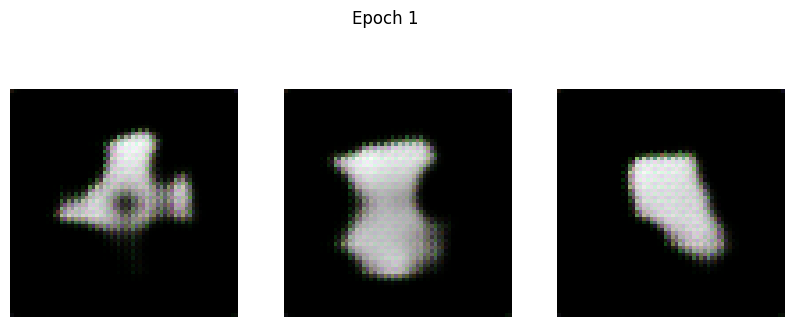

100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - d_loss: 0.6467 - g_loss: 0.8309
Epoch 2/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - d_loss: 0.6803 - g_loss: 0.6953

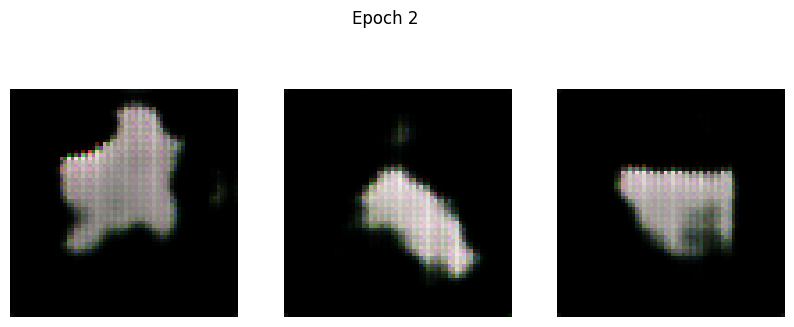

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - d_loss: 0.6803 - g_loss: 0.6953
Epoch 3/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - d_loss: 0.6654 - g_loss: 0.7146

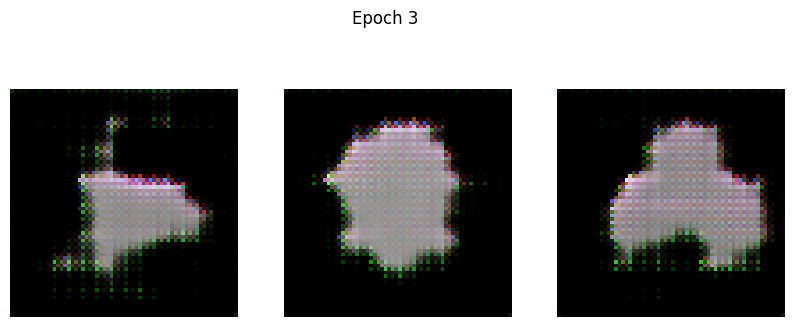

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - d_loss: 0.6654 - g_loss: 0.7146
Epoch 4/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - d_loss: 0.6723 - g_loss: 0.7261

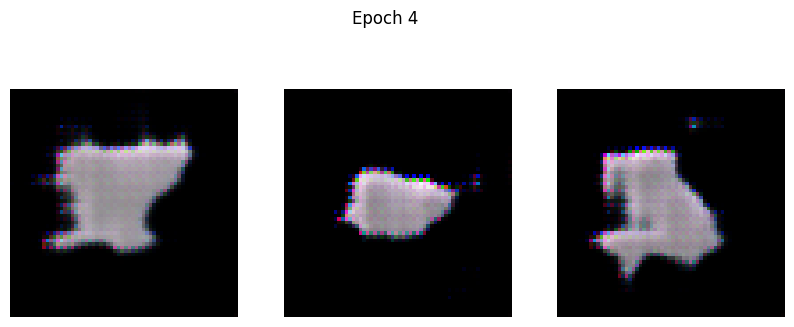

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - d_loss: 0.6724 - g_loss: 0.7260
Epoch 5/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - d_loss: 0.6791 - g_loss: 0.7183

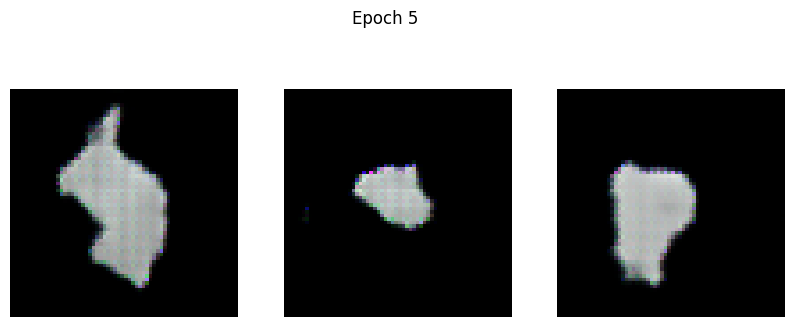

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - d_loss: 0.6790 - g_loss: 0.7183
Epoch 6/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - d_loss: 0.6670 - g_loss: 0.7193

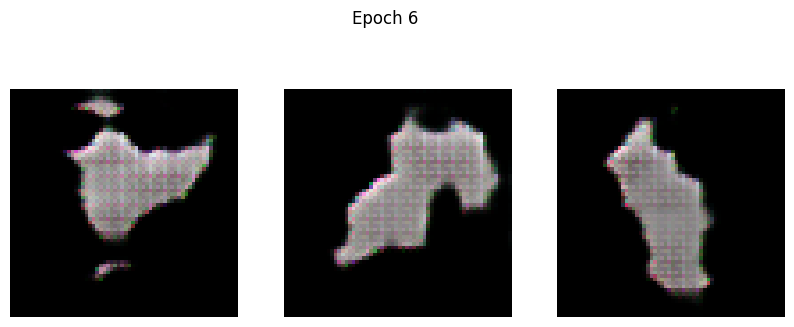

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - d_loss: 0.6670 - g_loss: 0.7194
Epoch 7/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - d_loss: 0.6695 - g_loss: 0.7368

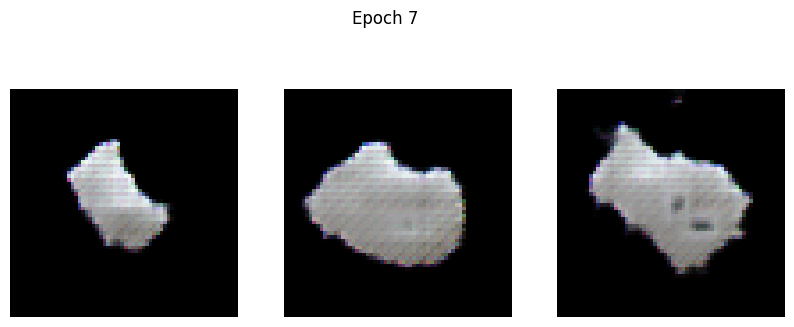

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - d_loss: 0.6695 - g_loss: 0.7367
Epoch 8/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - d_loss: 0.6794 - g_loss: 0.7026

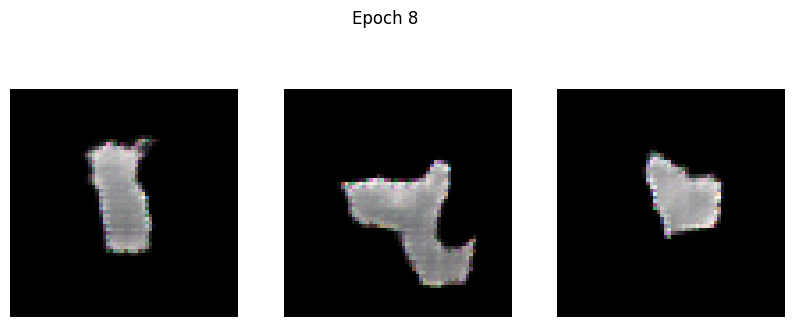

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - d_loss: 0.6793 - g_loss: 0.7025
Epoch 9/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - d_loss: 0.6688 - g_loss: 0.6994

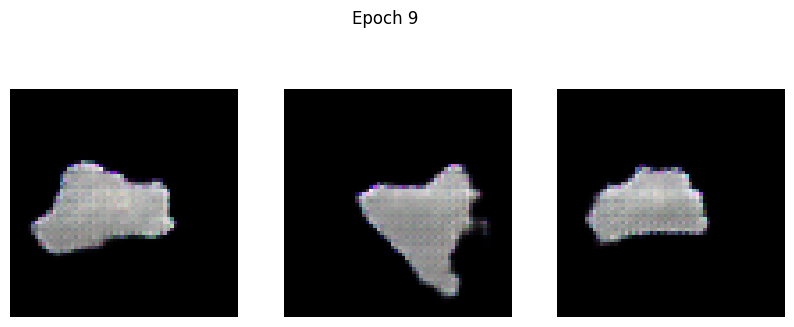

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - d_loss: 0.6688 - g_loss: 0.6995
Epoch 10/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - d_loss: 0.6704 - g_loss: 0.7063

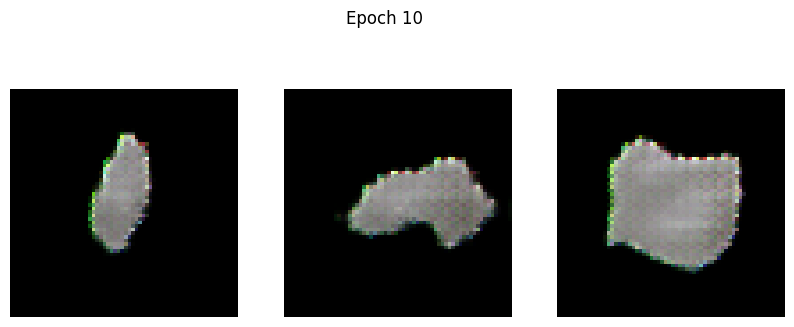

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - d_loss: 0.6704 - g_loss: 0.7064
Epoch 11/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_loss: 0.6588 - g_loss: 0.7289

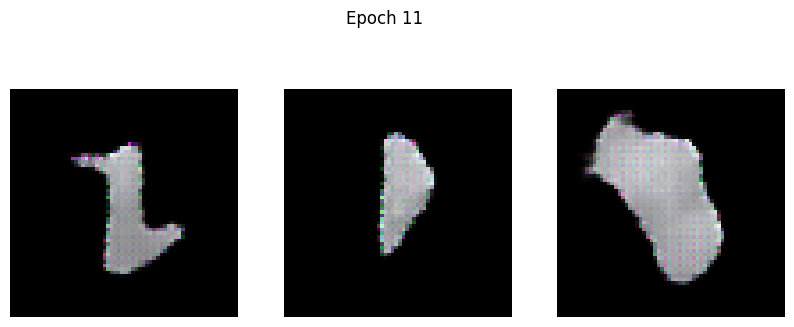

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - d_loss: 0.6588 - g_loss: 0.7289
Epoch 12/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_loss: 0.6556 - g_loss: 0.7571

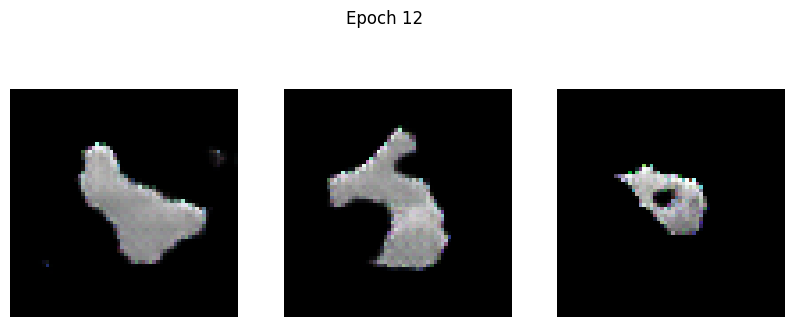

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - d_loss: 0.6556 - g_loss: 0.7571
Epoch 13/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.6496 - g_loss: 0.8101

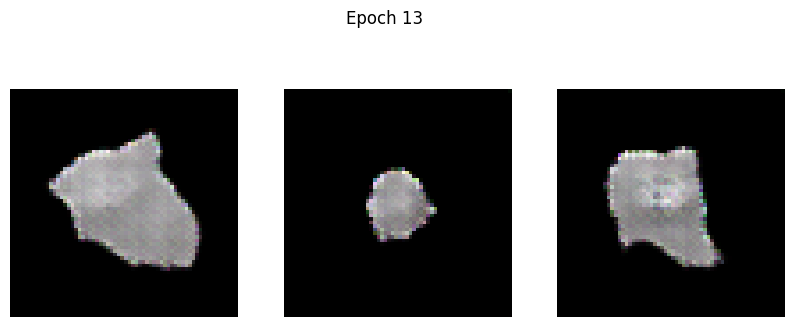

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - d_loss: 0.6496 - g_loss: 0.8099
Epoch 14/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.6475 - g_loss: 0.7991

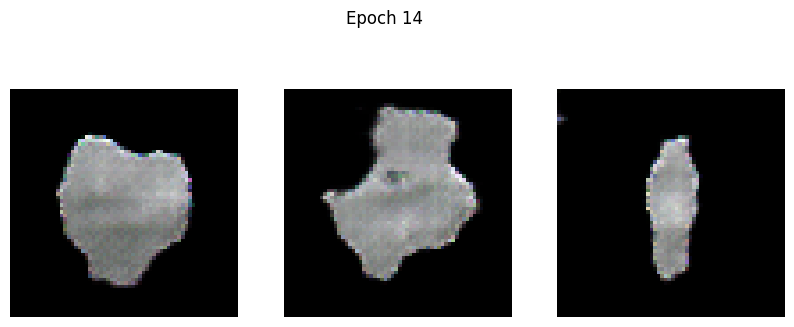

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.6475 - g_loss: 0.7990
Epoch 15/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.6305 - g_loss: 0.8129

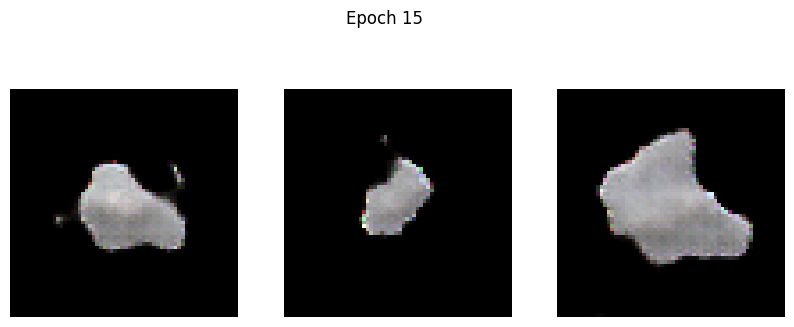

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.6304 - g_loss: 0.8130
Epoch 16/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.6148 - g_loss: 0.8144

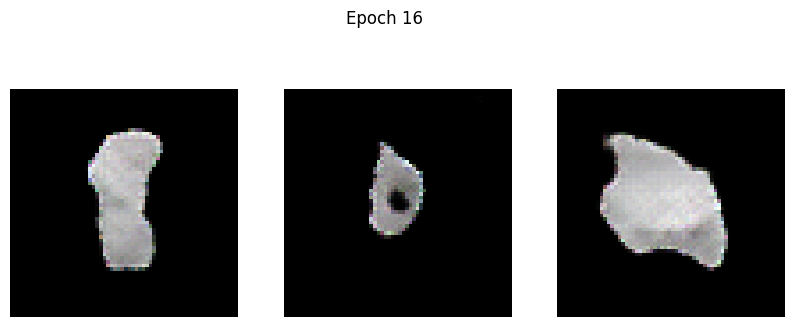

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.6147 - g_loss: 0.8146
Epoch 17/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.6063 - g_loss: 0.8581

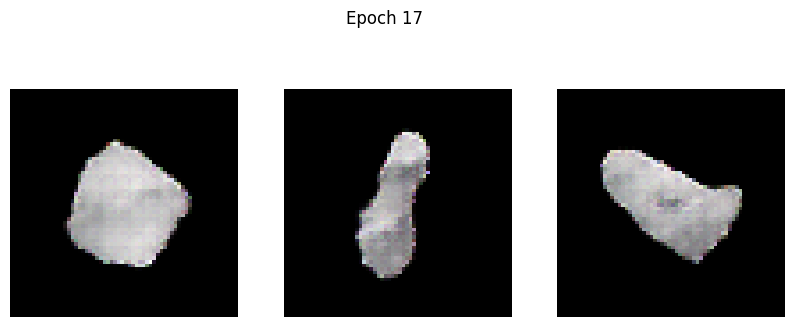

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.6062 - g_loss: 0.8581
Epoch 18/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.5917 - g_loss: 0.8976

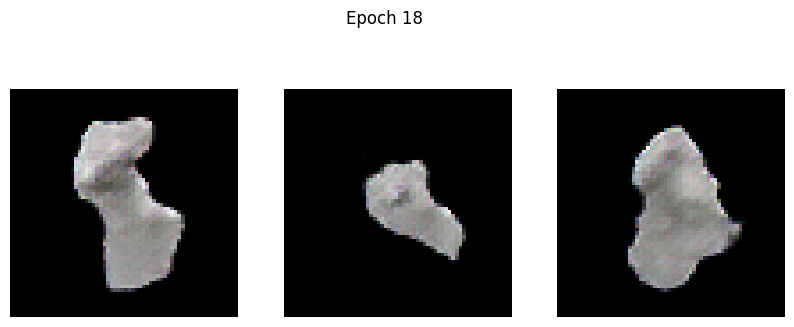

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.5917 - g_loss: 0.8977
Epoch 19/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.5889 - g_loss: 0.9447

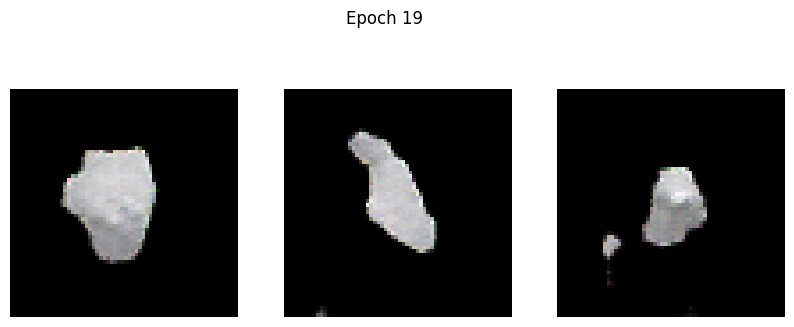

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.5889 - g_loss: 0.9447
Epoch 20/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5630 - g_loss: 0.9495

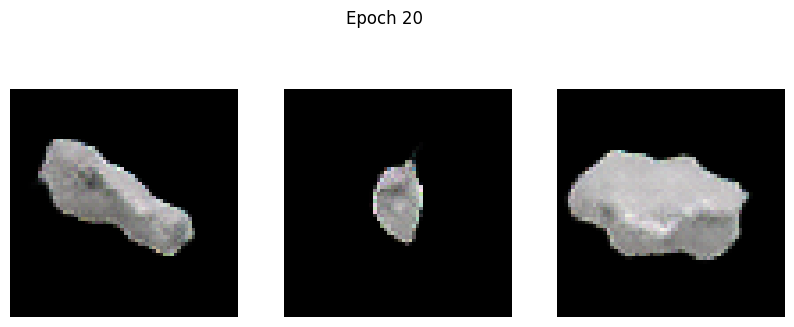

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.5630 - g_loss: 0.9496
Epoch 21/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5525 - g_loss: 0.9770

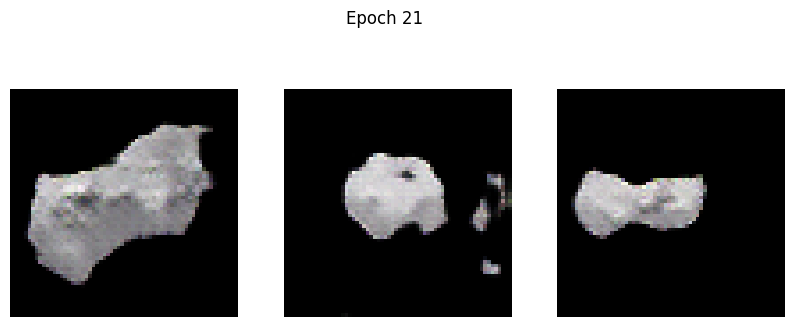

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.5525 - g_loss: 0.9771
Epoch 22/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5429 - g_loss: 1.0321

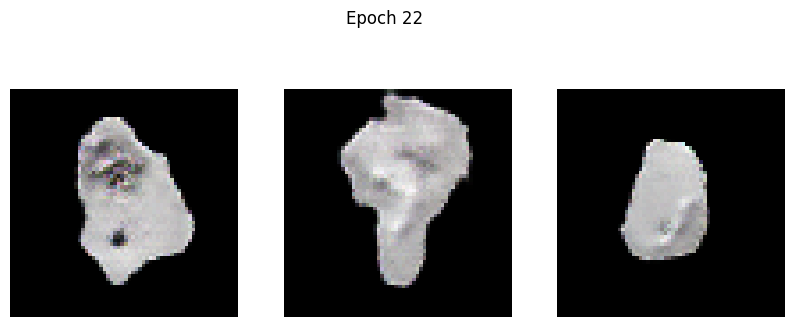

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.5429 - g_loss: 1.0321
Epoch 23/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5289 - g_loss: 1.0370

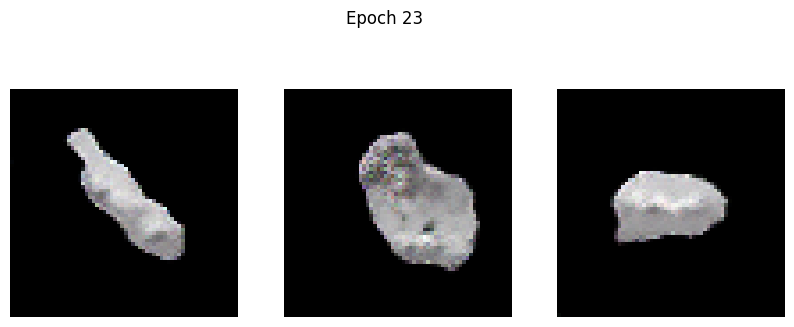

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.5288 - g_loss: 1.0372
Epoch 24/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5145 - g_loss: 1.1036

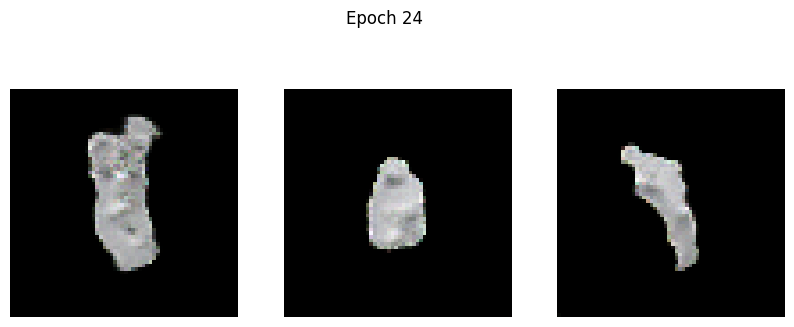

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.5145 - g_loss: 1.1037
Epoch 25/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.5103 - g_loss: 1.1586

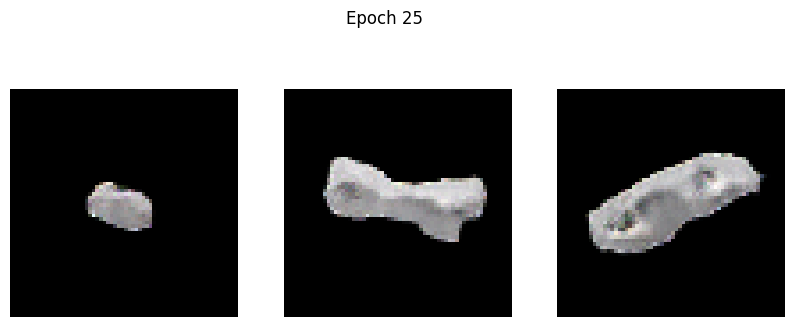

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.5103 - g_loss: 1.1584
Epoch 26/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4826 - g_loss: 1.1714

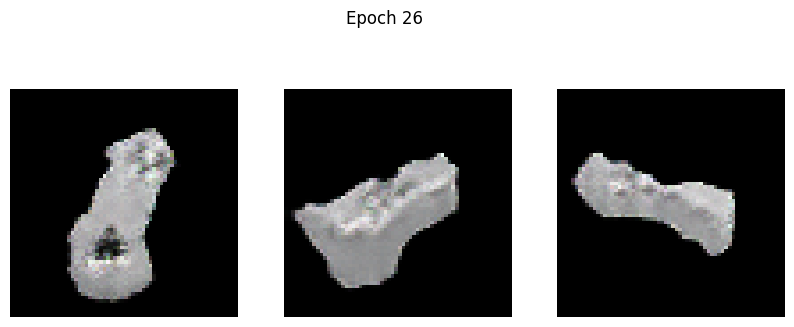

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4828 - g_loss: 1.1716
Epoch 27/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4825 - g_loss: 1.1514

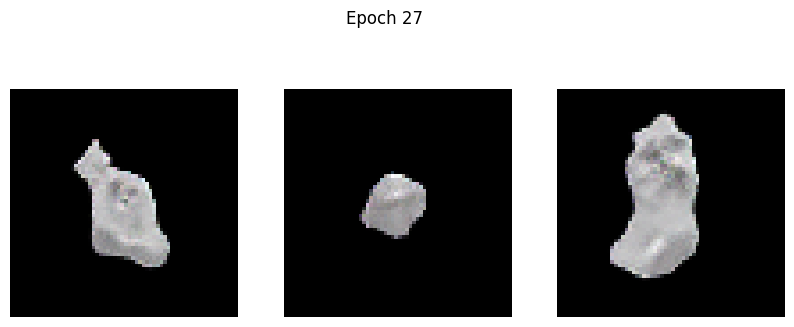

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4824 - g_loss: 1.1517
Epoch 28/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4577 - g_loss: 1.2401

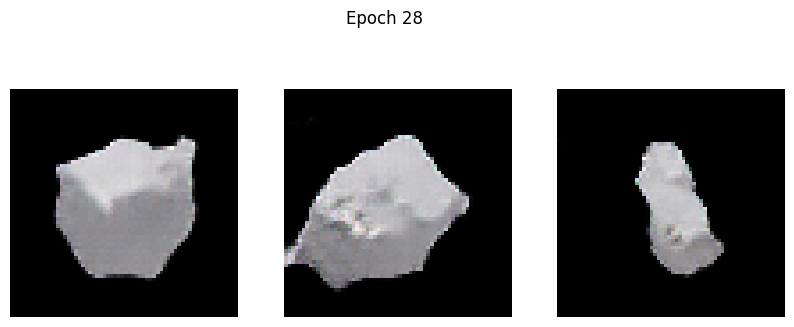

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4577 - g_loss: 1.2402
Epoch 29/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4668 - g_loss: 1.2666

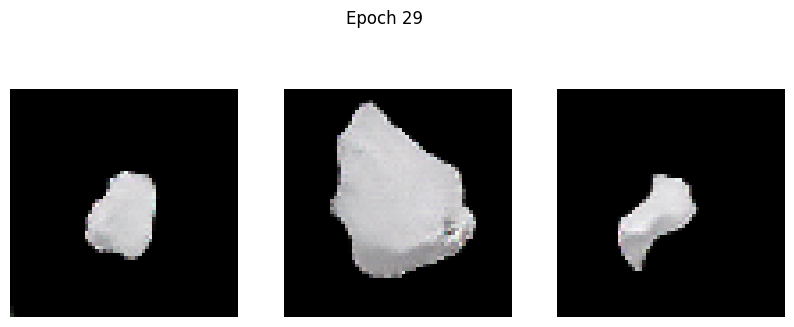

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4668 - g_loss: 1.2669
Epoch 30/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4319 - g_loss: 1.2921

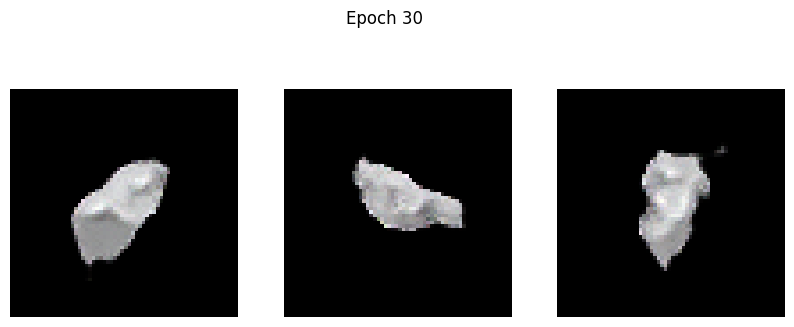

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4319 - g_loss: 1.2924
Epoch 31/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4493 - g_loss: 1.3454

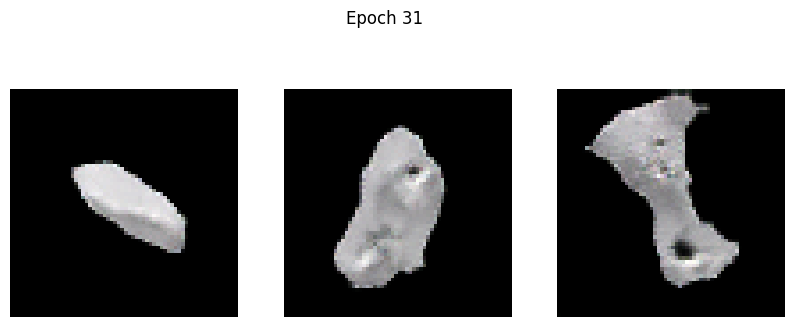

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4493 - g_loss: 1.3455
Epoch 32/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4283 - g_loss: 1.3650

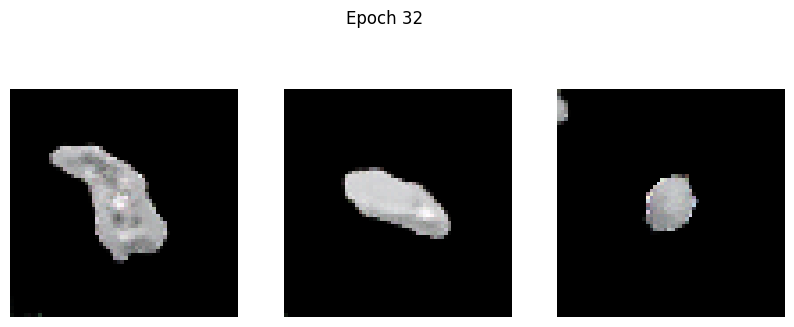

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4286 - g_loss: 1.3653
Epoch 33/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3993 - g_loss: 1.3597

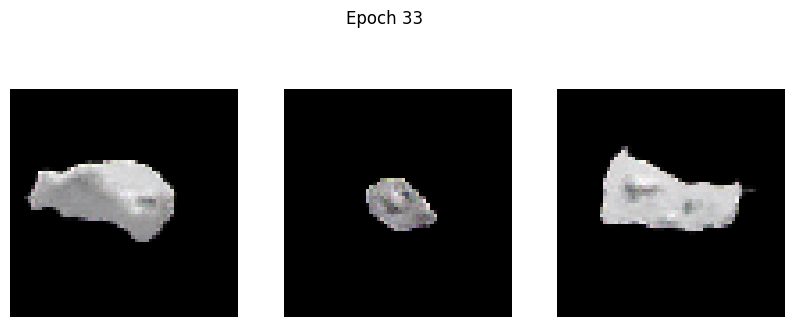

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3994 - g_loss: 1.3601
Epoch 34/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4091 - g_loss: 1.4473

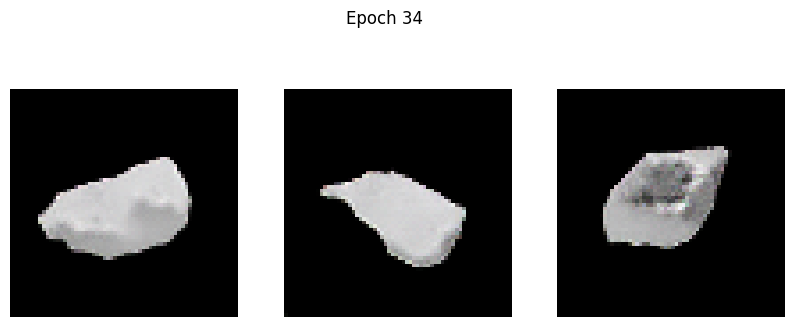

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4091 - g_loss: 1.4473
Epoch 35/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.4119 - g_loss: 1.5224

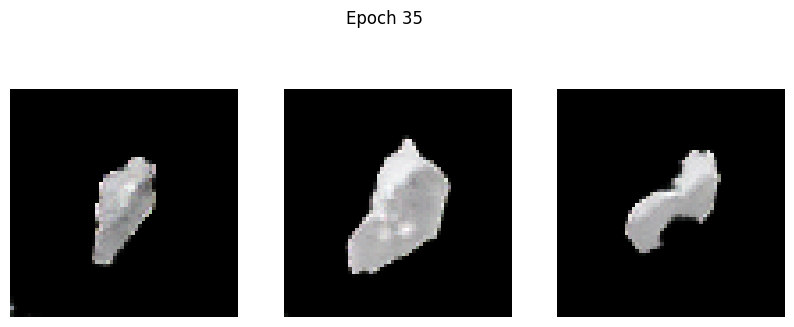

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.4119 - g_loss: 1.5222
Epoch 36/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3853 - g_loss: 1.5190

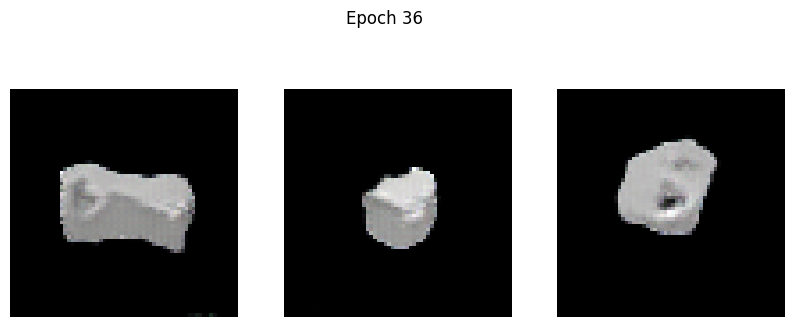

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3854 - g_loss: 1.5190
Epoch 37/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3739 - g_loss: 1.5813

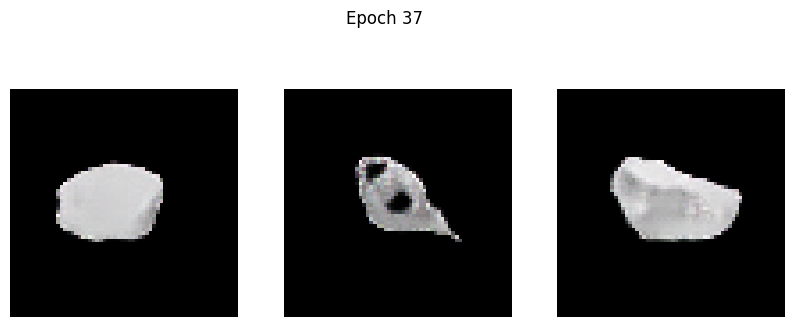

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3739 - g_loss: 1.5812
Epoch 38/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.4052 - g_loss: 1.5923

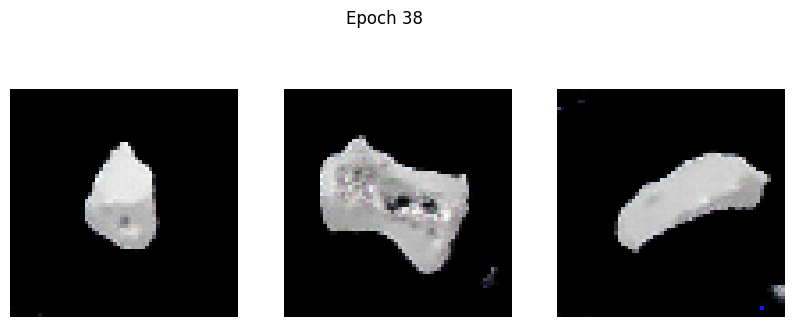

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.4052 - g_loss: 1.5924
Epoch 39/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3981 - g_loss: 1.5594

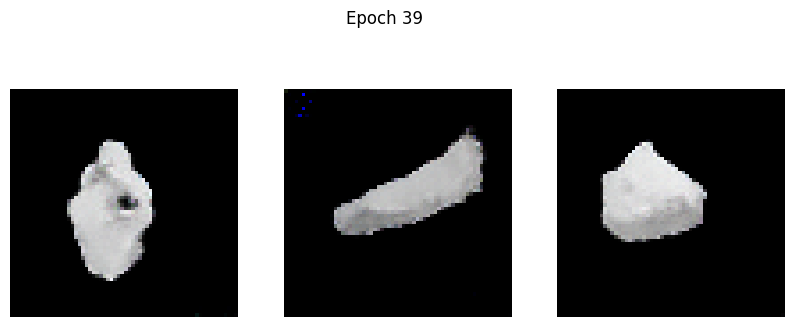

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3983 - g_loss: 1.5596
Epoch 40/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3650 - g_loss: 1.5538

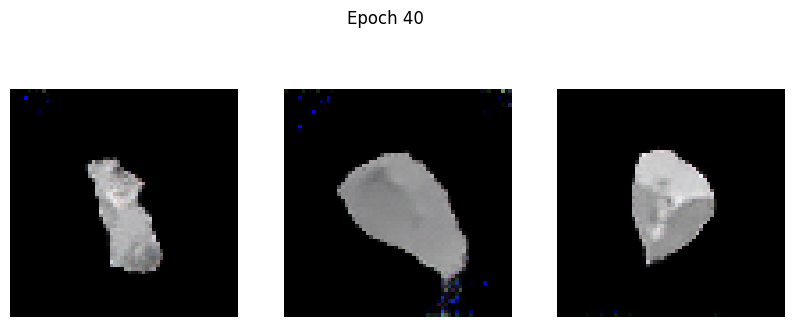

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - d_loss: 0.3650 - g_loss: 1.5540
Epoch 41/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3836 - g_loss: 1.5731

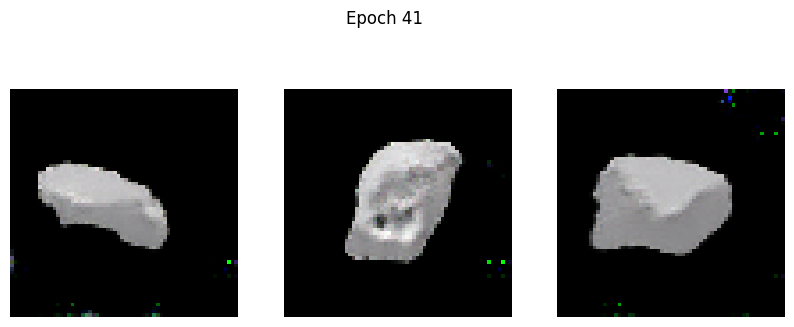

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3836 - g_loss: 1.5730
Epoch 42/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.3684 - g_loss: 1.5973

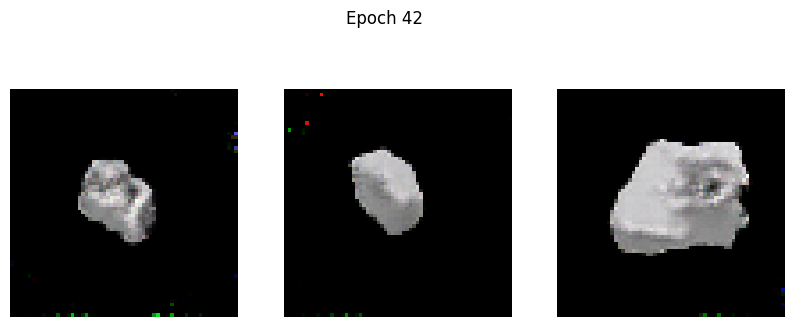

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3686 - g_loss: 1.5978
Epoch 43/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3577 - g_loss: 1.5798

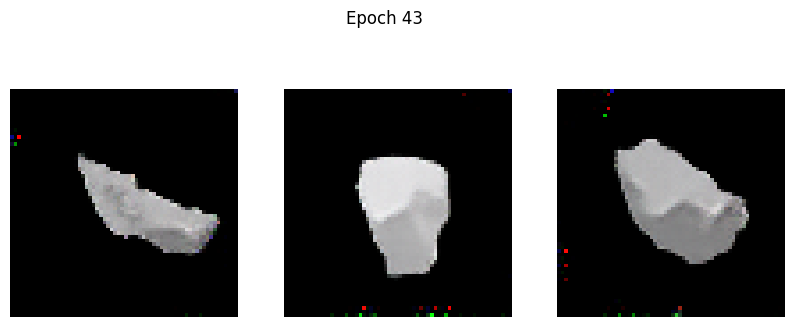

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3579 - g_loss: 1.5802
Epoch 44/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3770 - g_loss: 1.6523

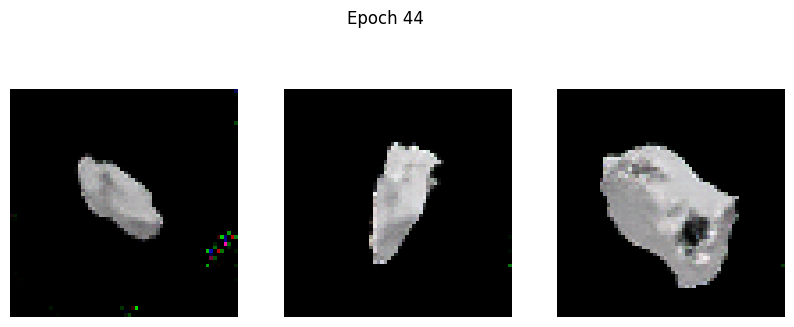

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3770 - g_loss: 1.6522
Epoch 45/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3861 - g_loss: 1.7138

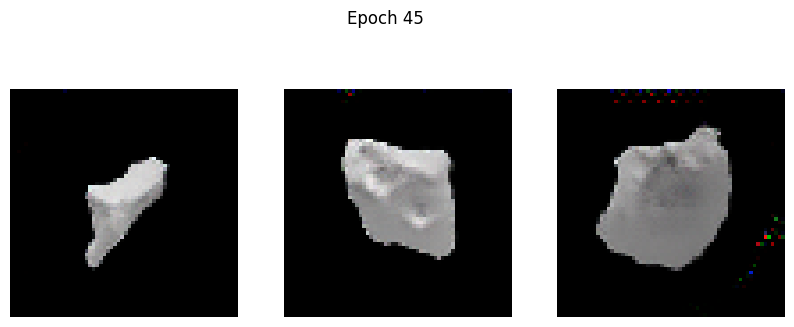

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3863 - g_loss: 1.7139
Epoch 46/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3346 - g_loss: 1.6289

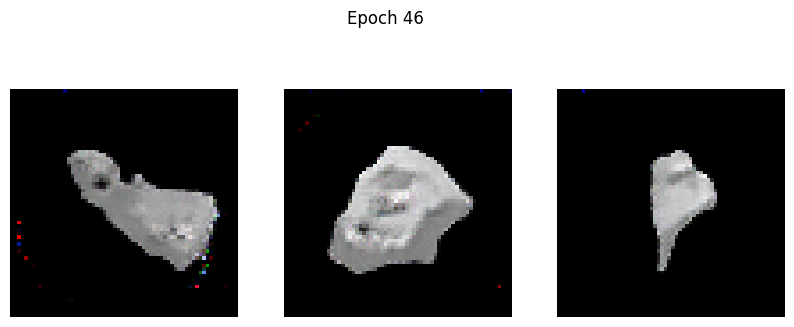

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3346 - g_loss: 1.6291
Epoch 47/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3355 - g_loss: 1.7384

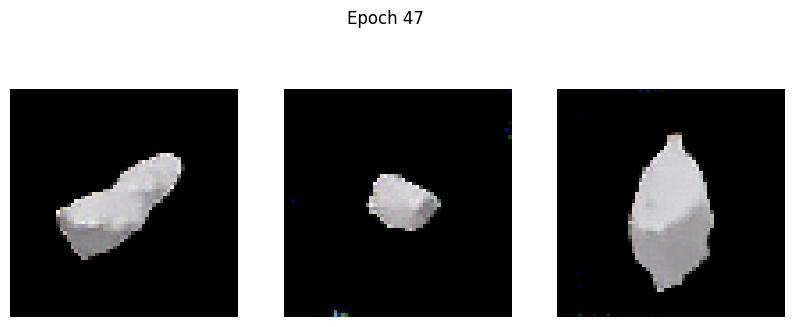

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3357 - g_loss: 1.7382
Epoch 48/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3437 - g_loss: 1.6860

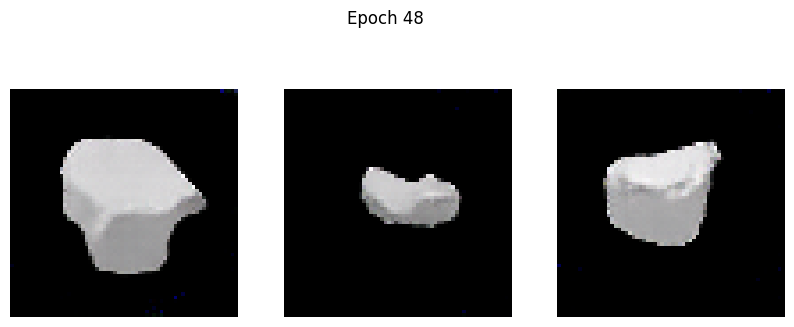

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.3437 - g_loss: 1.6861
Epoch 49/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3150 - g_loss: 1.7346

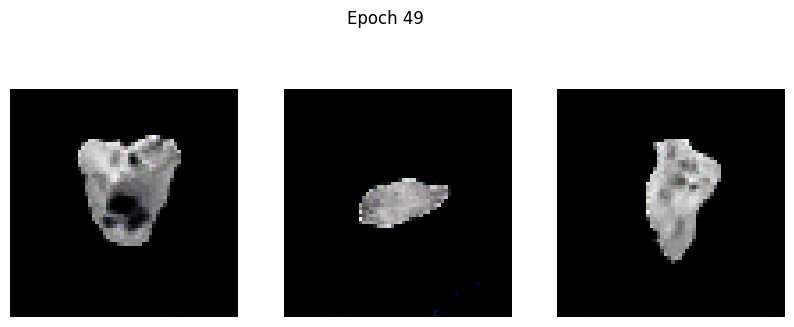

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3152 - g_loss: 1.7349
Epoch 50/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3429 - g_loss: 1.7981

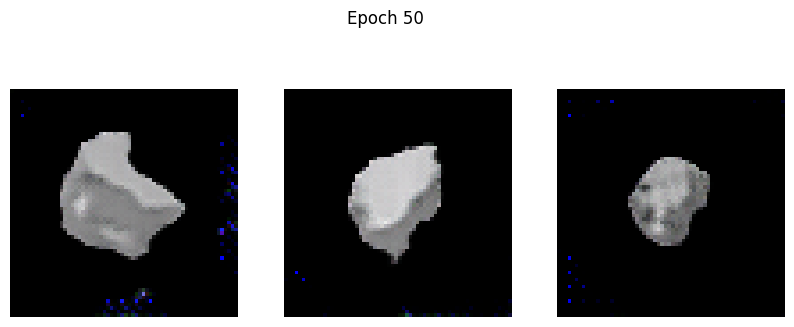

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3432 - g_loss: 1.7983
Epoch 51/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3389 - g_loss: 1.6631

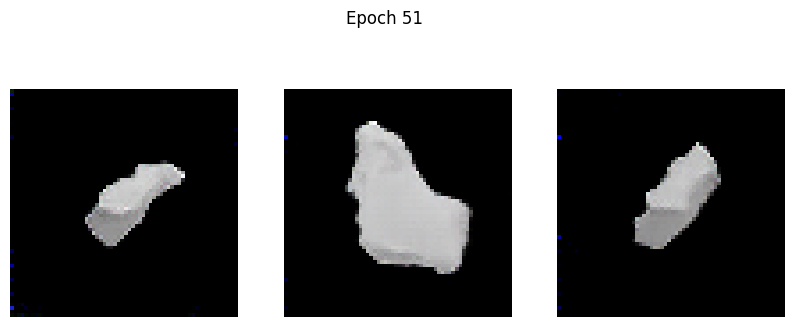

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3388 - g_loss: 1.6634
Epoch 52/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3251 - g_loss: 1.8175

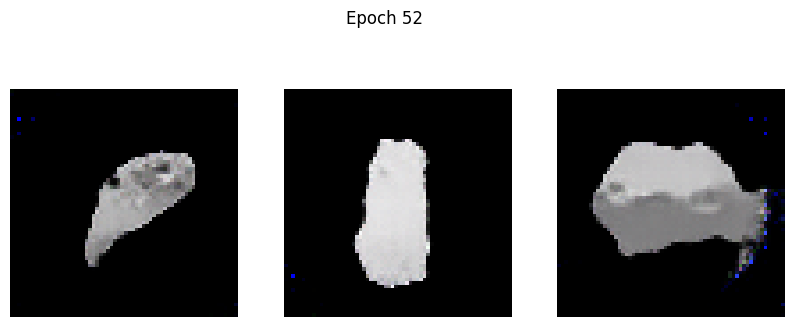

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3252 - g_loss: 1.8174
Epoch 53/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3543 - g_loss: 1.8753

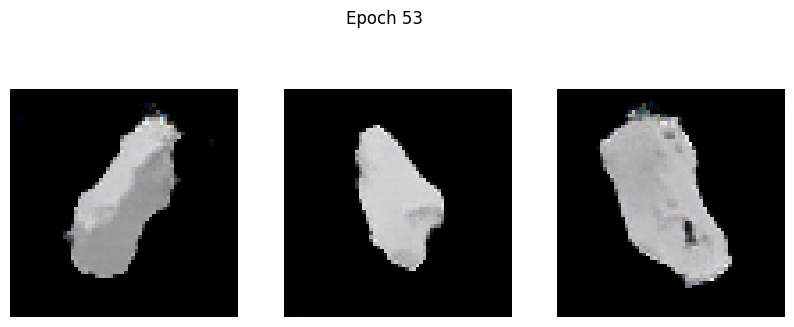

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3542 - g_loss: 1.8751
Epoch 54/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2955 - g_loss: 1.8188

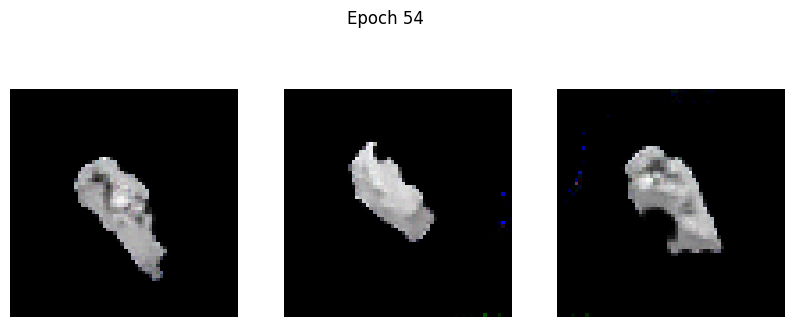

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2957 - g_loss: 1.8190
Epoch 55/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3118 - g_loss: 1.9020

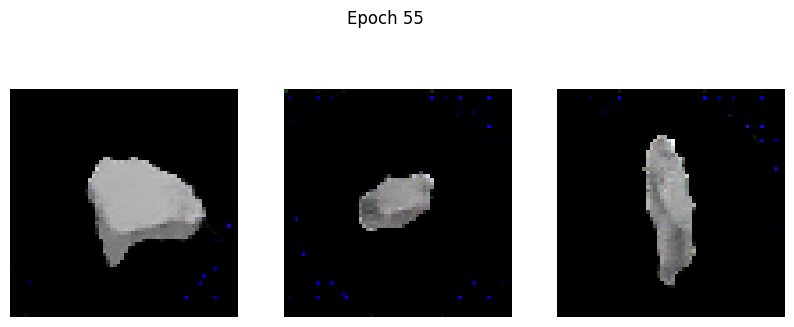

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3120 - g_loss: 1.9020
Epoch 56/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3141 - g_loss: 1.8742

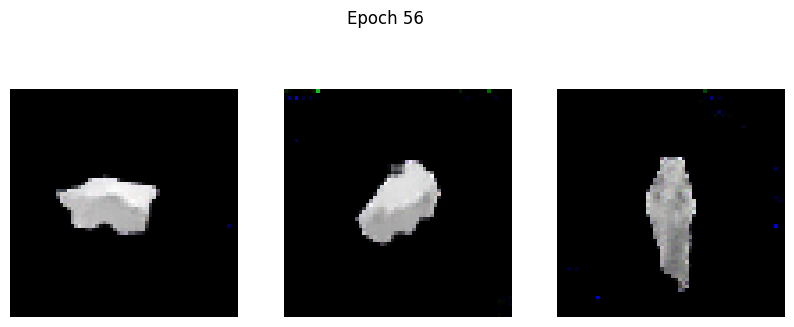

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3141 - g_loss: 1.8744
Epoch 57/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2997 - g_loss: 1.9393

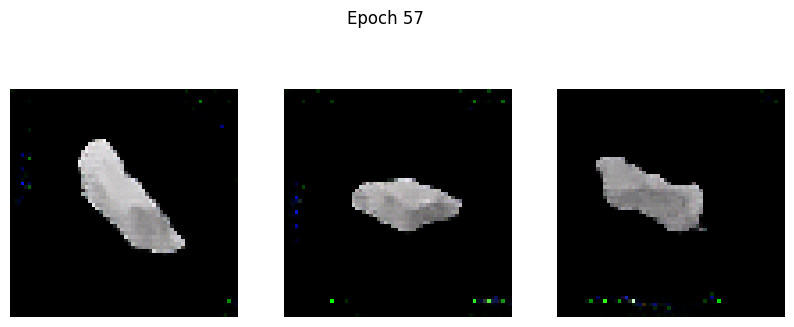

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3005 - g_loss: 1.9404
Epoch 58/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3856 - g_loss: 1.9420

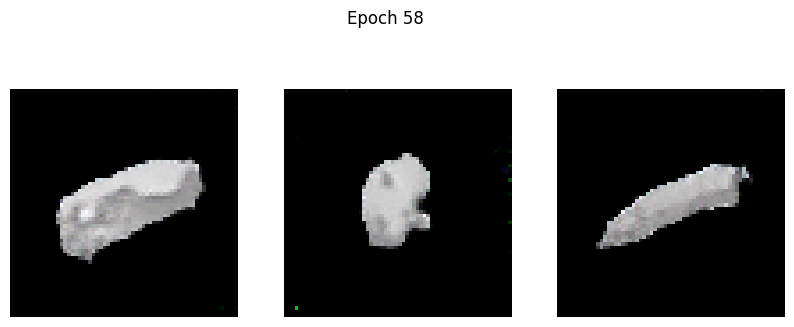

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3849 - g_loss: 1.9408
Epoch 59/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2767 - g_loss: 1.8565

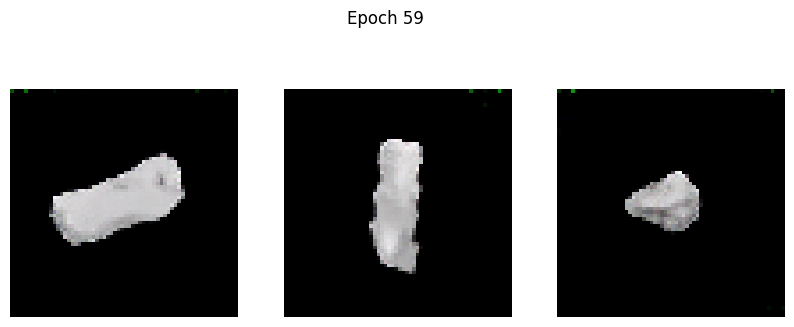

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2768 - g_loss: 1.8565
Epoch 60/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.4589 - g_loss: 2.0618

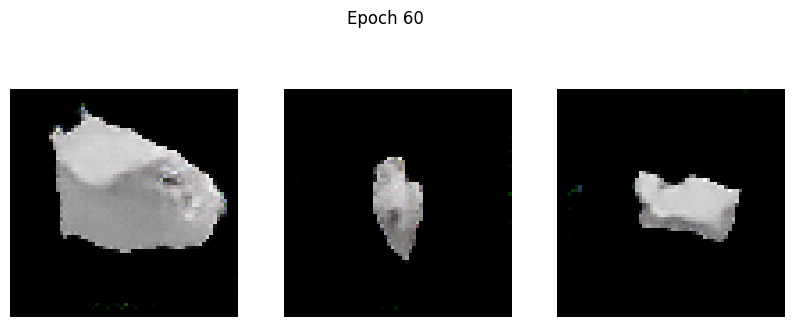

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.4594 - g_loss: 2.0620
Epoch 61/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2953 - g_loss: 1.7423

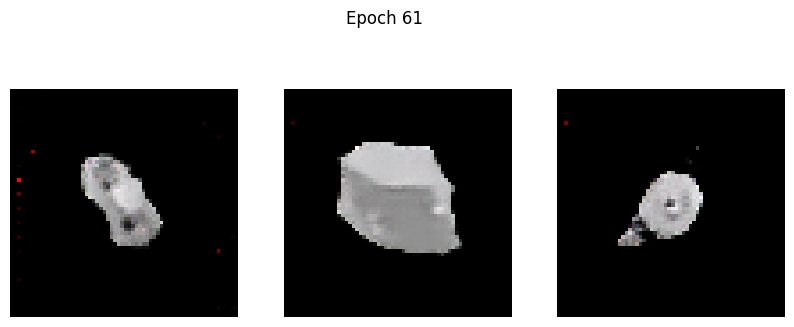

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2953 - g_loss: 1.7426
Epoch 62/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2850 - g_loss: 1.8517

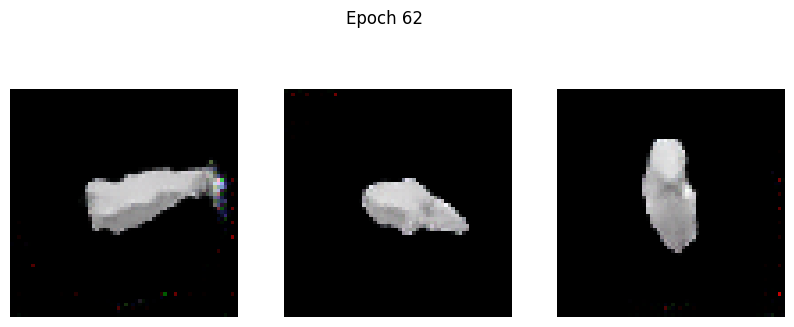

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2851 - g_loss: 1.8519
Epoch 63/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2735 - g_loss: 1.9002

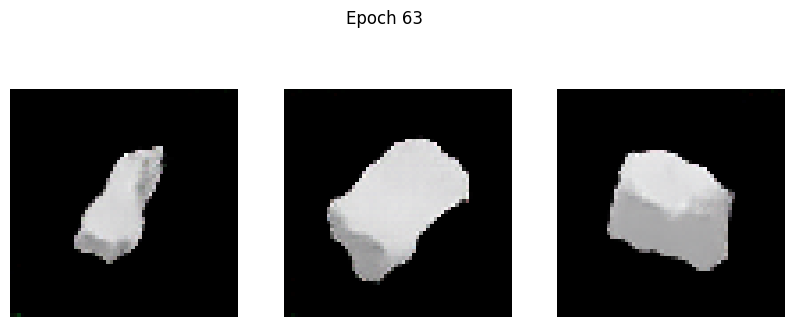

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2735 - g_loss: 1.9005
Epoch 64/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2970 - g_loss: 1.9633

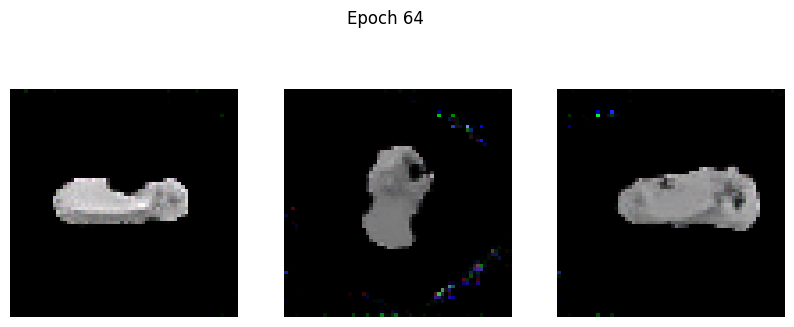

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2972 - g_loss: 1.9641
Epoch 65/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2818 - g_loss: 1.9803

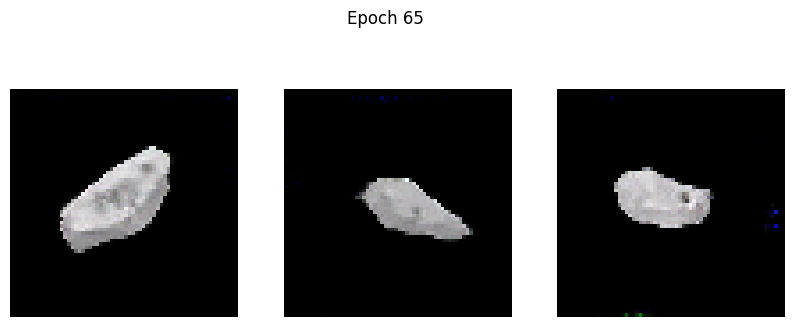

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2816 - g_loss: 1.9801
Epoch 66/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3458 - g_loss: 2.0769

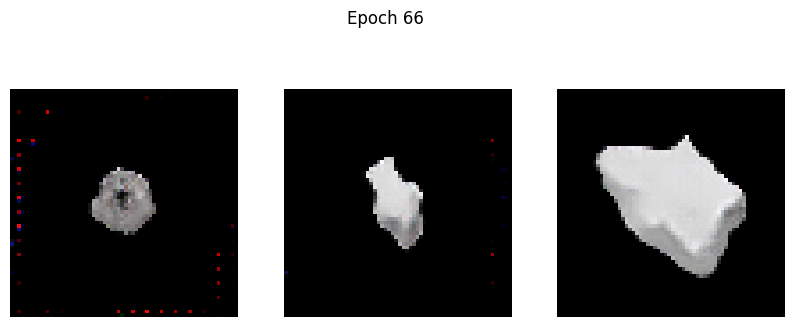

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3454 - g_loss: 2.0763
Epoch 67/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2726 - g_loss: 2.0455

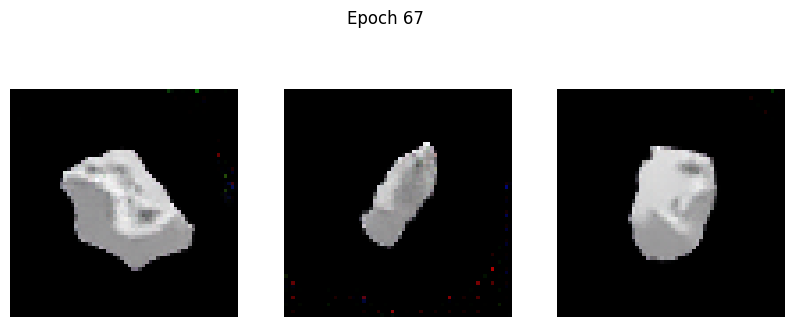

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2727 - g_loss: 2.0453
Epoch 68/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2765 - g_loss: 2.0253

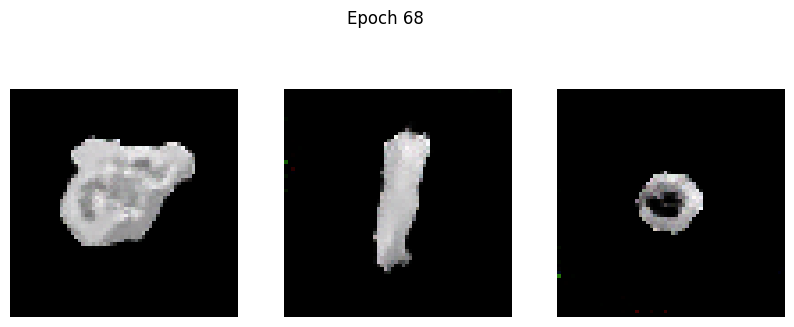

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2766 - g_loss: 2.0254
Epoch 69/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2869 - g_loss: 2.0560

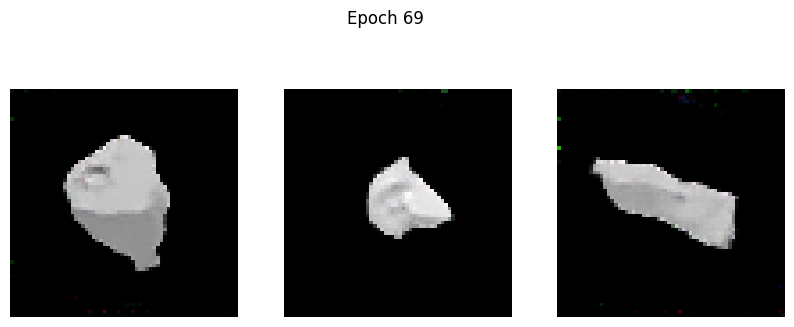

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2867 - g_loss: 2.0561
Epoch 70/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3134 - g_loss: 2.0739

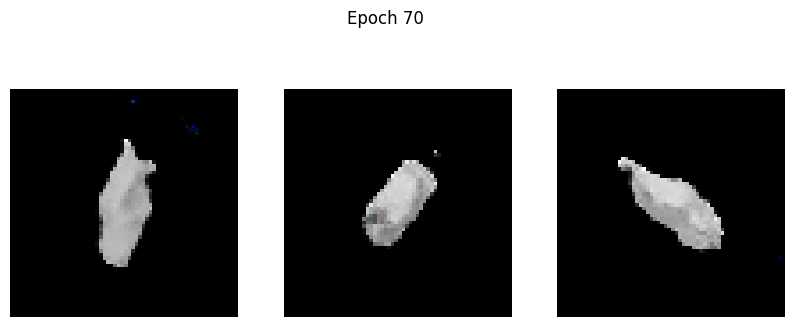

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3134 - g_loss: 2.0740
Epoch 71/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2808 - g_loss: 2.0598

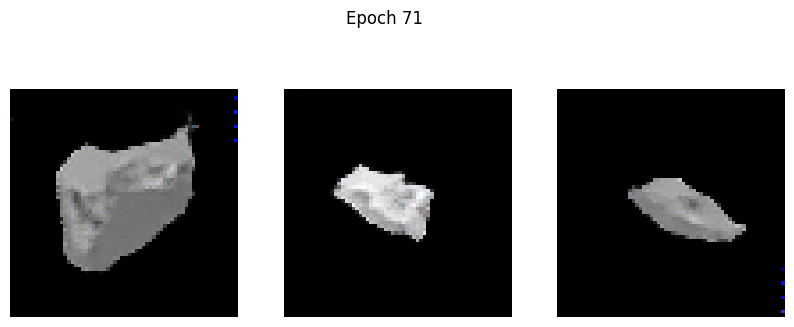

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2808 - g_loss: 2.0598
Epoch 72/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2732 - g_loss: 2.1288

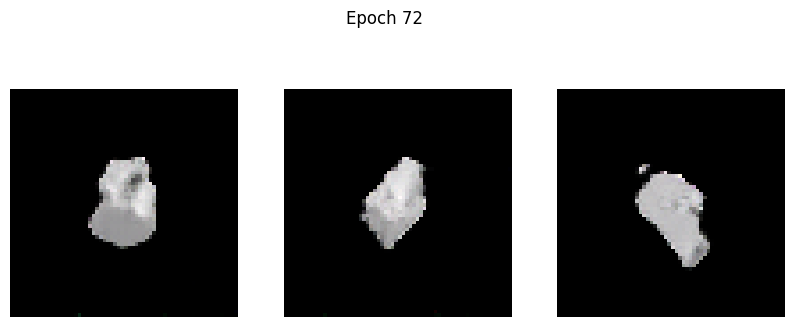

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2736 - g_loss: 2.1291
Epoch 73/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2884 - g_loss: 2.1277

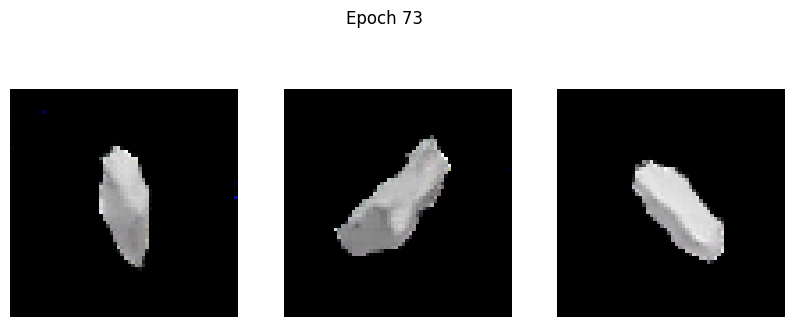

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2882 - g_loss: 2.1273
Epoch 74/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2857 - g_loss: 2.1206

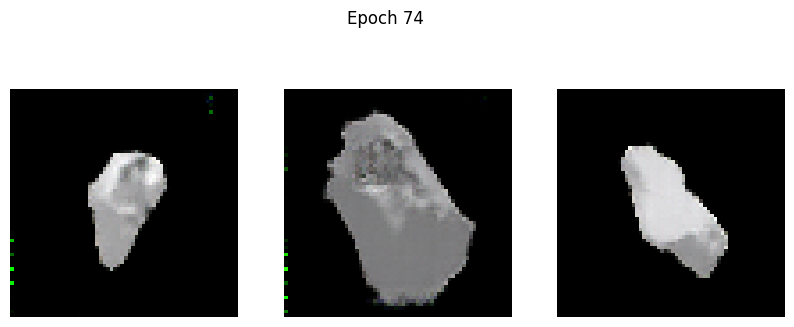

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2853 - g_loss: 2.1208
Epoch 75/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3118 - g_loss: 2.2065

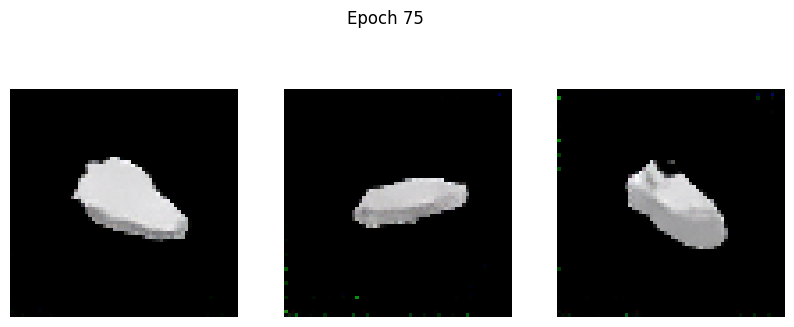

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3114 - g_loss: 2.2061
Epoch 76/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2581 - g_loss: 2.1937

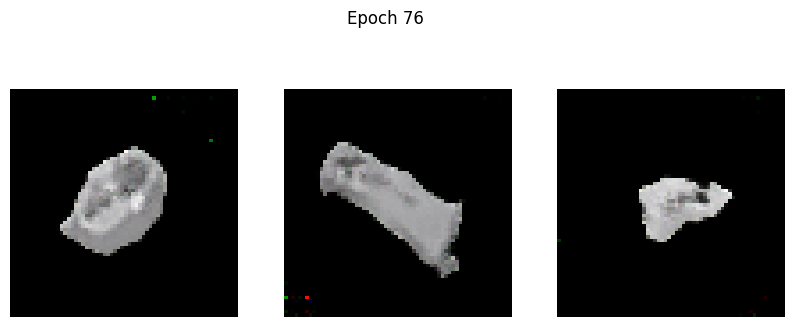

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2582 - g_loss: 2.1938
Epoch 77/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2733 - g_loss: 2.2394

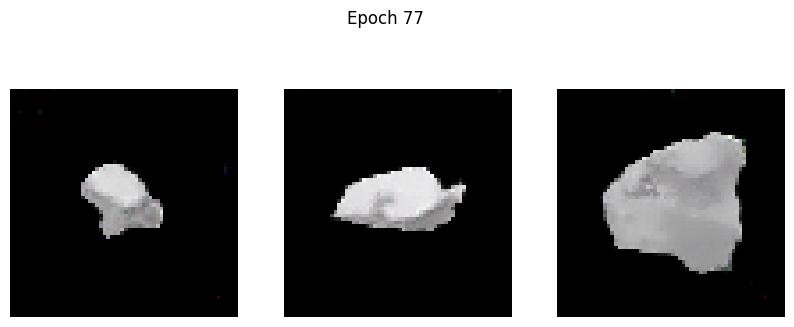

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2733 - g_loss: 2.2391
Epoch 78/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.5456 - g_loss: 2.3887

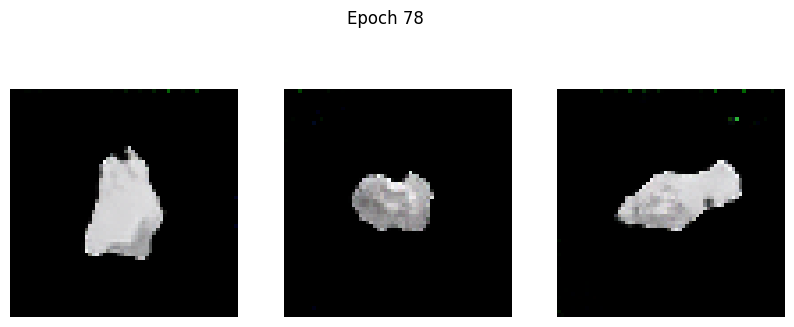

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.5440 - g_loss: 2.3867
Epoch 79/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2311 - g_loss: 2.1454

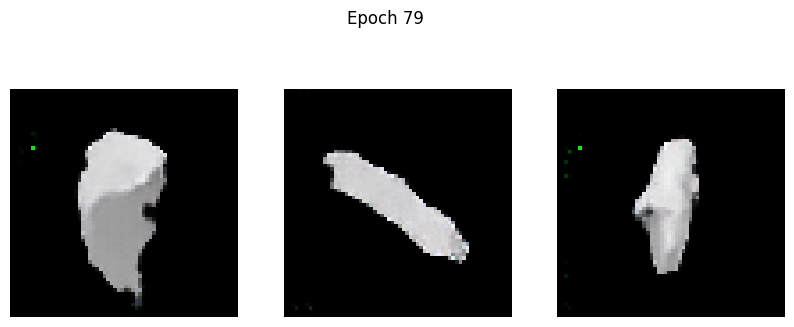

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2311 - g_loss: 2.1454
Epoch 80/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2975 - g_loss: 2.2690

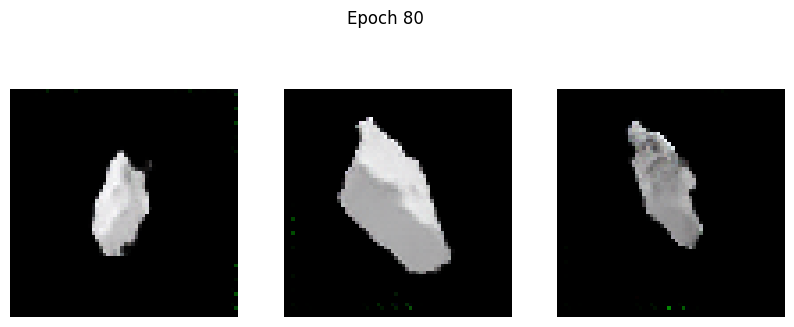

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2973 - g_loss: 2.2688
Epoch 81/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2115 - g_loss: 2.1699

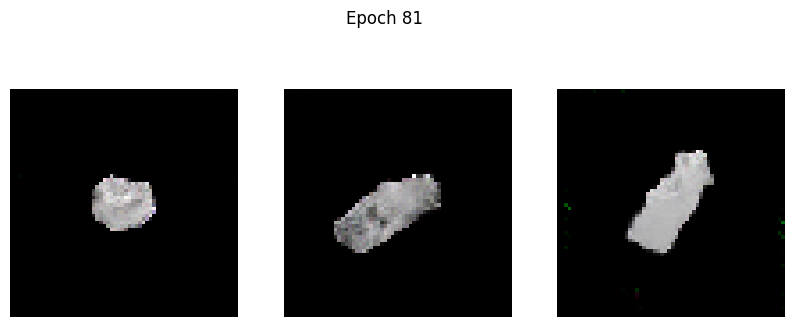

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2118 - g_loss: 2.1705
Epoch 82/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3696 - g_loss: 2.3911

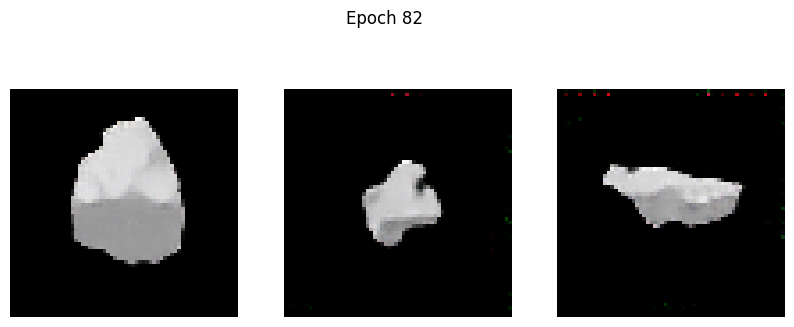

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3688 - g_loss: 2.3898
Epoch 83/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2267 - g_loss: 2.2346

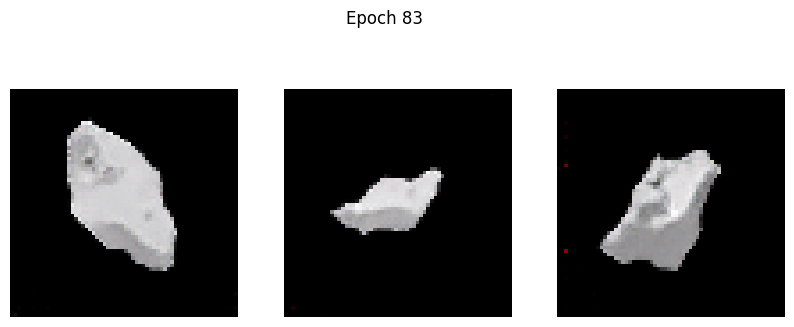

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2268 - g_loss: 2.2346
Epoch 84/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2239 - g_loss: 2.2706

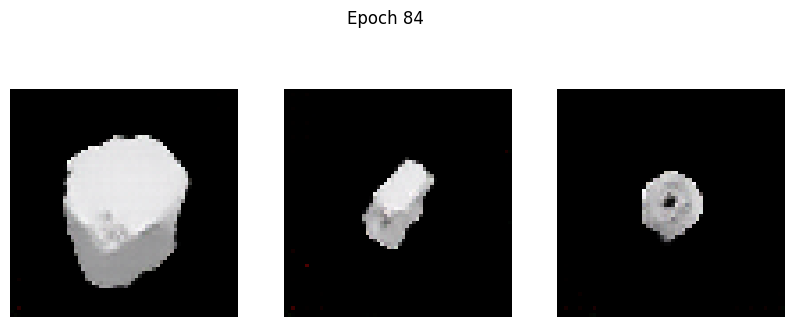

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2240 - g_loss: 2.2707
Epoch 85/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2556 - g_loss: 2.4146

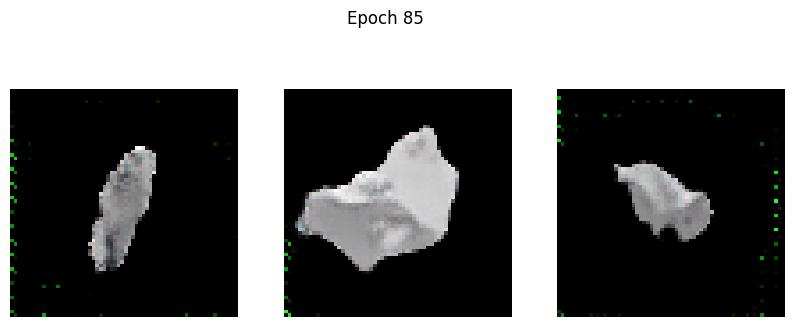

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2560 - g_loss: 2.4145
Epoch 86/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3241 - g_loss: 2.3765

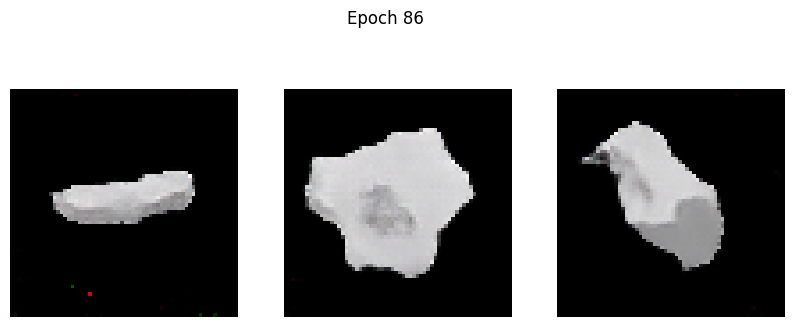

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3234 - g_loss: 2.3760
Epoch 87/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2504 - g_loss: 2.2816

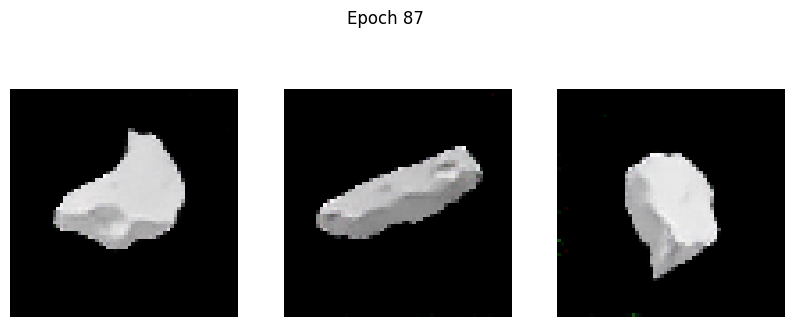

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2505 - g_loss: 2.2820
Epoch 88/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1991 - g_loss: 2.3307

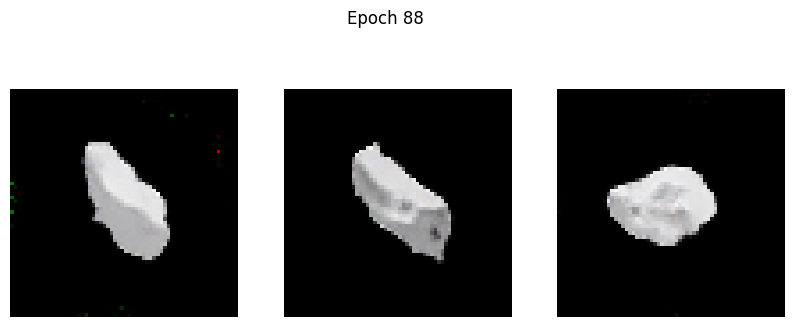

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1994 - g_loss: 2.3308
Epoch 89/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2140 - g_loss: 2.3831

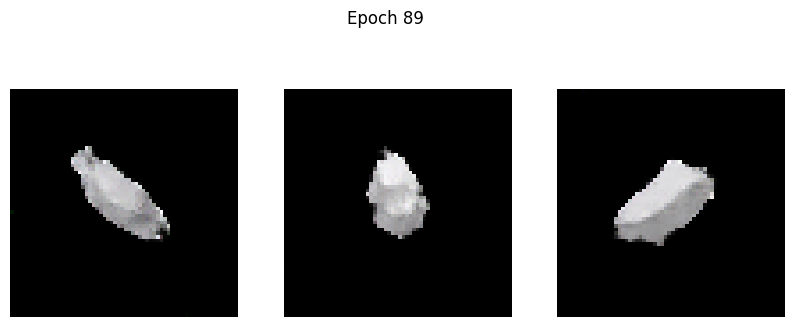

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2141 - g_loss: 2.3830
Epoch 90/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2163 - g_loss: 2.4621

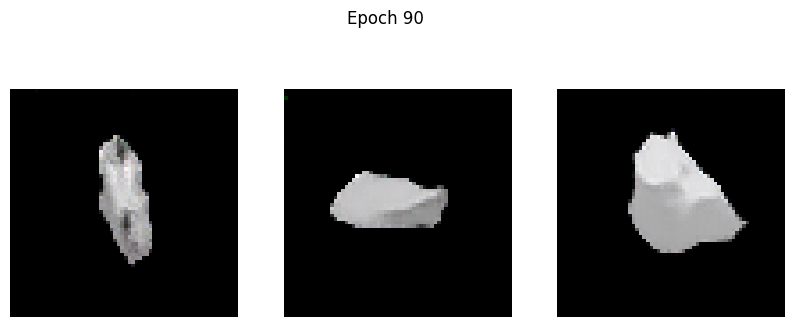

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2167 - g_loss: 2.4622
Epoch 91/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.4099 - g_loss: 2.6378

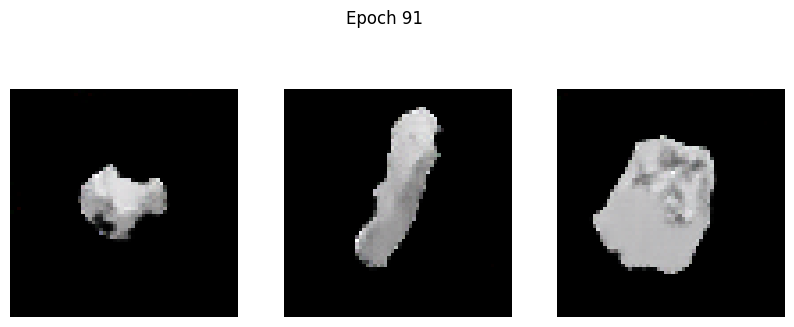

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.4089 - g_loss: 2.6356
Epoch 92/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2029 - g_loss: 2.3570

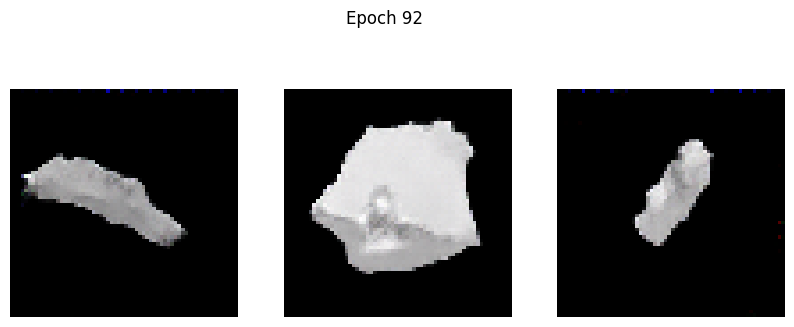

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2029 - g_loss: 2.3572
Epoch 93/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2085 - g_loss: 2.4534

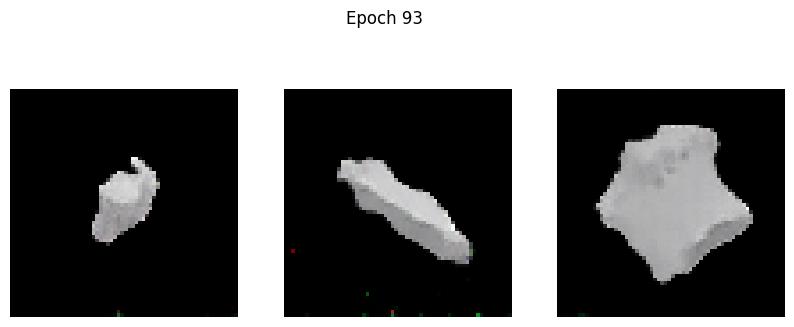

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.2087 - g_loss: 2.4534
Epoch 94/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2124 - g_loss: 2.4051

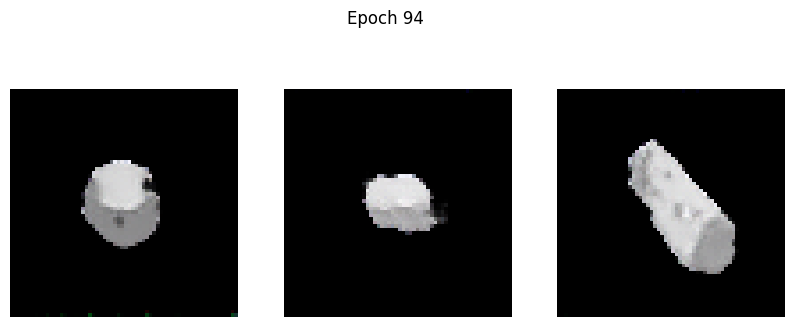

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2131 - g_loss: 2.4061
Epoch 95/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2329 - g_loss: 2.3635

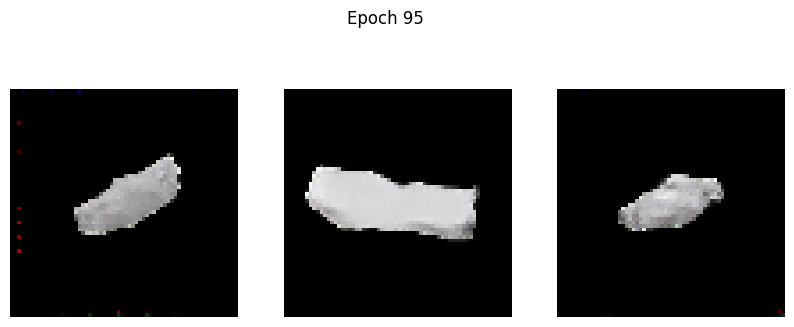

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2327 - g_loss: 2.3638
Epoch 96/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1941 - g_loss: 2.4242

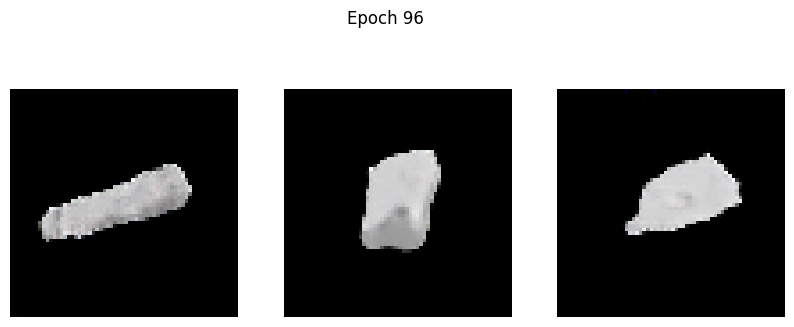

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1946 - g_loss: 2.4248
Epoch 97/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2504 - g_loss: 2.5164

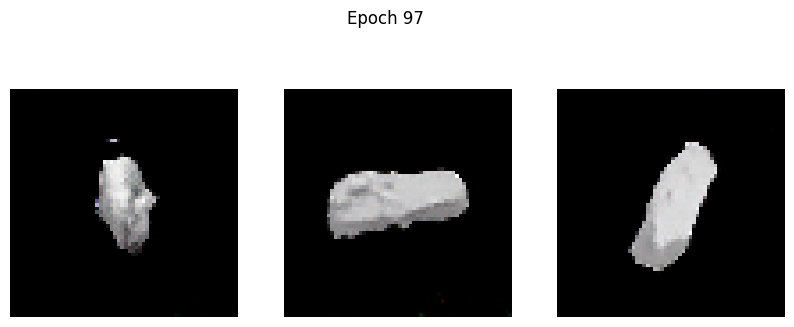

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2503 - g_loss: 2.5163
Epoch 98/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2069 - g_loss: 2.4117

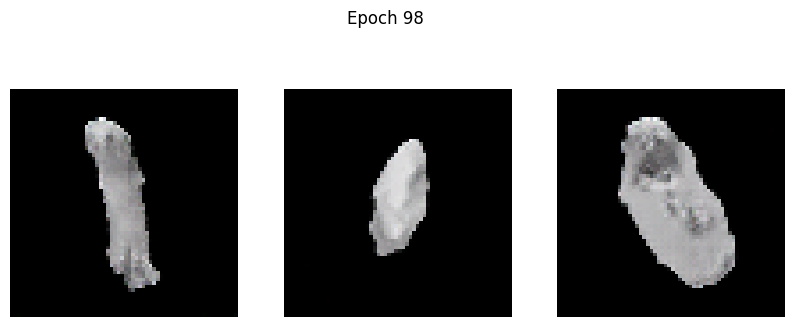

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2070 - g_loss: 2.4119
Epoch 99/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2765 - g_loss: 2.5001

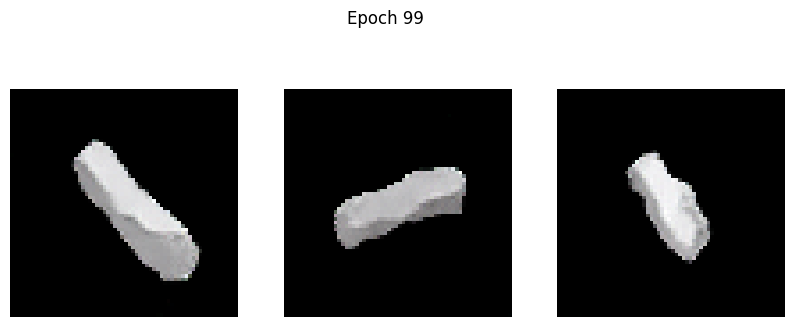

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2761 - g_loss: 2.4999
Epoch 100/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2067 - g_loss: 2.5135

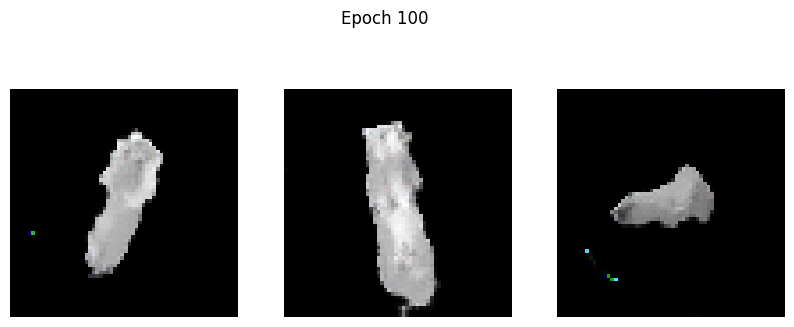

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2069 - g_loss: 2.5137
Epoch 101/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2975 - g_loss: 2.5480

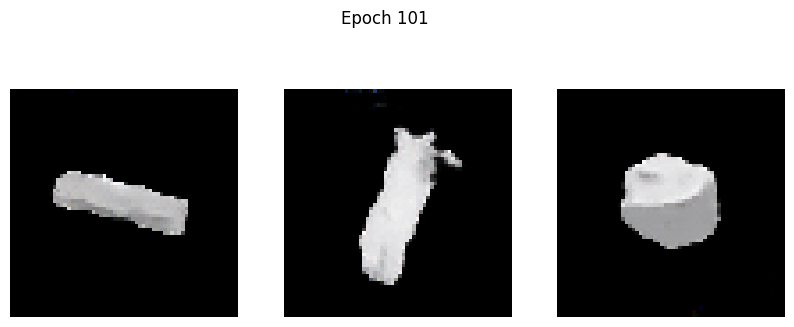

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2968 - g_loss: 2.5476
Epoch 102/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2057 - g_loss: 2.5434

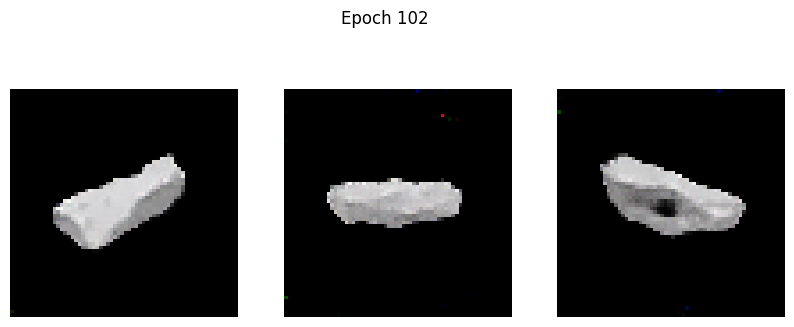

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2059 - g_loss: 2.5434
Epoch 103/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1875 - g_loss: 2.5201

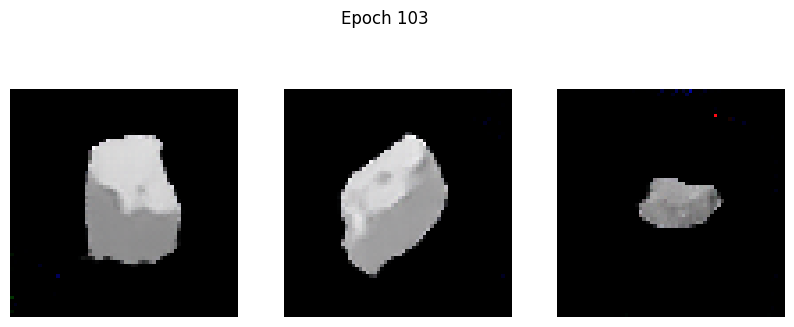

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1876 - g_loss: 2.5200
Epoch 104/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1791 - g_loss: 2.6689

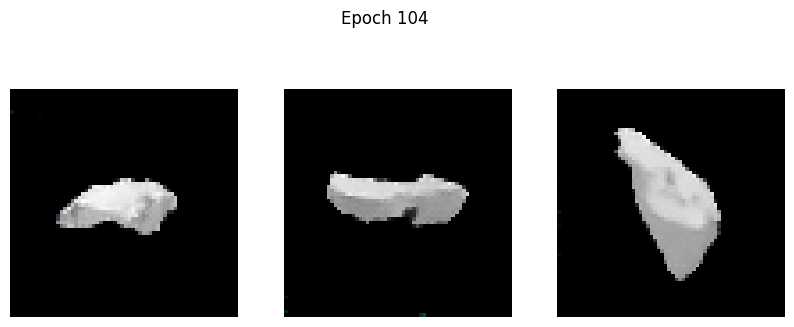

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1796 - g_loss: 2.6687
Epoch 105/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1879 - g_loss: 2.5841

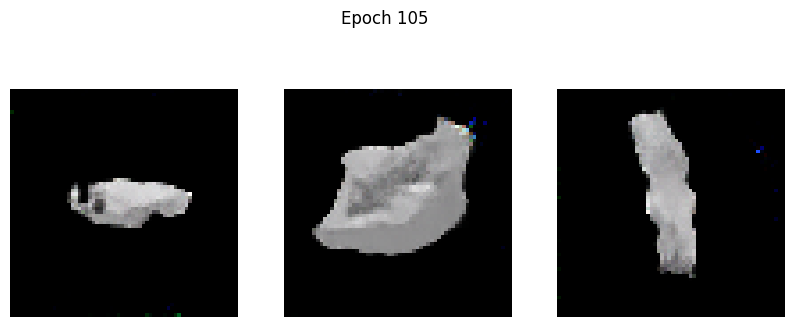

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1880 - g_loss: 2.5840
Epoch 106/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1961 - g_loss: 2.5873

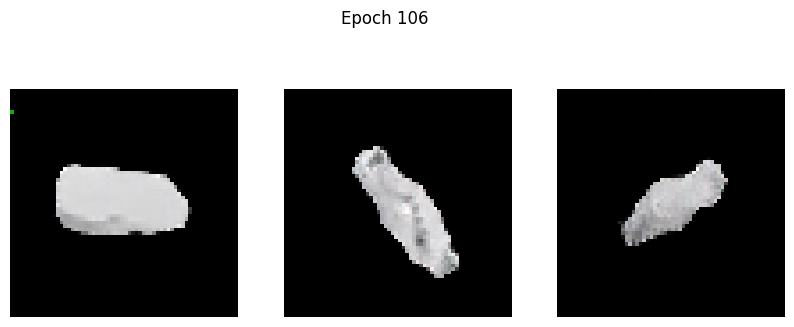

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1963 - g_loss: 2.5872
Epoch 107/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1840 - g_loss: 2.6127

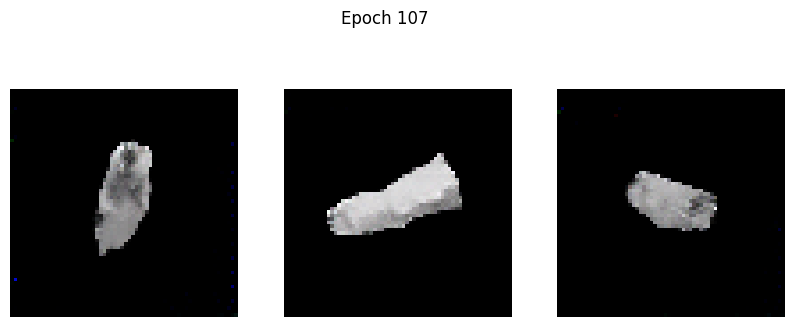

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1841 - g_loss: 2.6129
Epoch 108/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2888 - g_loss: 2.6893

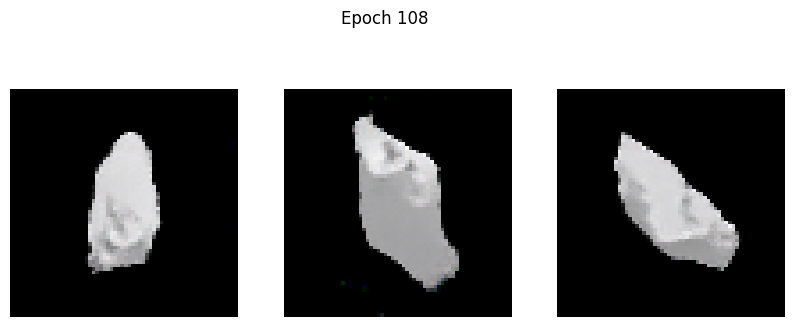

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2883 - g_loss: 2.6886
Epoch 109/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2041 - g_loss: 2.5825

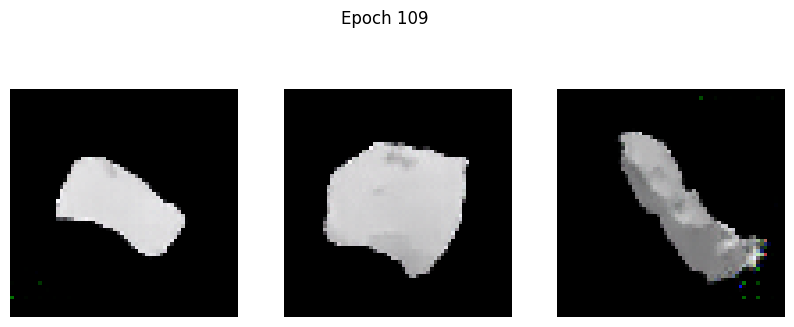

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2047 - g_loss: 2.5832
Epoch 110/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1794 - g_loss: 2.5797

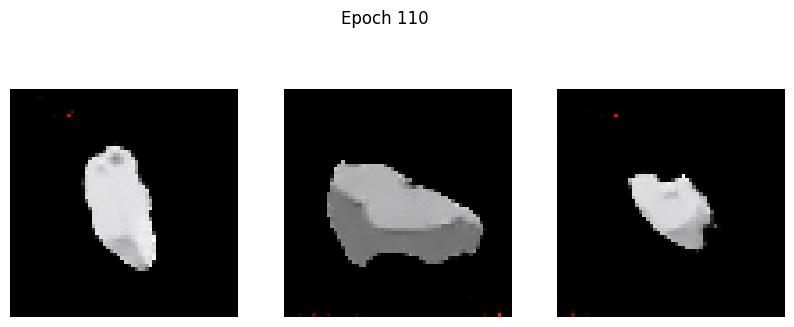

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1799 - g_loss: 2.5805
Epoch 111/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1959 - g_loss: 2.5999

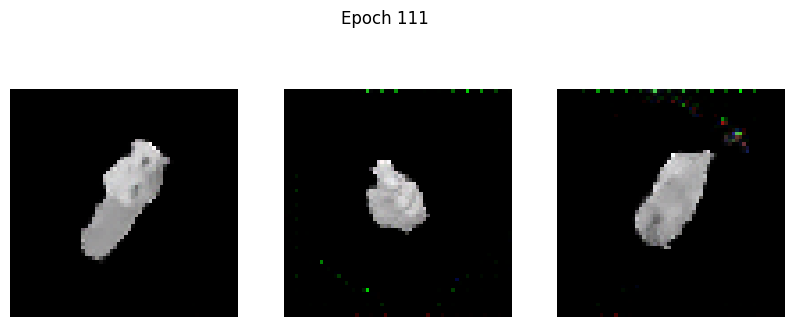

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1962 - g_loss: 2.6004
Epoch 112/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1678 - g_loss: 2.5674

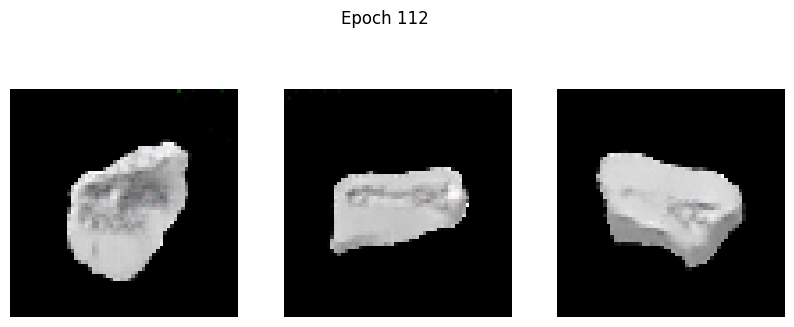

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1679 - g_loss: 2.5676
Epoch 113/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1589 - g_loss: 2.6545

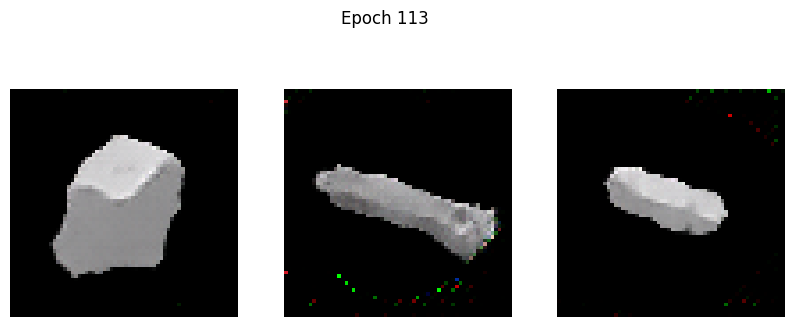

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1592 - g_loss: 2.6549
Epoch 114/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.9644 - g_loss: 3.1176

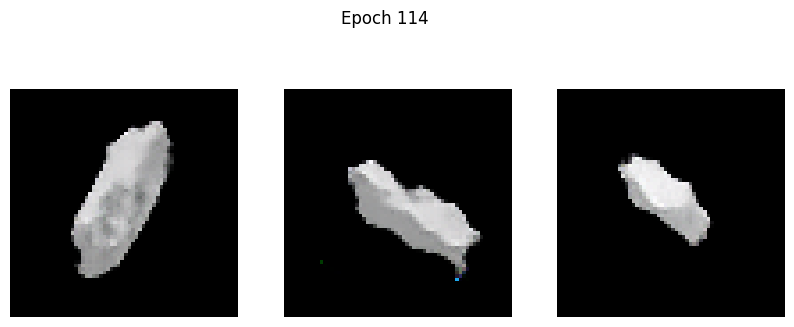

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.9600 - g_loss: 3.1126
Epoch 115/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1761 - g_loss: 2.4490

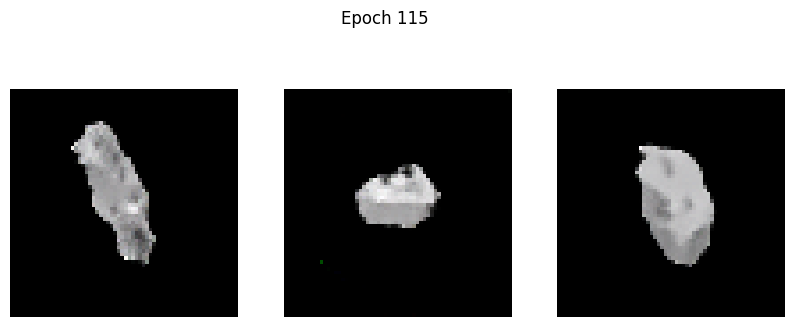

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1761 - g_loss: 2.4494
Epoch 116/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1594 - g_loss: 2.5767

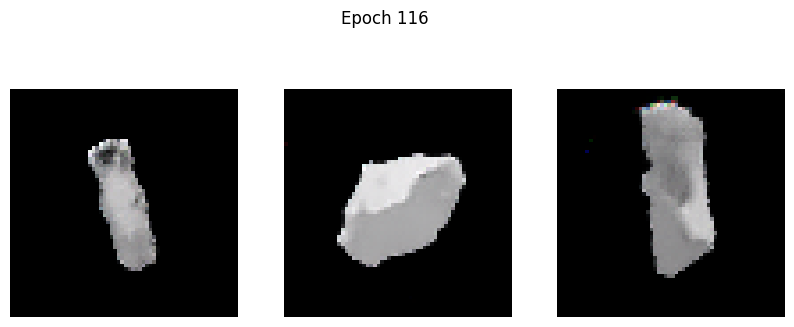

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1595 - g_loss: 2.5767
Epoch 117/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1883 - g_loss: 2.7360

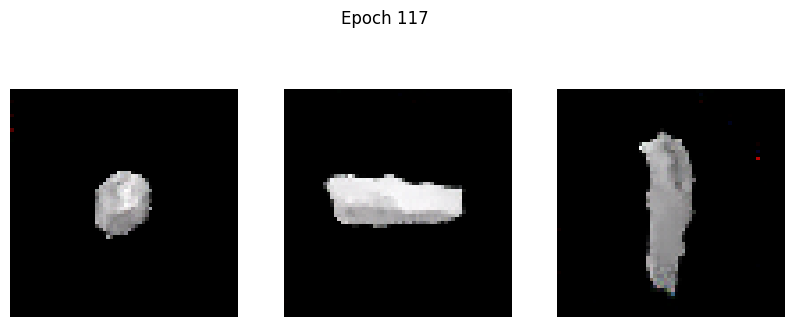

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1881 - g_loss: 2.7353
Epoch 118/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1537 - g_loss: 2.6372

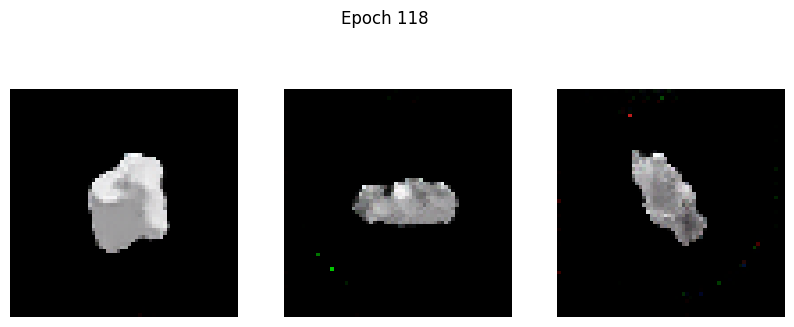

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1539 - g_loss: 2.6375
Epoch 119/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1709 - g_loss: 2.7488

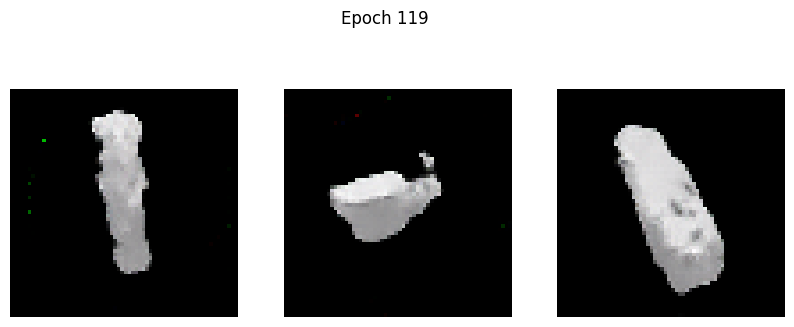

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1714 - g_loss: 2.7498
Epoch 120/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1796 - g_loss: 2.6743

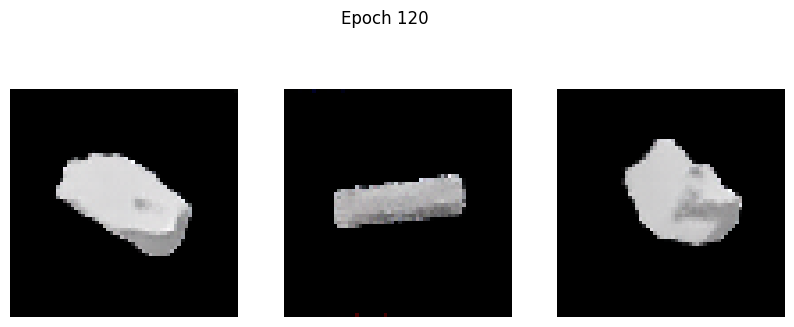

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1796 - g_loss: 2.6746
Epoch 121/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1817 - g_loss: 2.7680

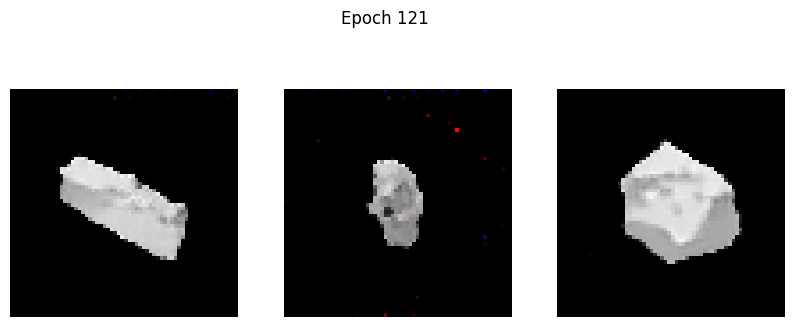

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1817 - g_loss: 2.7678
Epoch 122/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2154 - g_loss: 2.8320

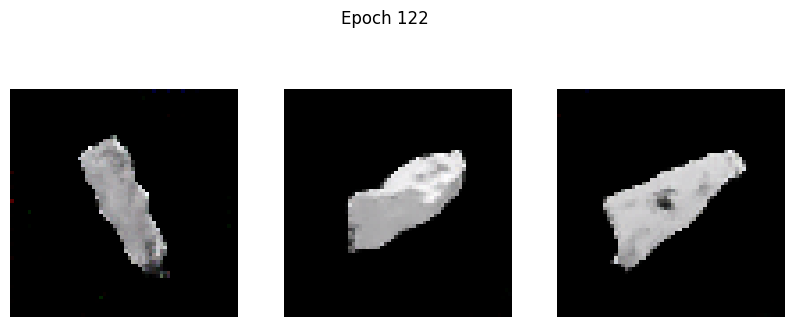

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2156 - g_loss: 2.8316
Epoch 123/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1603 - g_loss: 2.6975

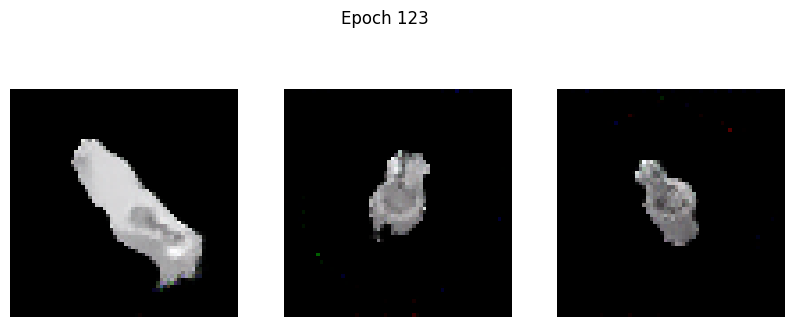

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1603 - g_loss: 2.6978
Epoch 124/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1461 - g_loss: 2.8094

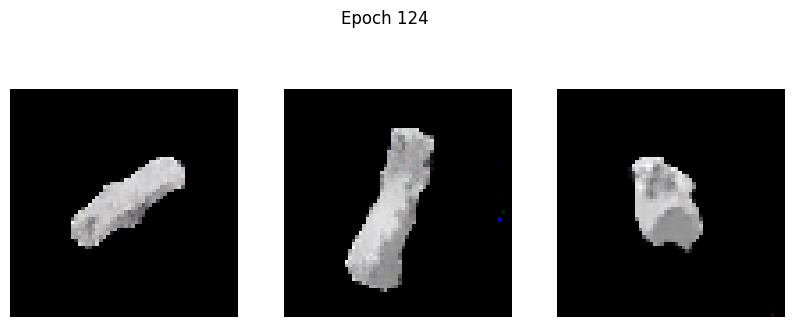

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1462 - g_loss: 2.8093
Epoch 125/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2402 - g_loss: 2.8835

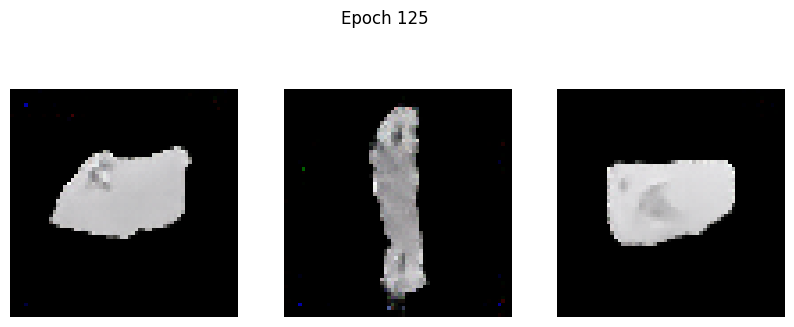

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2403 - g_loss: 2.8833
Epoch 126/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1781 - g_loss: 2.8233

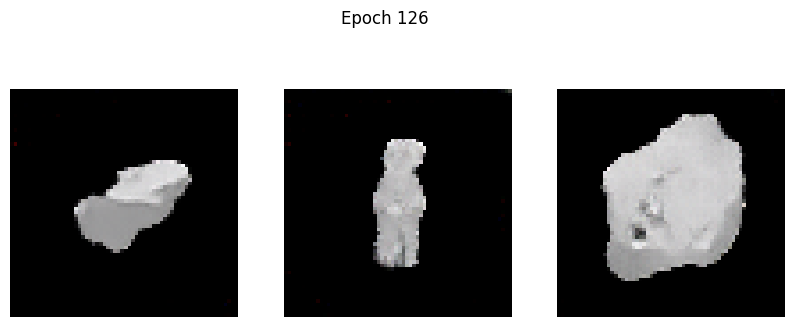

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1784 - g_loss: 2.8235
Epoch 127/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1392 - g_loss: 2.8260

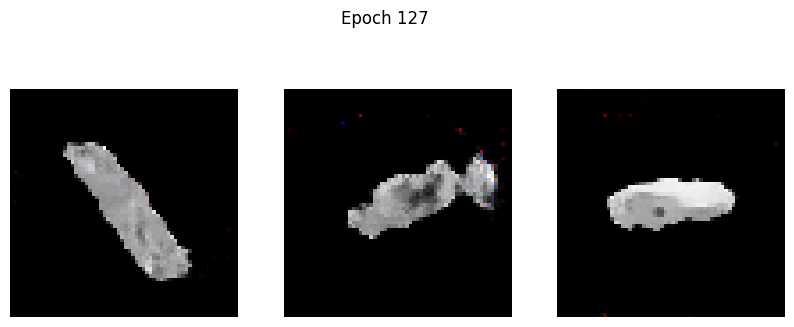

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1394 - g_loss: 2.8258
Epoch 128/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1541 - g_loss: 2.8467

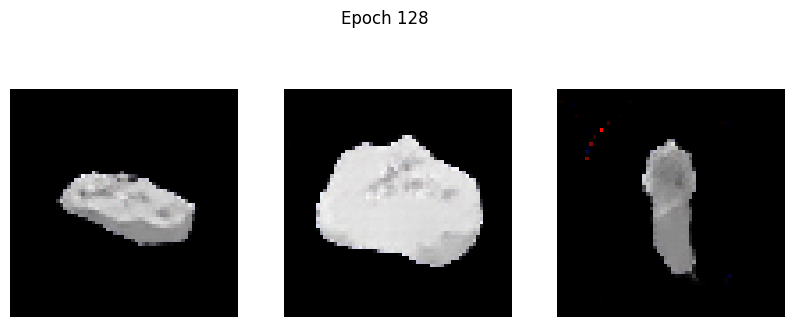

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1543 - g_loss: 2.8472
Epoch 129/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1898 - g_loss: 2.9016

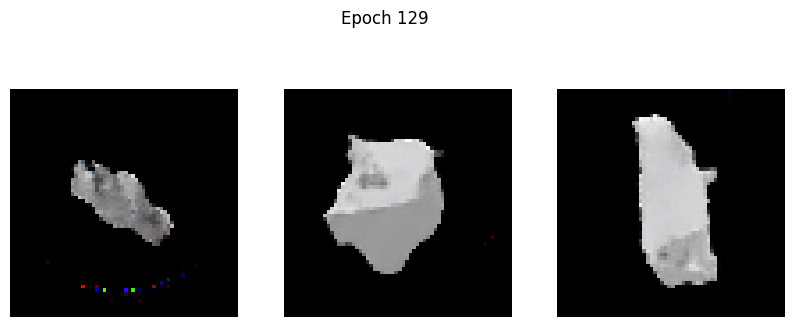

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1907 - g_loss: 2.9024
Epoch 130/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1603 - g_loss: 2.7950

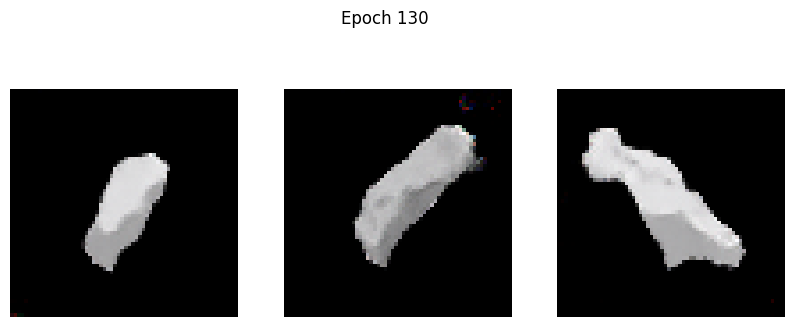

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1603 - g_loss: 2.7949
Epoch 131/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1393 - g_loss: 2.8189

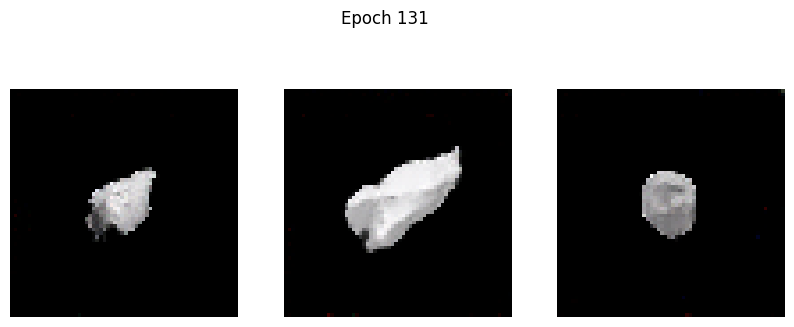

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1393 - g_loss: 2.8187
Epoch 132/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2120 - g_loss: 3.0324

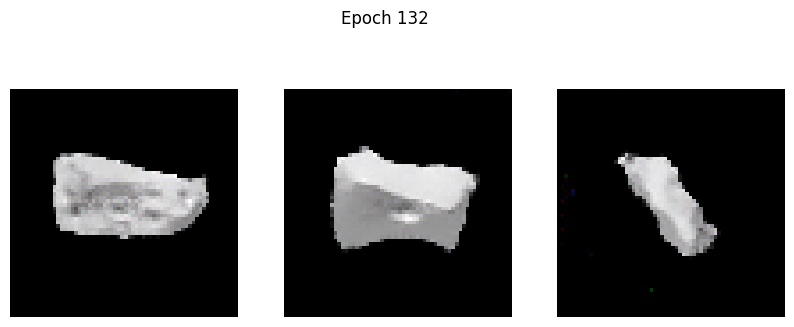

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2121 - g_loss: 3.0313
Epoch 133/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1840 - g_loss: 2.9450

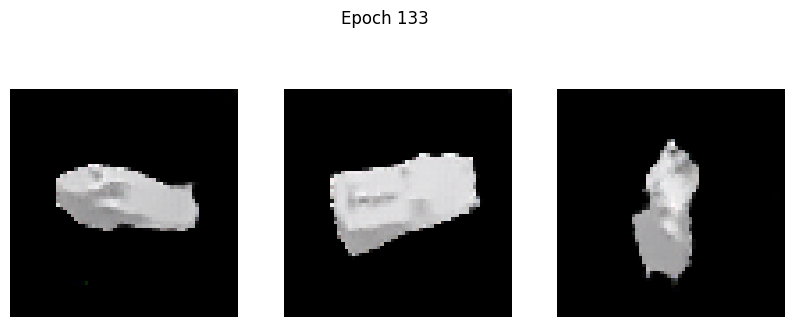

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1839 - g_loss: 2.9445
Epoch 134/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.3120 - g_loss: 3.0362

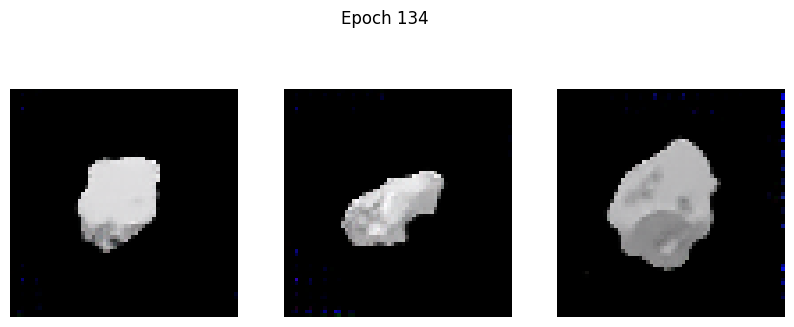

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.3110 - g_loss: 3.0346
Epoch 135/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1586 - g_loss: 2.8692

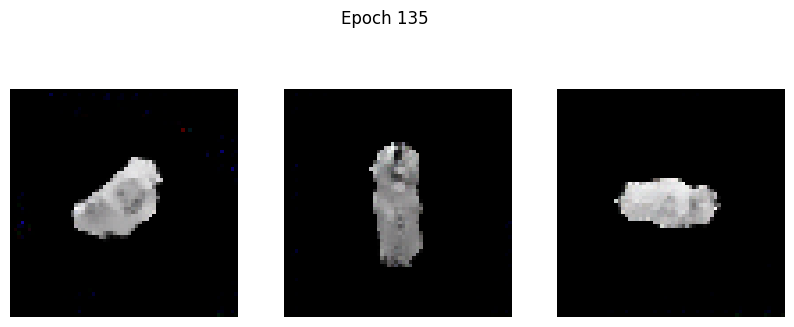

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1584 - g_loss: 2.8690
Epoch 136/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1905 - g_loss: 3.0434

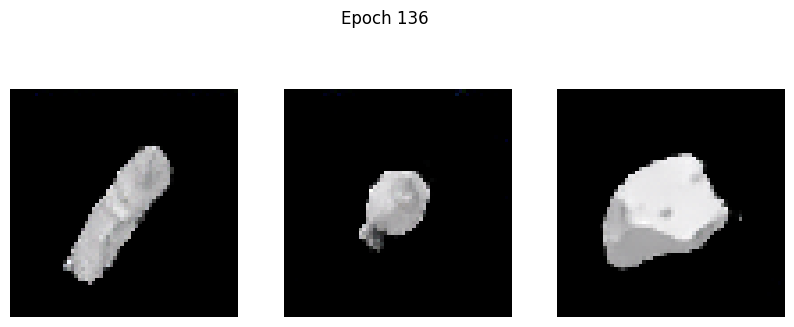

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1908 - g_loss: 3.0431
Epoch 137/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1347 - g_loss: 2.8496

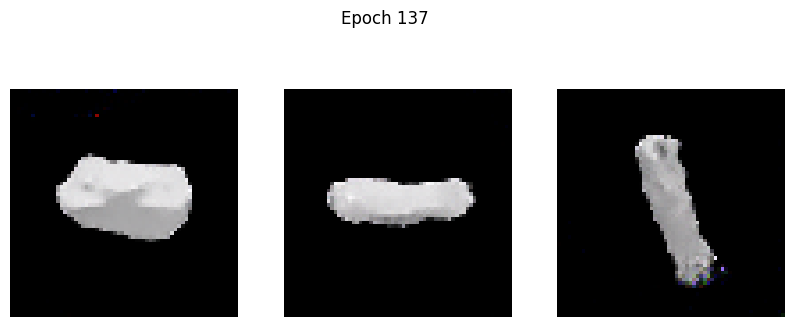

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1348 - g_loss: 2.8498
Epoch 138/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2027 - g_loss: 3.0135

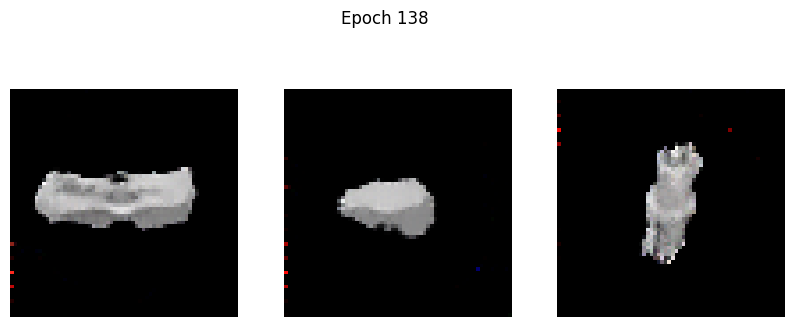

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2033 - g_loss: 3.0140
Epoch 139/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1620 - g_loss: 2.8266

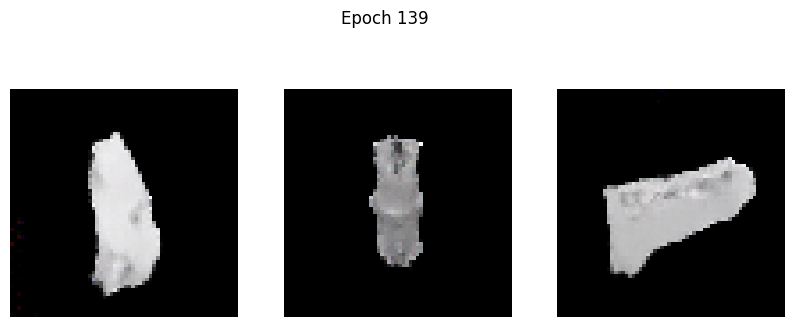

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1620 - g_loss: 2.8273
Epoch 140/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1615 - g_loss: 2.9179

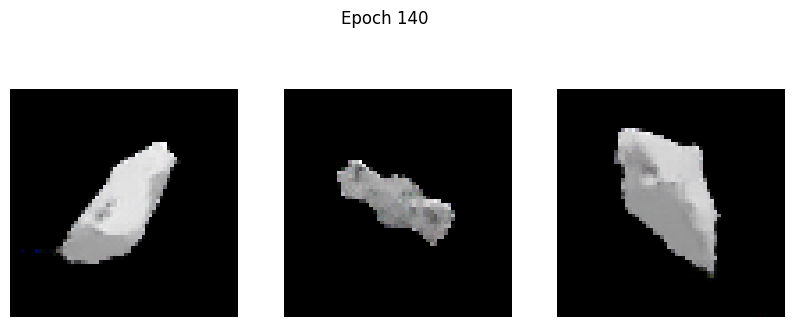

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1620 - g_loss: 2.9189
Epoch 141/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1426 - g_loss: 2.8489

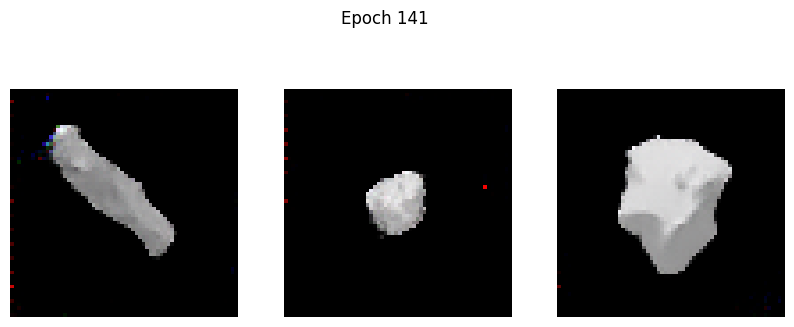

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1425 - g_loss: 2.8494
Epoch 142/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1332 - g_loss: 2.9592

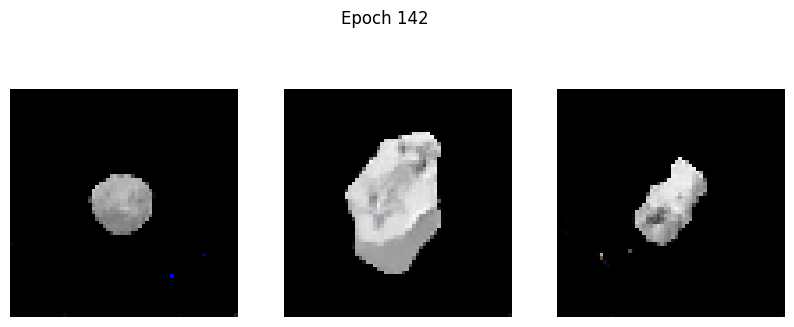

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1332 - g_loss: 2.9594
Epoch 143/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2243 - g_loss: 3.1605

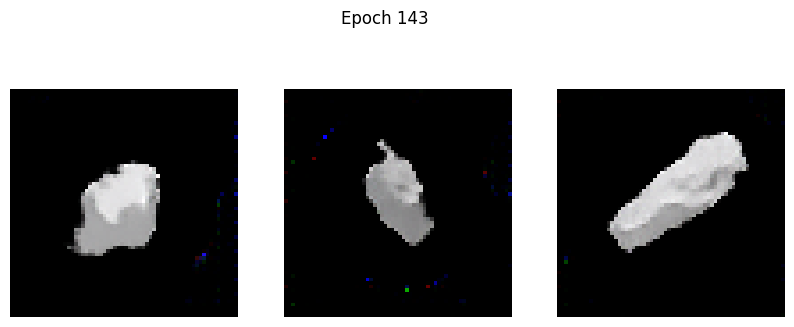

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2247 - g_loss: 3.1597
Epoch 144/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1385 - g_loss: 2.9502

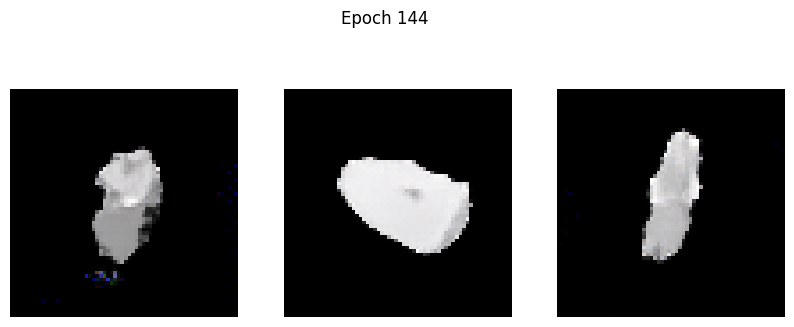

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1385 - g_loss: 2.9505
Epoch 145/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1481 - g_loss: 3.0301

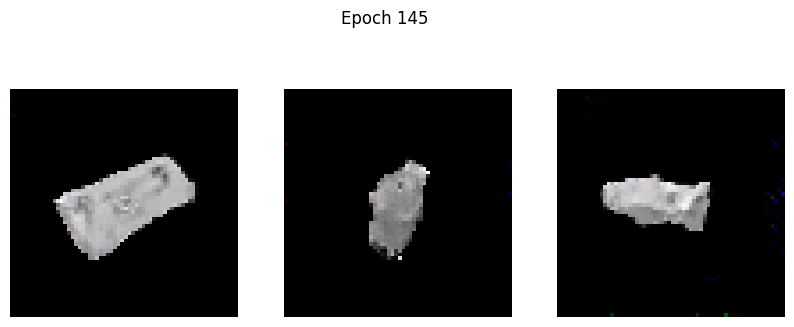

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1484 - g_loss: 3.0302
Epoch 146/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1271 - g_loss: 3.0745

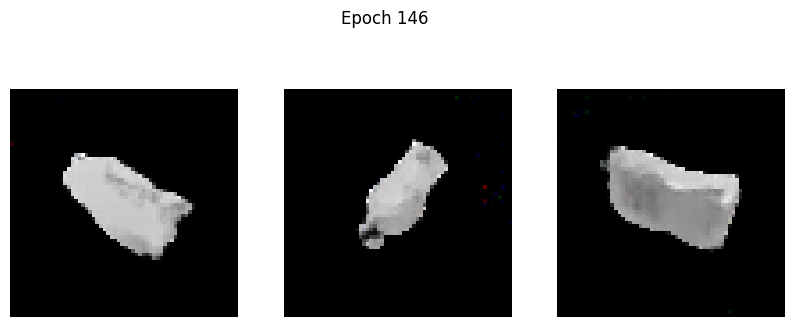

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1272 - g_loss: 3.0739
Epoch 147/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1682 - g_loss: 3.0257

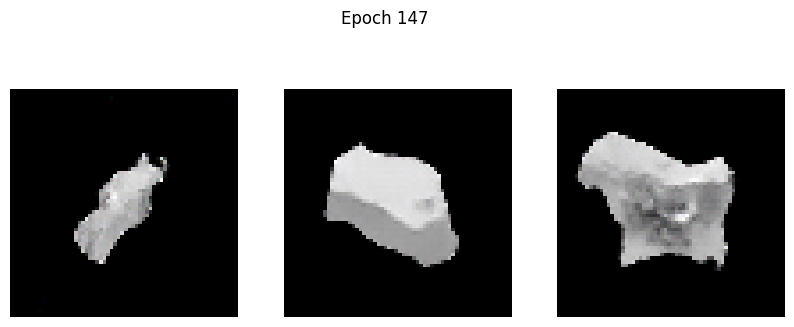

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1681 - g_loss: 3.0257
Epoch 148/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1791 - g_loss: 3.1089

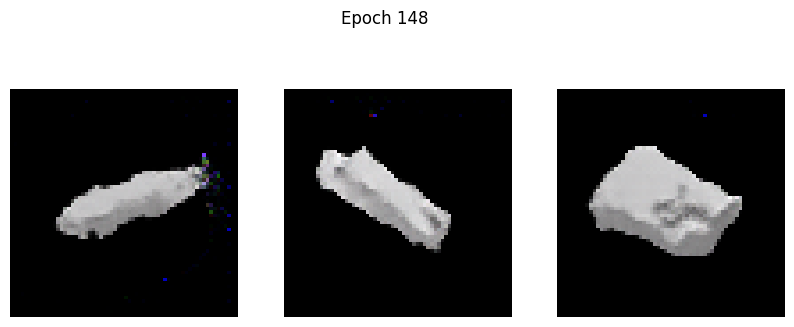

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1801 - g_loss: 3.1101
Epoch 149/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1458 - g_loss: 2.9706

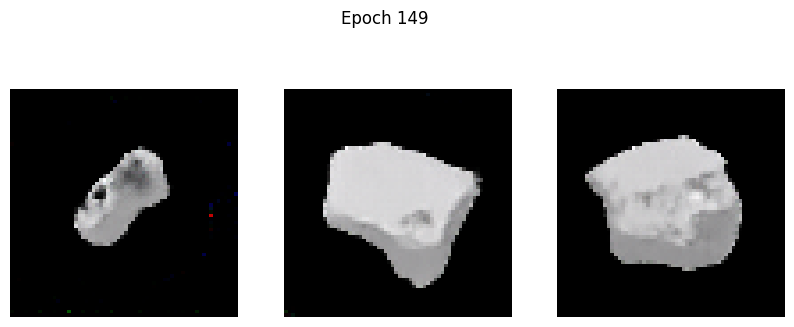

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1456 - g_loss: 2.9702
Epoch 150/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1246 - g_loss: 2.9928

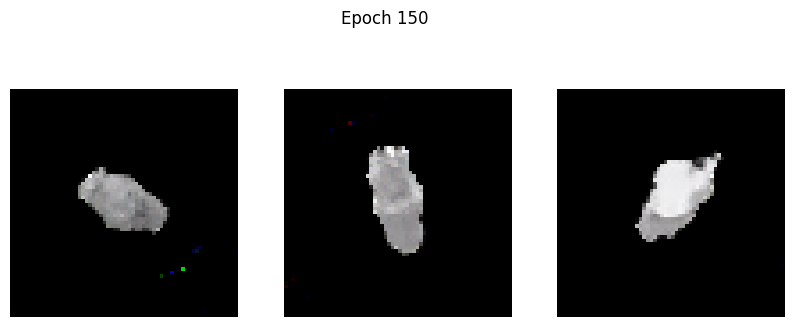

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1249 - g_loss: 2.9934
Epoch 151/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1510 - g_loss: 3.0988

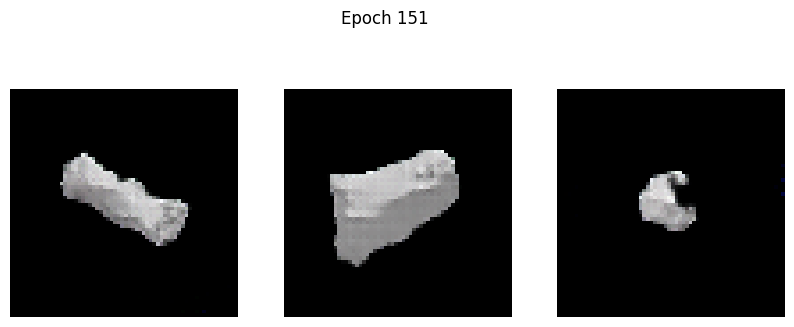

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1520 - g_loss: 3.1000
Epoch 152/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.4729 - g_loss: 3.0965

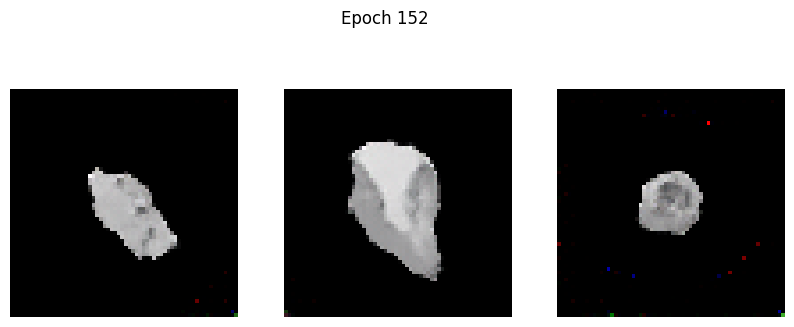

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.4707 - g_loss: 3.0952
Epoch 153/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1656 - g_loss: 3.0075

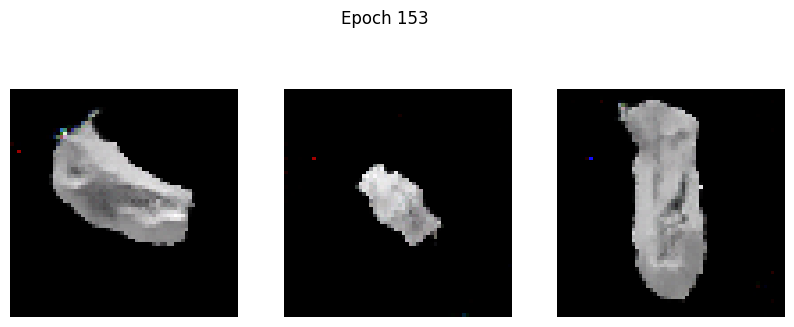

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1655 - g_loss: 3.0076
Epoch 154/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1216 - g_loss: 3.1051

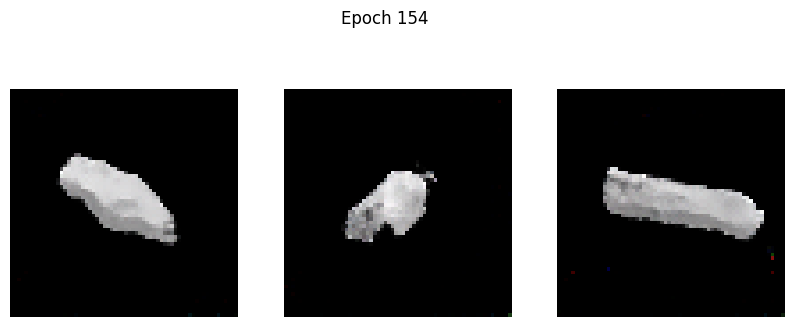

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1216 - g_loss: 3.1047
Epoch 155/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.1158 - g_loss: 3.0467

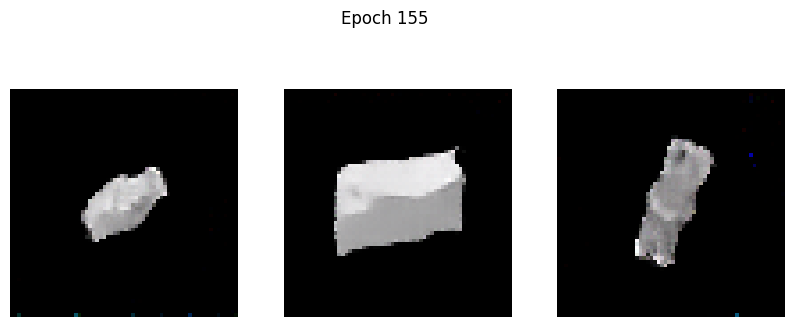

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1160 - g_loss: 3.0472
Epoch 156/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1374 - g_loss: 3.1253

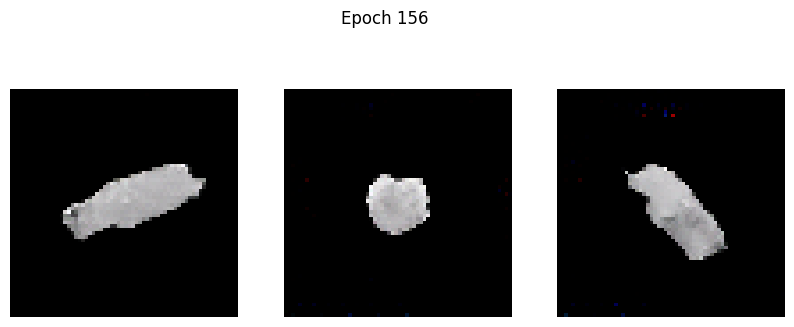

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1374 - g_loss: 3.1252
Epoch 157/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1643 - g_loss: 3.2520

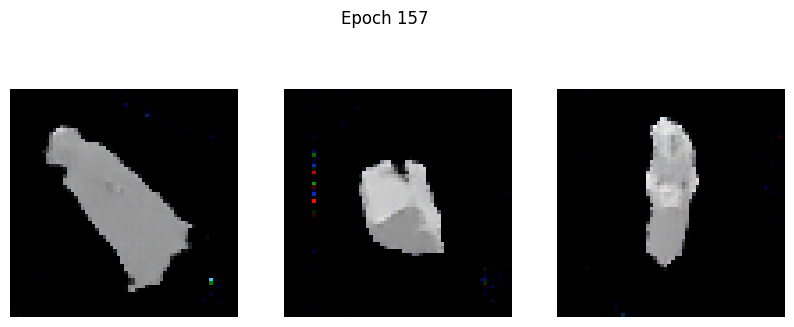

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1647 - g_loss: 3.2516
Epoch 158/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1540 - g_loss: 3.1973

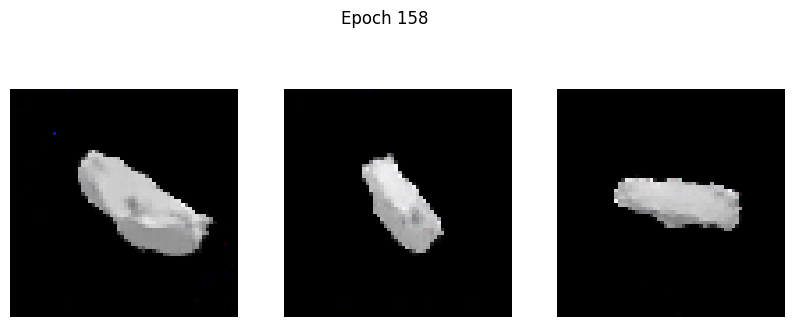

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1537 - g_loss: 3.1968
Epoch 159/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.2209 - g_loss: 3.2666

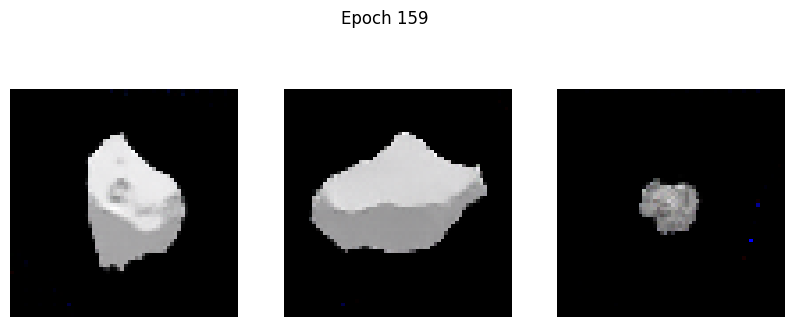

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2208 - g_loss: 3.2660
Epoch 160/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1945 - g_loss: 3.2703

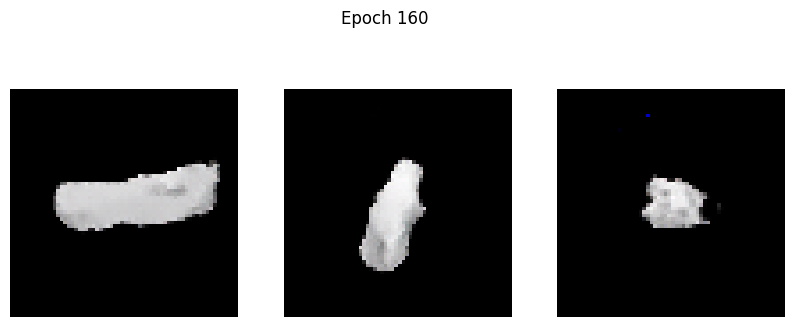

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1946 - g_loss: 3.2701
Epoch 161/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1623 - g_loss: 3.1440

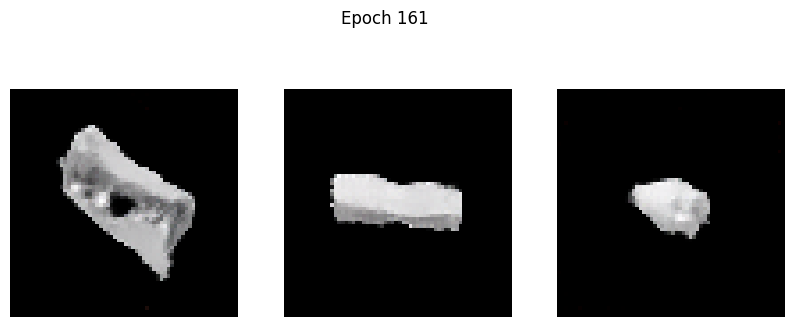

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1622 - g_loss: 3.1438
Epoch 162/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1179 - g_loss: 3.1055

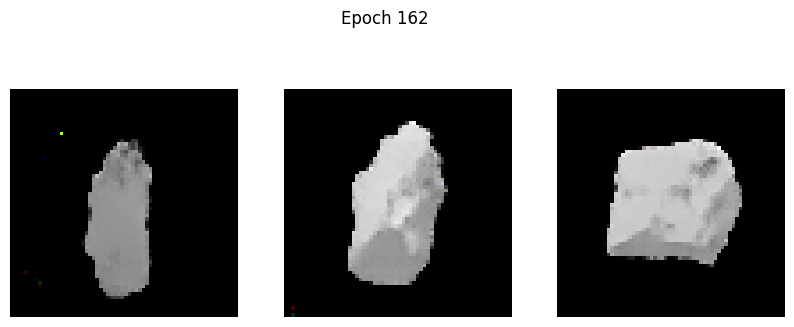

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1179 - g_loss: 3.1059
Epoch 163/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1929 - g_loss: 3.3449

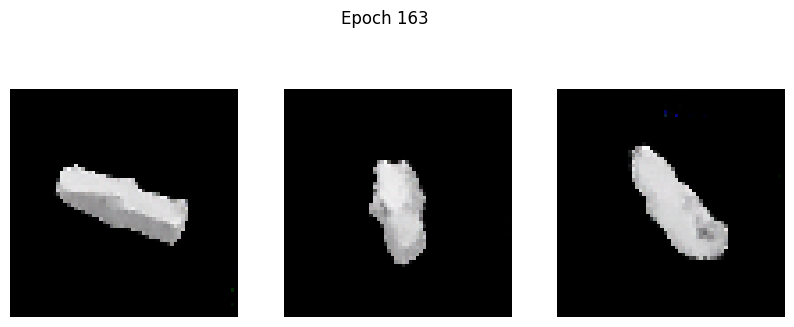

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1924 - g_loss: 3.3439
Epoch 164/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.1558 - g_loss: 3.3442

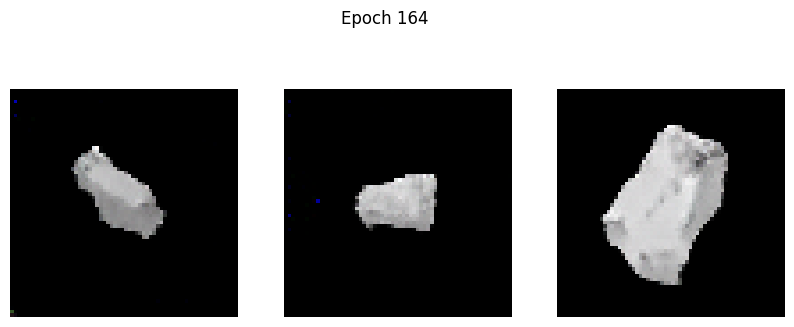

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1558 - g_loss: 3.3434
Epoch 165/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1810 - g_loss: 3.2797

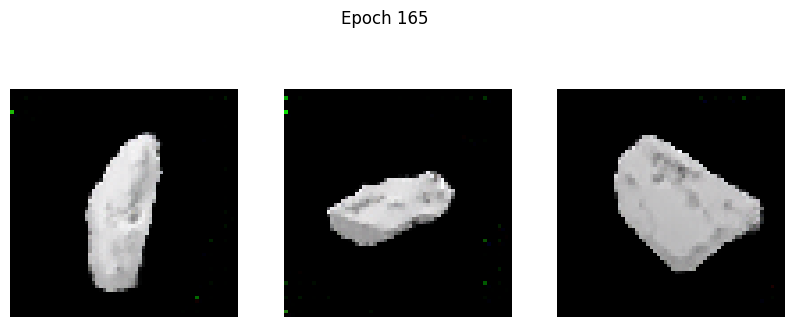

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1808 - g_loss: 3.2797
Epoch 166/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1164 - g_loss: 3.2648

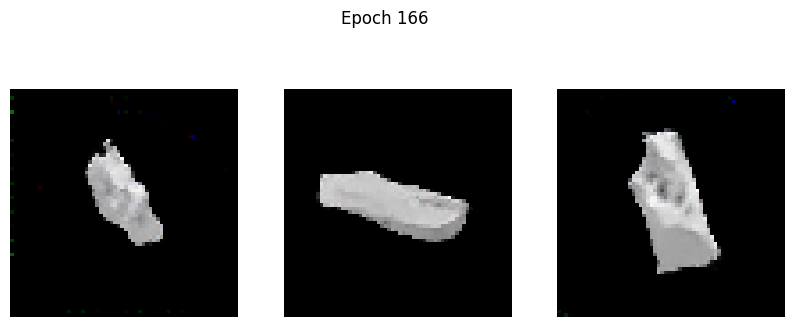

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1163 - g_loss: 3.2645
Epoch 167/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1340 - g_loss: 3.2760

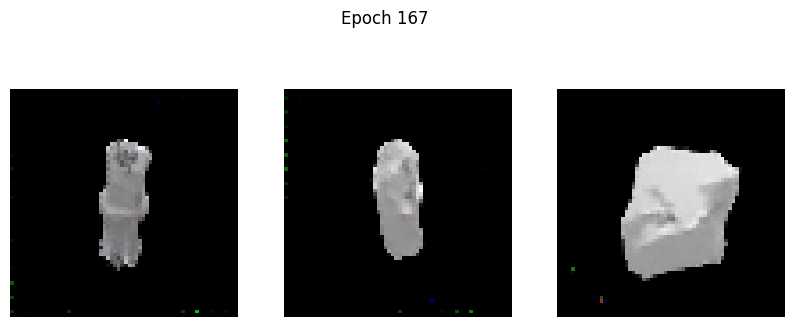

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1345 - g_loss: 3.2764
Epoch 168/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1086 - g_loss: 3.2350

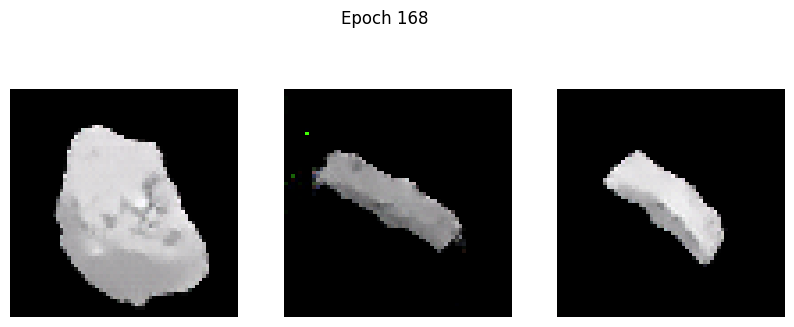

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.1089 - g_loss: 3.2351
Epoch 169/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1149 - g_loss: 3.2983

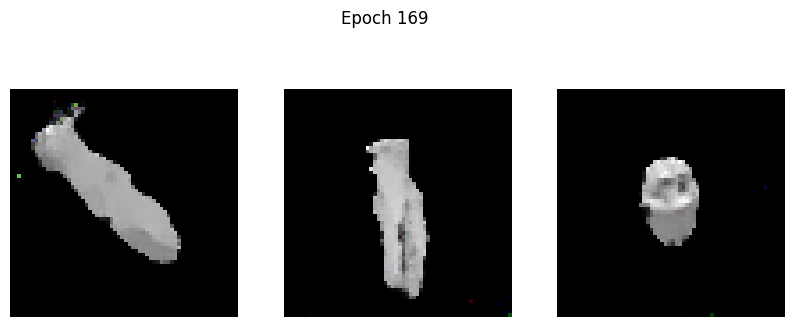

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1149 - g_loss: 3.2984
Epoch 170/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1673 - g_loss: 3.3508

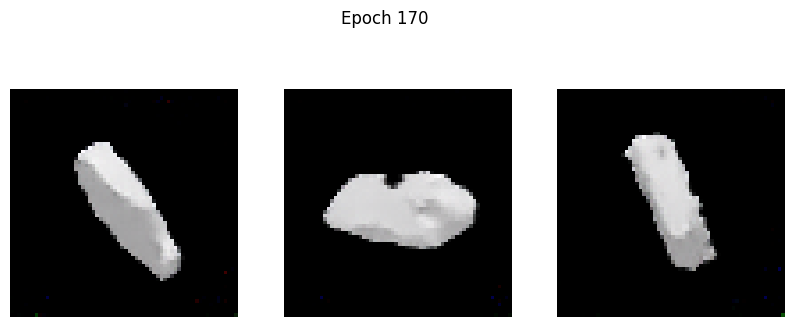

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.1674 - g_loss: 3.3514
Epoch 171/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2439 - g_loss: 3.3121

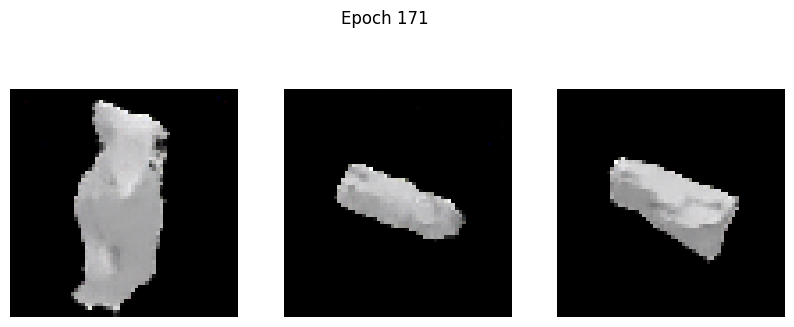

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2433 - g_loss: 3.3118
Epoch 172/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.4249 - g_loss: 3.5362

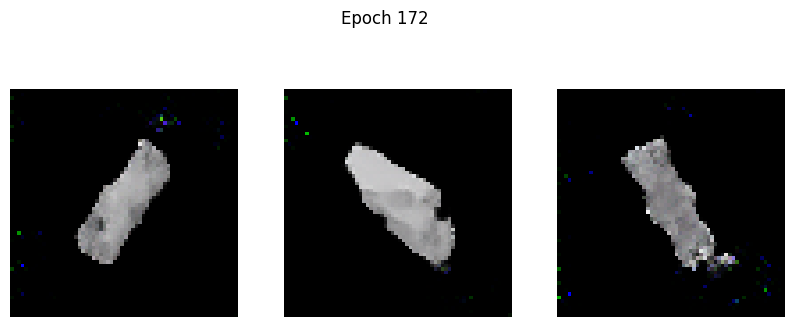

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.4249 - g_loss: 3.5347
Epoch 173/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1257 - g_loss: 3.0556

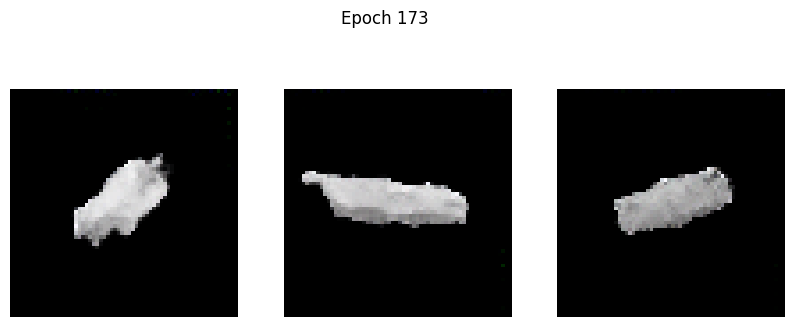

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1256 - g_loss: 3.0557
Epoch 174/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1084 - g_loss: 3.1427

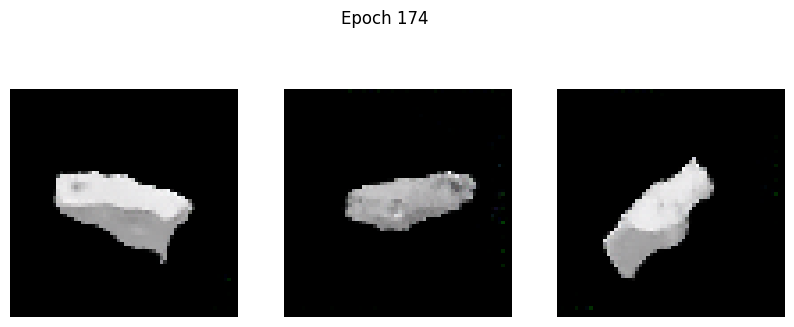

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.1084 - g_loss: 3.1426
Epoch 175/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1023 - g_loss: 3.2310

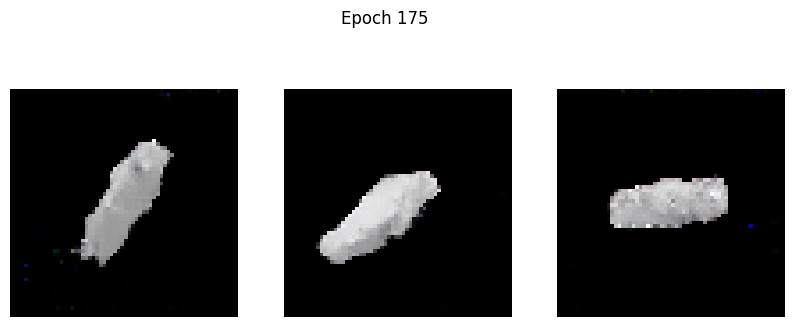

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1025 - g_loss: 3.2316
Epoch 176/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1272 - g_loss: 3.3255

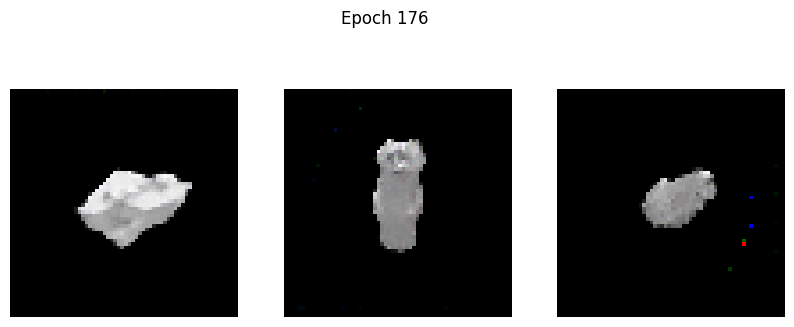

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1270 - g_loss: 3.3253
Epoch 177/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1422 - g_loss: 3.3445

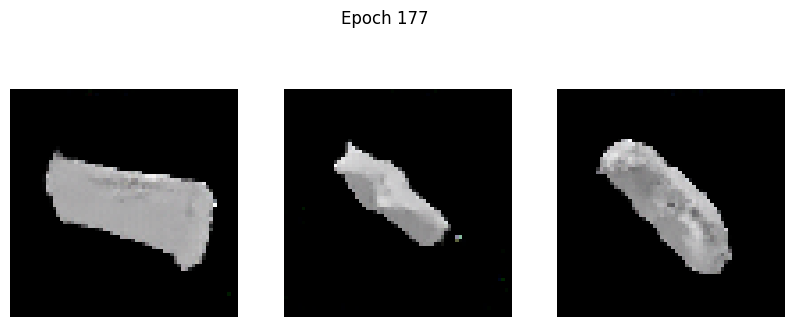

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1422 - g_loss: 3.3446
Epoch 178/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1251 - g_loss: 3.4312

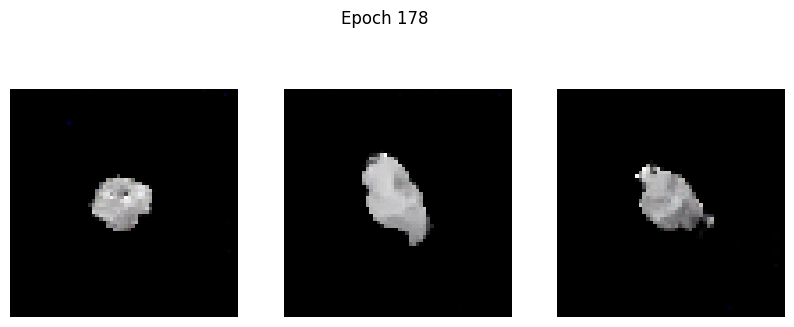

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1255 - g_loss: 3.4307
Epoch 179/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1068 - g_loss: 3.2888

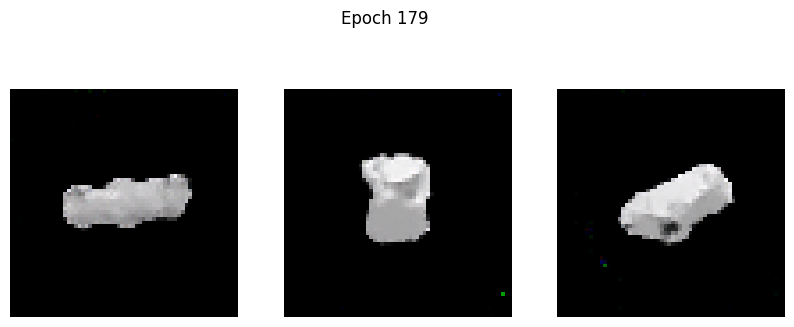

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1070 - g_loss: 3.2893
Epoch 180/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1003 - g_loss: 3.3356

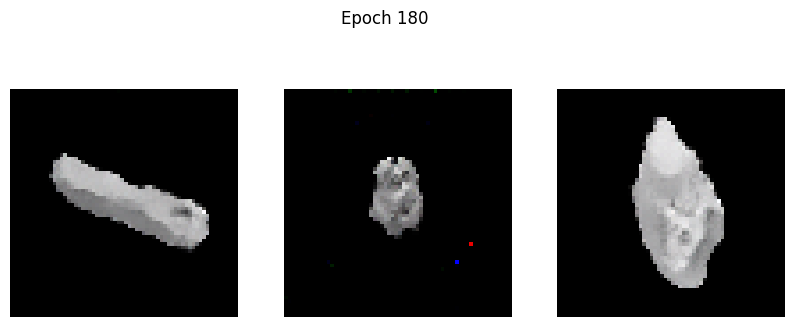

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1003 - g_loss: 3.3357
Epoch 181/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1156 - g_loss: 3.5273

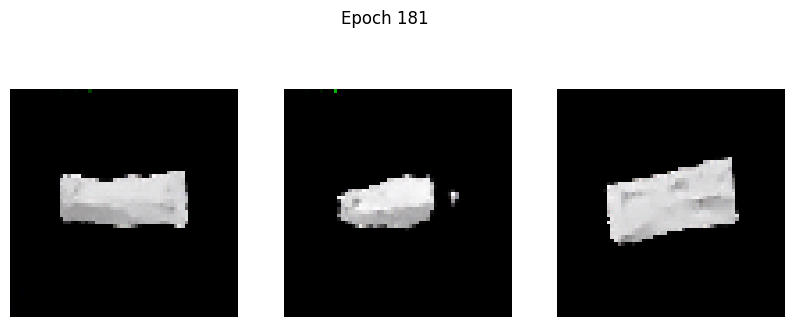

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1156 - g_loss: 3.5267
Epoch 182/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1283 - g_loss: 3.4998

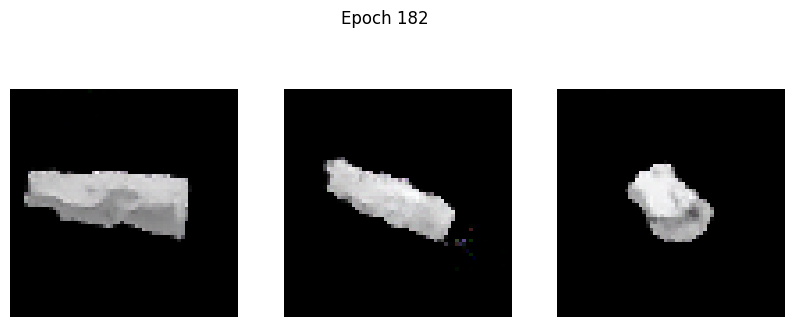

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1285 - g_loss: 3.4995
Epoch 183/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1260 - g_loss: 3.3810

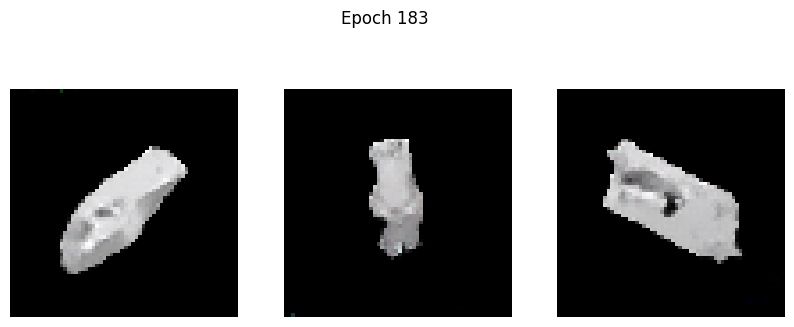

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1259 - g_loss: 3.3813
Epoch 184/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1440 - g_loss: 3.5822

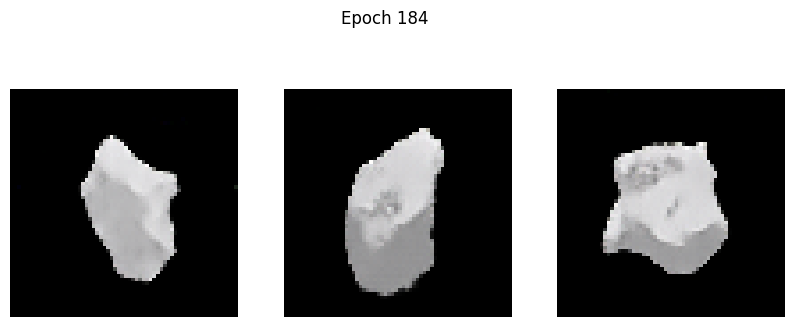

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1443 - g_loss: 3.5821
Epoch 185/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1328 - g_loss: 3.4635

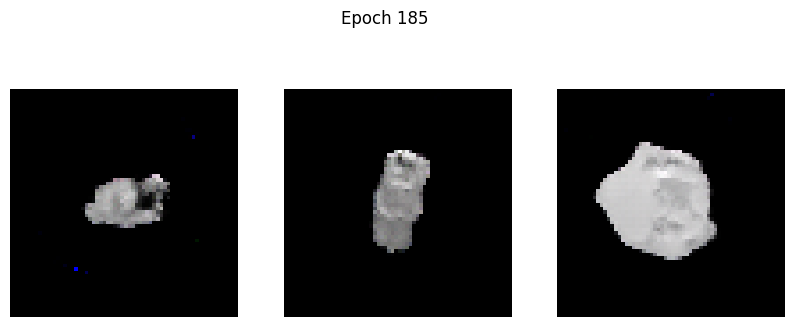

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1333 - g_loss: 3.4639
Epoch 186/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1773 - g_loss: 3.4891

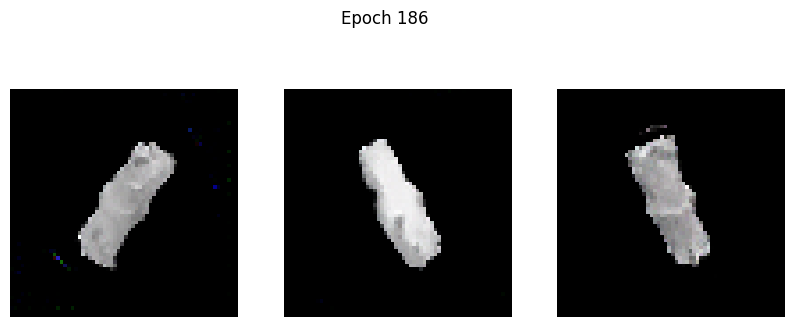

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1769 - g_loss: 3.4879
Epoch 187/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0893 - g_loss: 3.4015

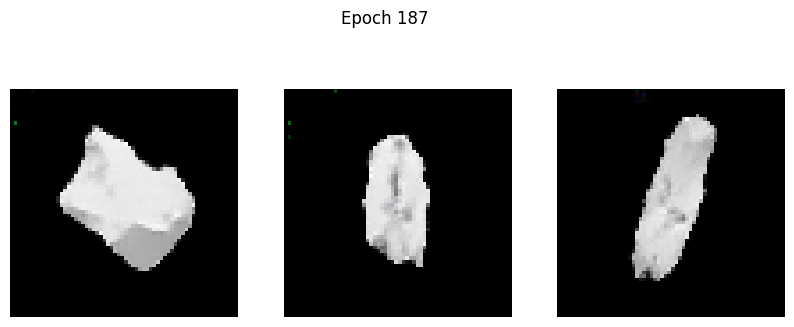

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0894 - g_loss: 3.4019
Epoch 188/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1951 - g_loss: 3.5992

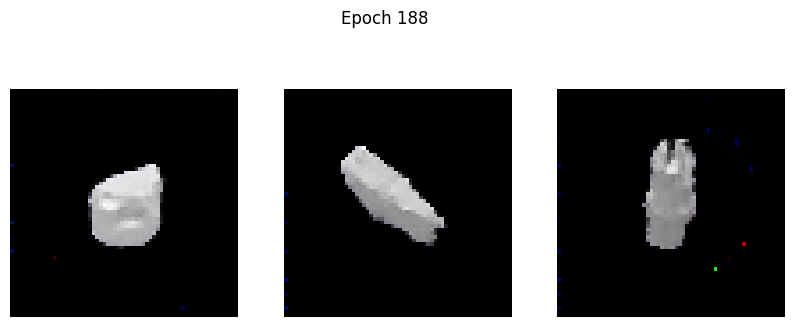

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1948 - g_loss: 3.5986
Epoch 189/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1375 - g_loss: 3.3485

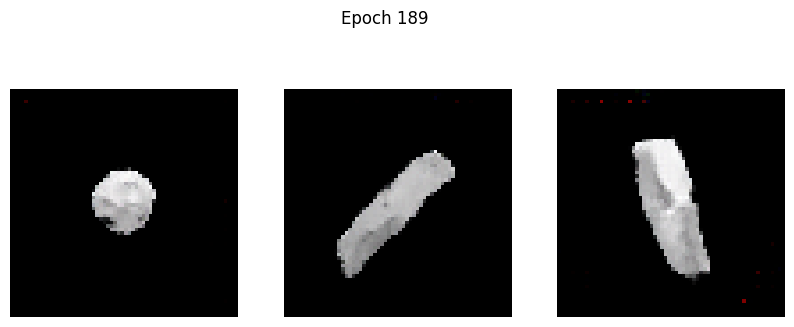

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1373 - g_loss: 3.3492
Epoch 190/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.4834 - g_loss: 4.0485

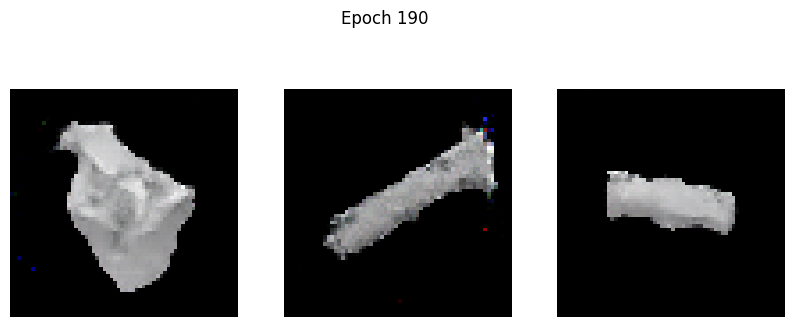

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.4841 - g_loss: 4.0469
Epoch 191/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1396 - g_loss: 3.1702

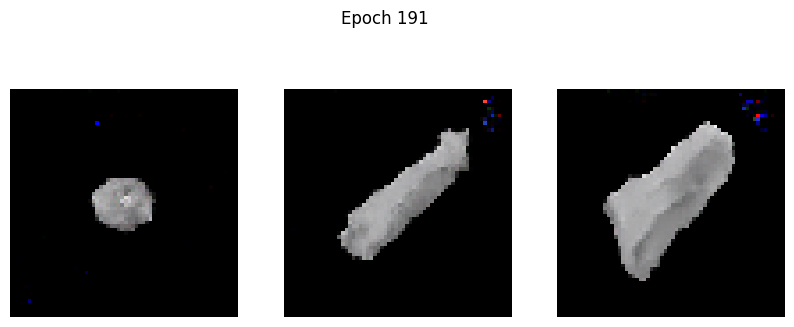

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1395 - g_loss: 3.1708
Epoch 192/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1071 - g_loss: 3.3063

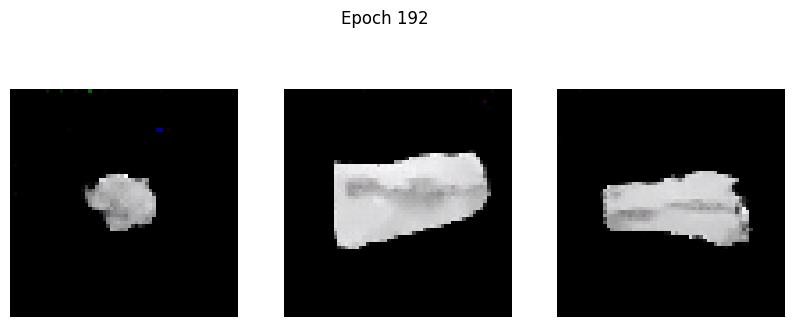

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1072 - g_loss: 3.3062
Epoch 193/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0980 - g_loss: 3.3557

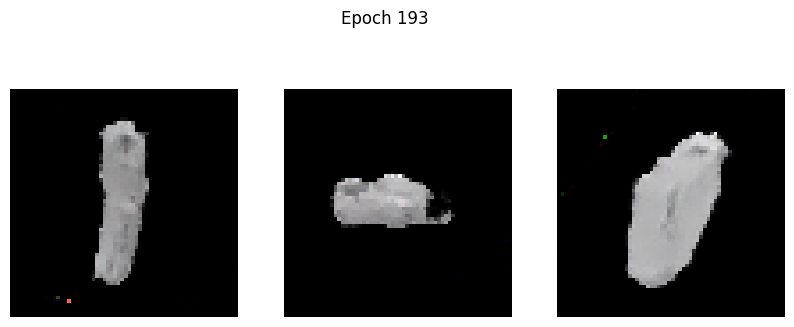

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0980 - g_loss: 3.3554
Epoch 194/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0991 - g_loss: 3.4530

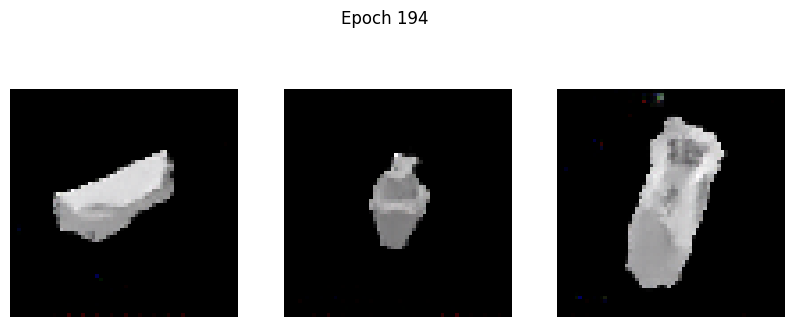

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0992 - g_loss: 3.4528
Epoch 195/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0908 - g_loss: 3.4542

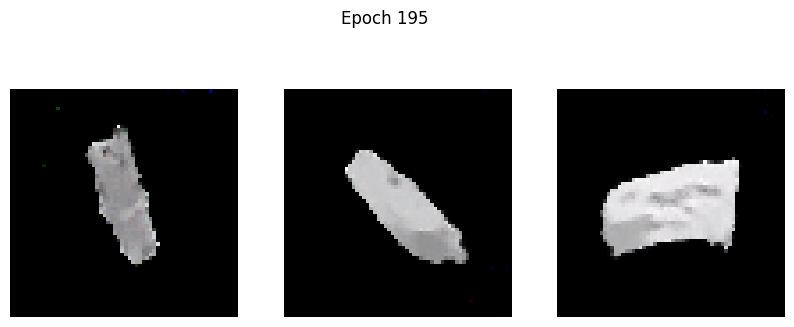

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0908 - g_loss: 3.4543
Epoch 196/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1004 - g_loss: 3.3554

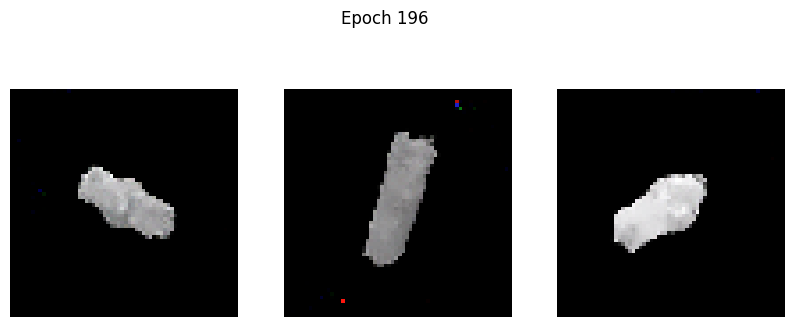

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1004 - g_loss: 3.3569
Epoch 197/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1128 - g_loss: 3.5738

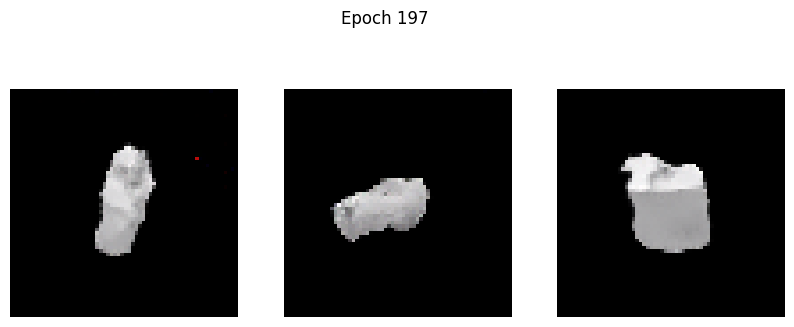

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1129 - g_loss: 3.5737
Epoch 198/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1742 - g_loss: 3.7172

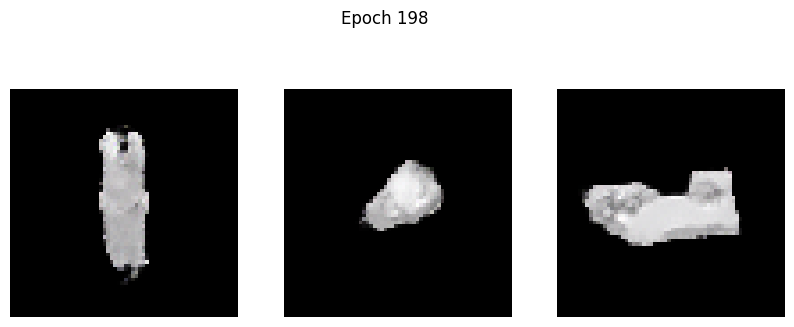

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1747 - g_loss: 3.7191
Epoch 199/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1253 - g_loss: 3.3715

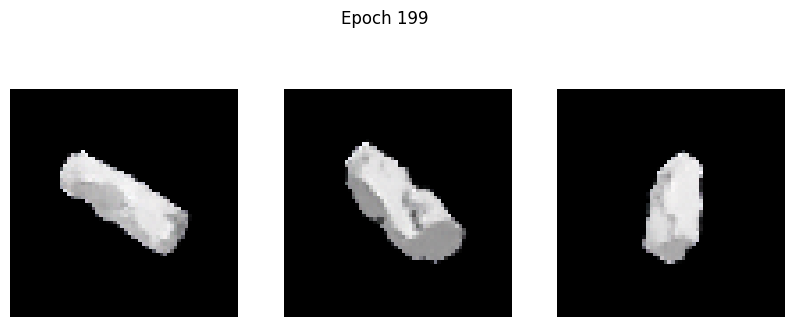

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1252 - g_loss: 3.3719
Epoch 200/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1388 - g_loss: 3.4543

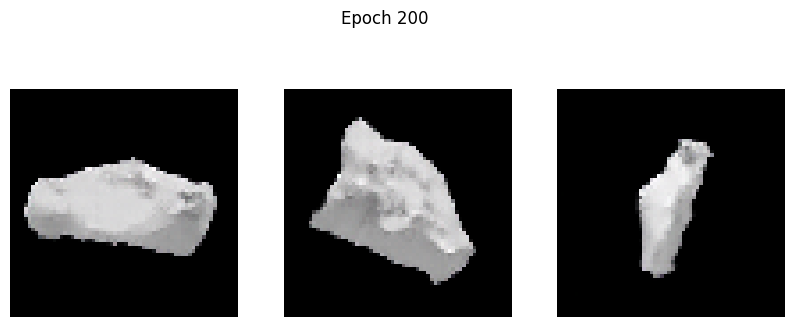

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1387 - g_loss: 3.4546
Epoch 201/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0870 - g_loss: 3.4423

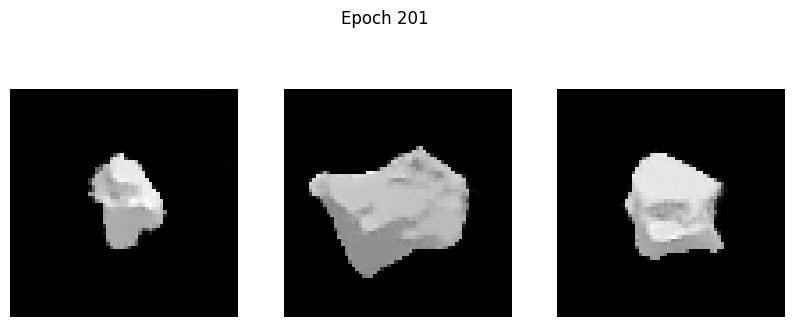

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0871 - g_loss: 3.4427
Epoch 202/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1879 - g_loss: 3.6654

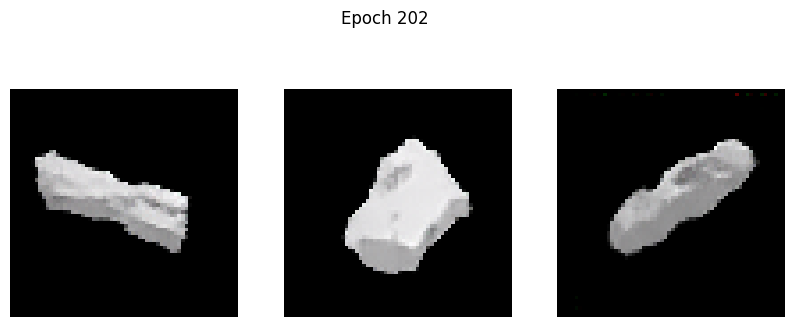

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1877 - g_loss: 3.6647
Epoch 203/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2548 - g_loss: 3.8287

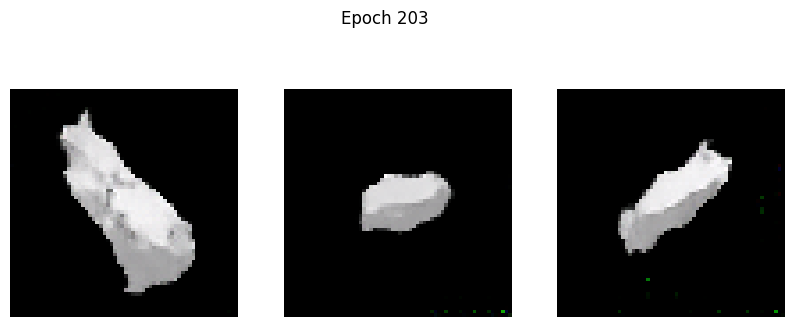

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2538 - g_loss: 3.8266
Epoch 204/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0936 - g_loss: 3.5669

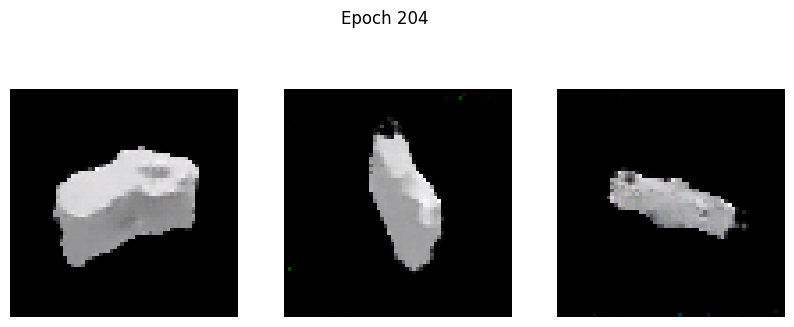

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0935 - g_loss: 3.5664
Epoch 205/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1115 - g_loss: 3.6559

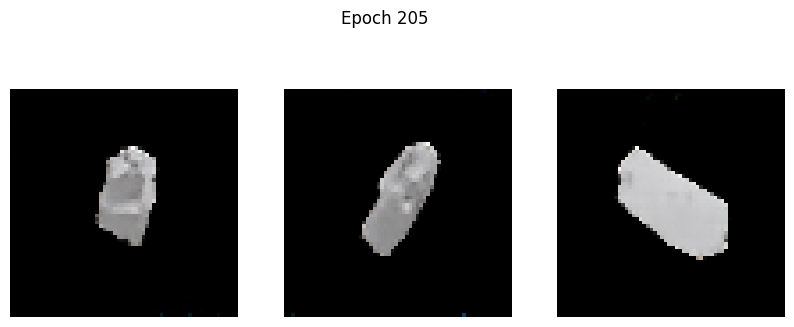

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1121 - g_loss: 3.6558
Epoch 206/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2149 - g_loss: 3.5593

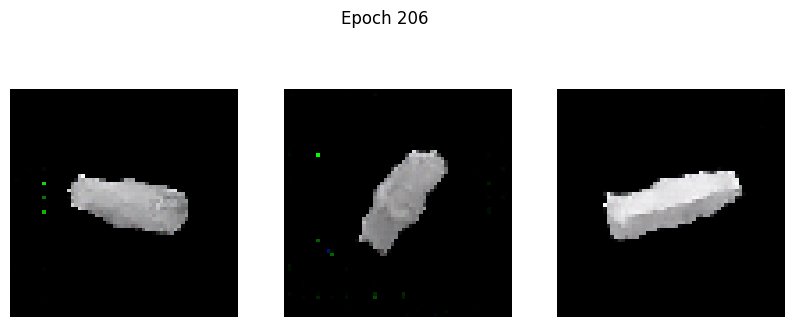

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2141 - g_loss: 3.5583
Epoch 207/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1618 - g_loss: 3.6472

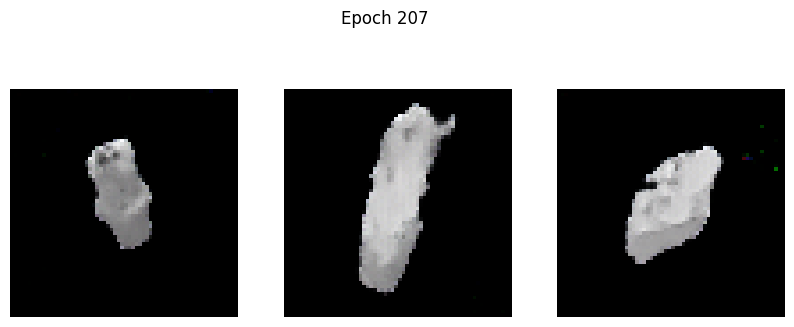

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1644 - g_loss: 3.6501
Epoch 208/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1489 - g_loss: 3.2744

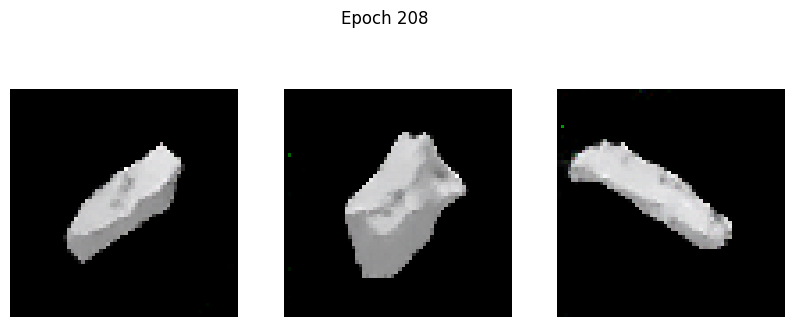

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1487 - g_loss: 3.2746
Epoch 209/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1007 - g_loss: 3.4156

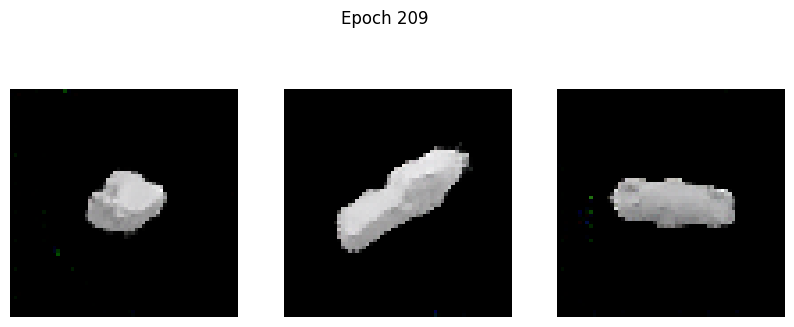

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1007 - g_loss: 3.4154
Epoch 210/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0832 - g_loss: 3.4733

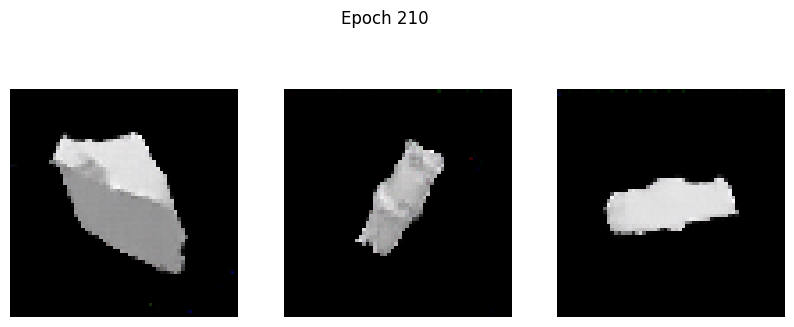

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0832 - g_loss: 3.4734
Epoch 211/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0809 - g_loss: 3.5747

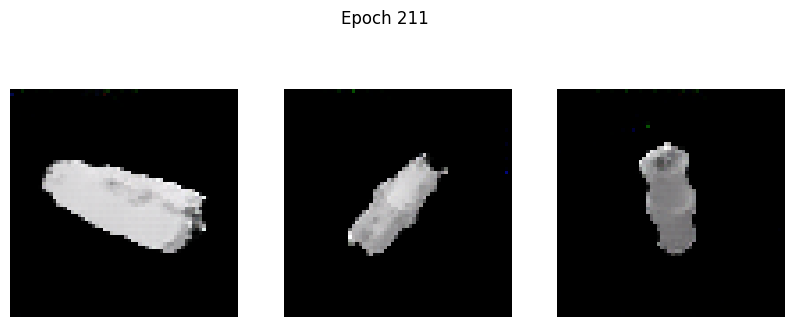

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0809 - g_loss: 3.5746
Epoch 212/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0959 - g_loss: 3.6063

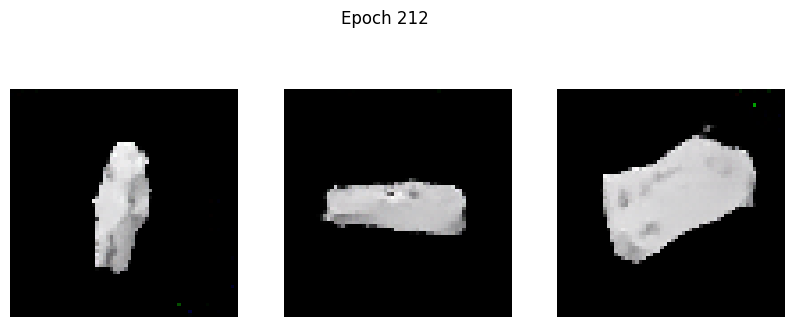

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0959 - g_loss: 3.6064
Epoch 213/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1028 - g_loss: 3.6781

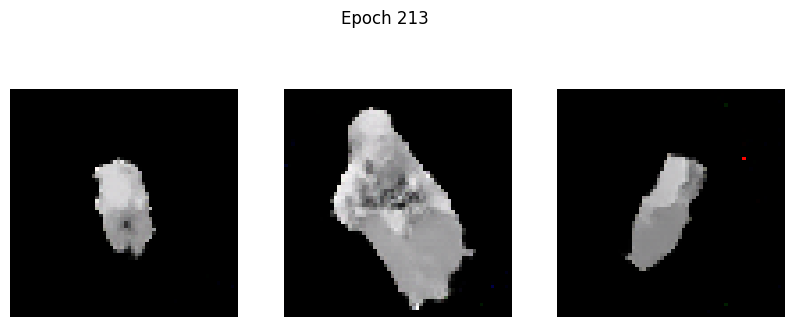

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1028 - g_loss: 3.6776
Epoch 214/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.1090 - g_loss: 3.6054

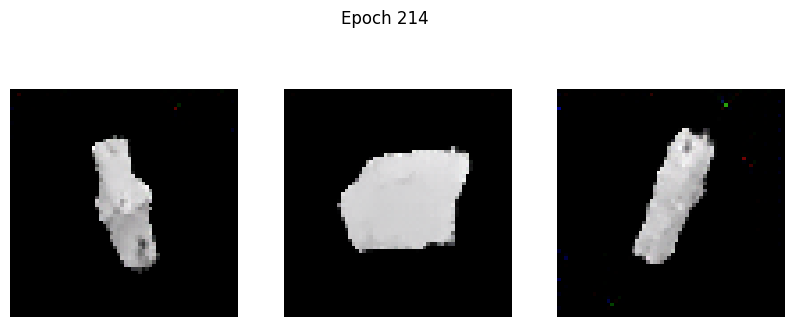

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.1090 - g_loss: 3.6056
Epoch 215/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1889 - g_loss: 3.8921

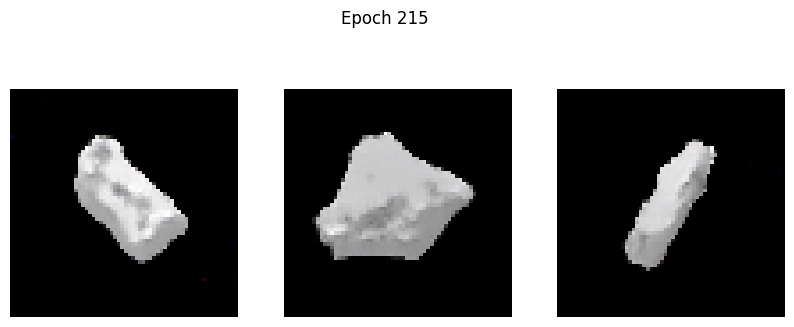

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1884 - g_loss: 3.8911
Epoch 216/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1230 - g_loss: 3.7749

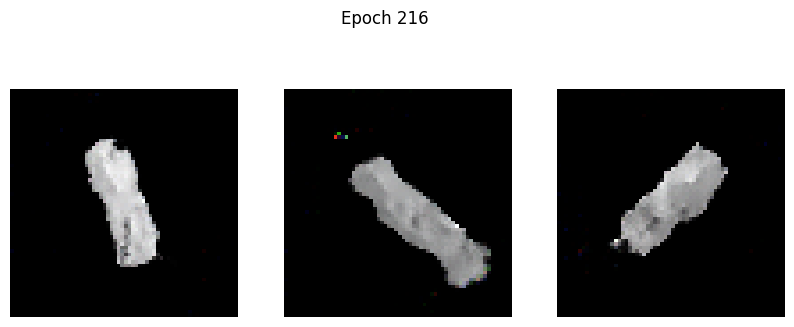

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1238 - g_loss: 3.7754
Epoch 217/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1483 - g_loss: 3.5530

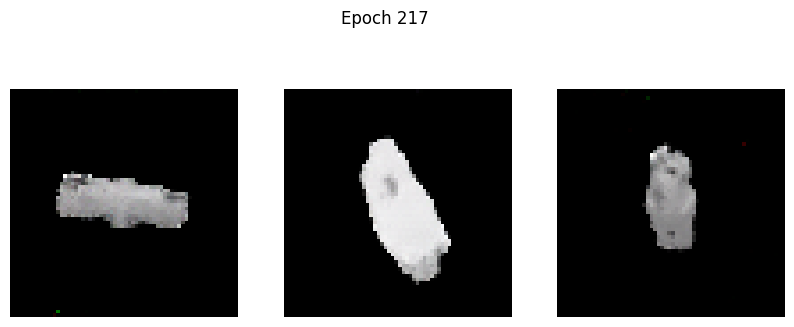

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1479 - g_loss: 3.5533
Epoch 218/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0879 - g_loss: 3.6936

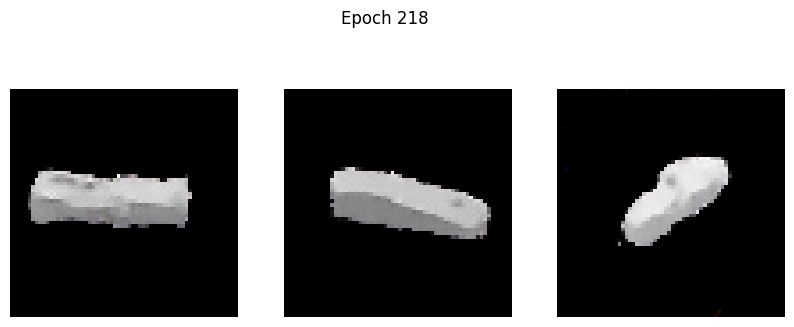

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0884 - g_loss: 3.6945
Epoch 219/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2018 - g_loss: 3.7129

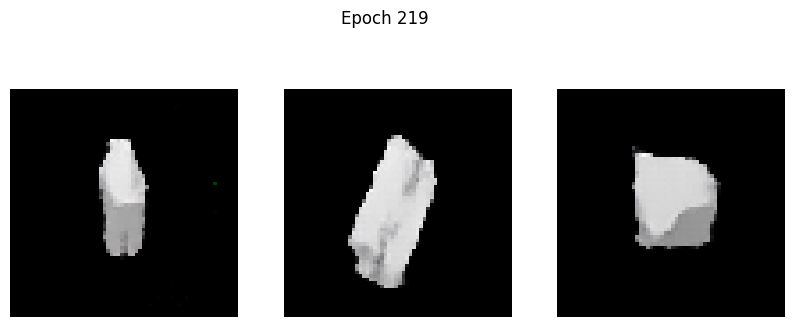

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2016 - g_loss: 3.7128
Epoch 220/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0750 - g_loss: 3.6119

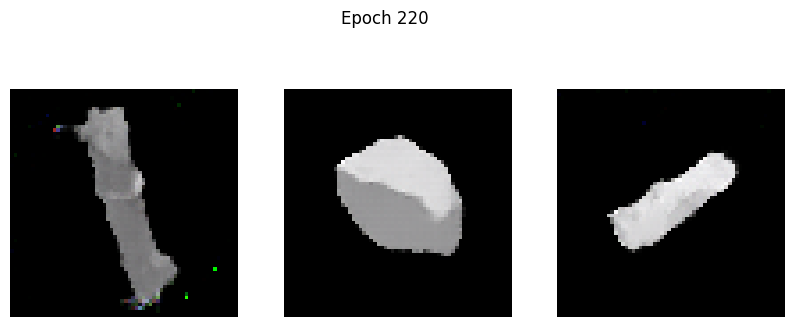

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0751 - g_loss: 3.6118
Epoch 221/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0759 - g_loss: 3.5293

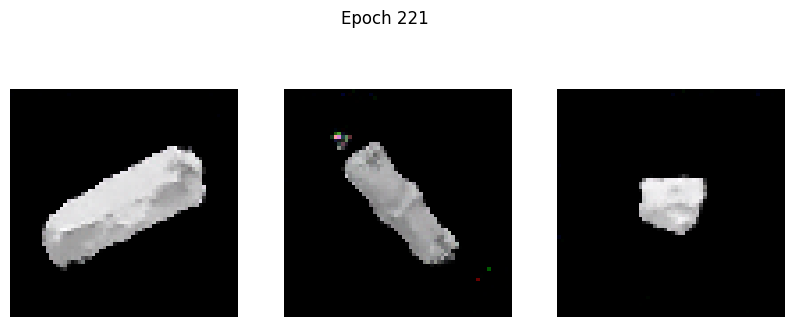

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0759 - g_loss: 3.5307
Epoch 222/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0781 - g_loss: 3.7332

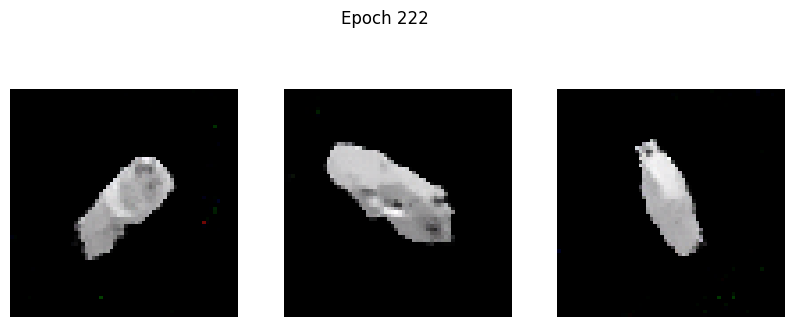

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0781 - g_loss: 3.7330
Epoch 223/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0856 - g_loss: 3.6998

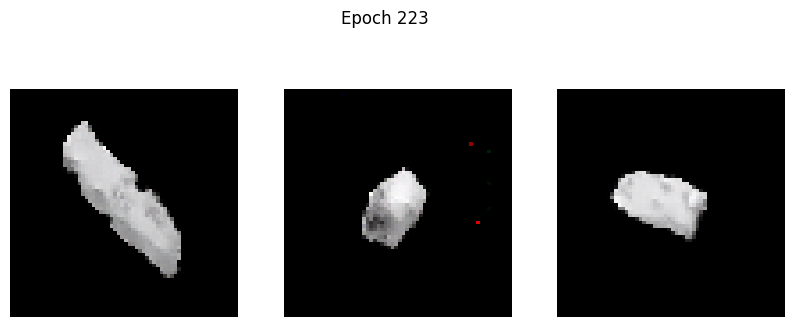

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0860 - g_loss: 3.7006
Epoch 224/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0799 - g_loss: 3.7086

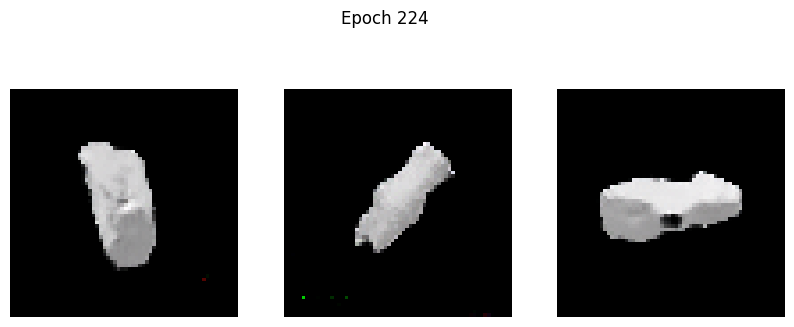

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0799 - g_loss: 3.7087
Epoch 225/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 1.4399 - g_loss: 7.2265

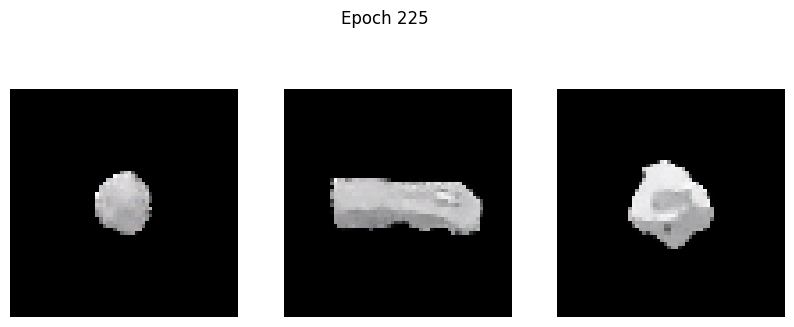

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 1.4333 - g_loss: 7.2054
Epoch 226/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1227 - g_loss: 3.3320

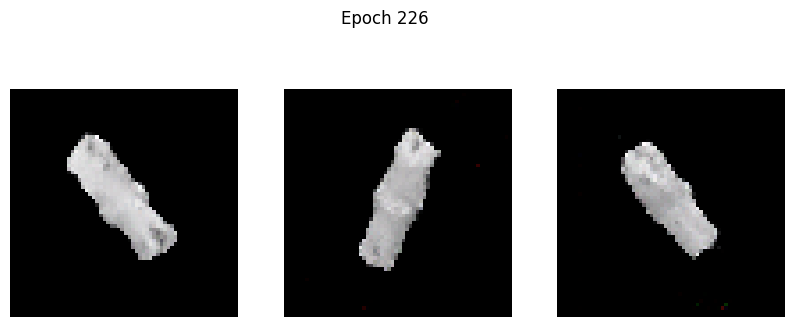

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1226 - g_loss: 3.3322
Epoch 227/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1044 - g_loss: 3.5068

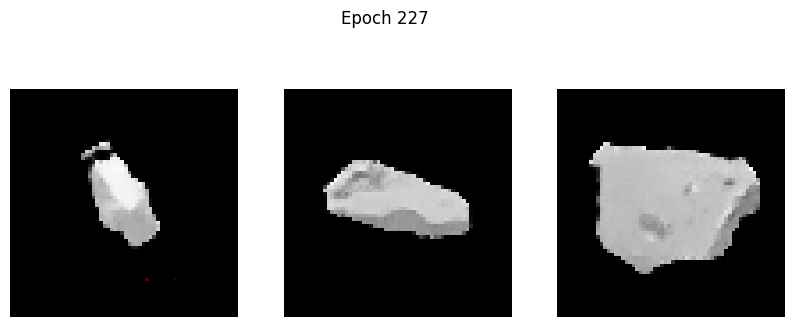

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1043 - g_loss: 3.5066
Epoch 228/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1057 - g_loss: 3.5982

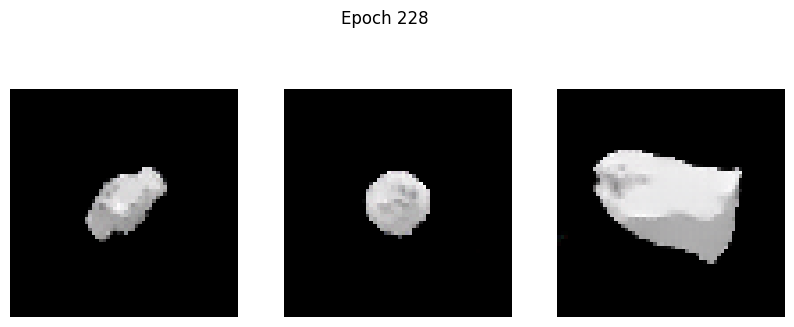

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1056 - g_loss: 3.5979
Epoch 229/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0707 - g_loss: 3.5919

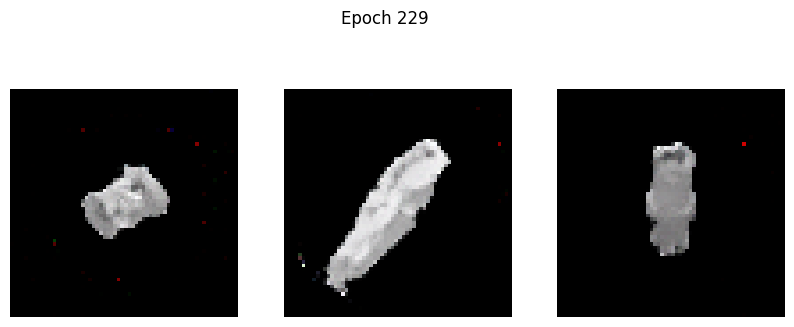

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0709 - g_loss: 3.5926
Epoch 230/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1579 - g_loss: 3.5839

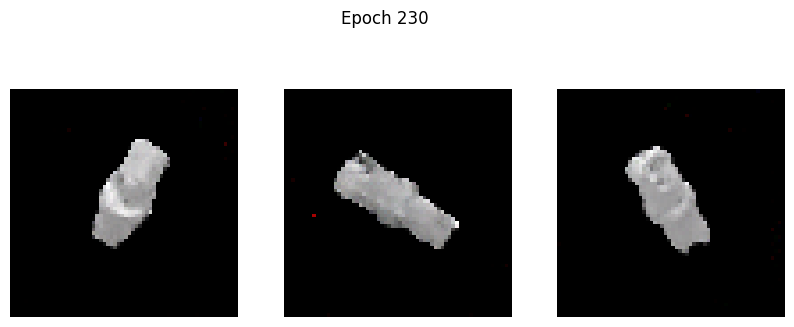

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1576 - g_loss: 3.5841
Epoch 231/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0854 - g_loss: 3.5946

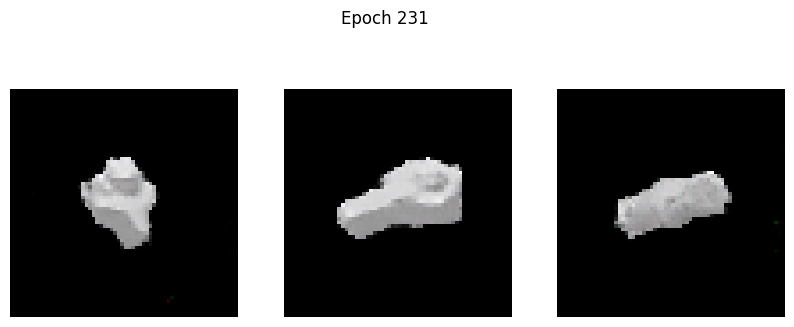

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0854 - g_loss: 3.5948
Epoch 232/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0767 - g_loss: 3.7149

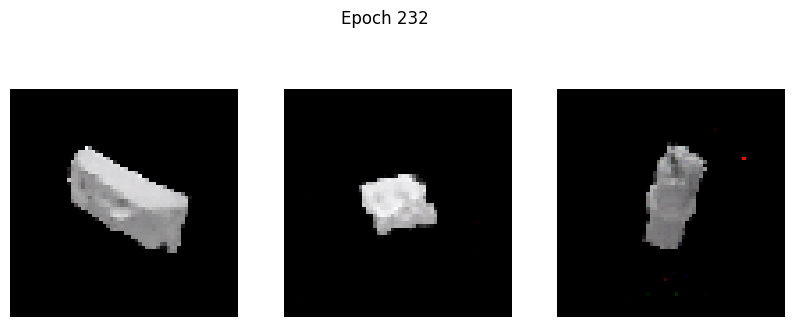

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0767 - g_loss: 3.7147
Epoch 233/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0828 - g_loss: 3.7865

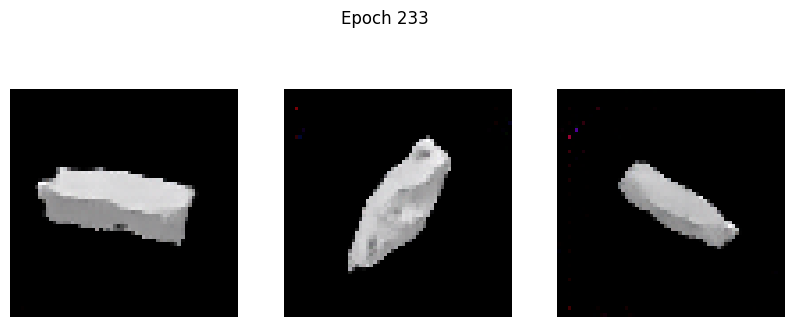

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0832 - g_loss: 3.7864
Epoch 234/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1344 - g_loss: 3.9421

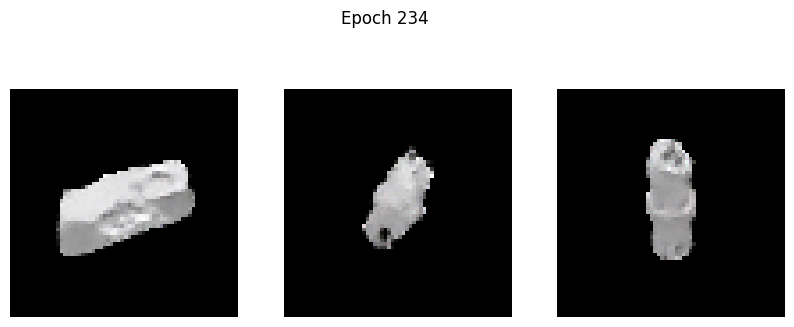

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1342 - g_loss: 3.9411
Epoch 235/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0864 - g_loss: 3.7558

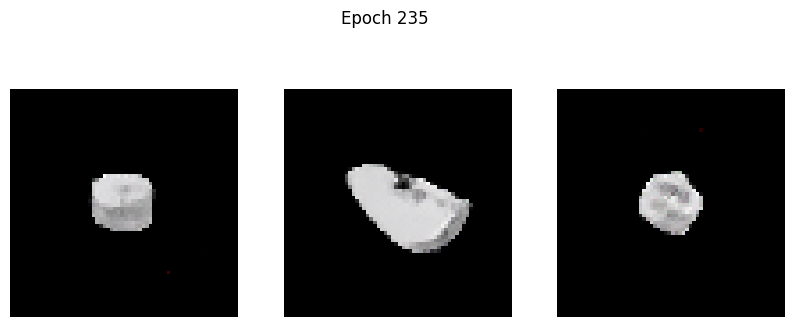

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0866 - g_loss: 3.7566
Epoch 236/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0856 - g_loss: 3.7900

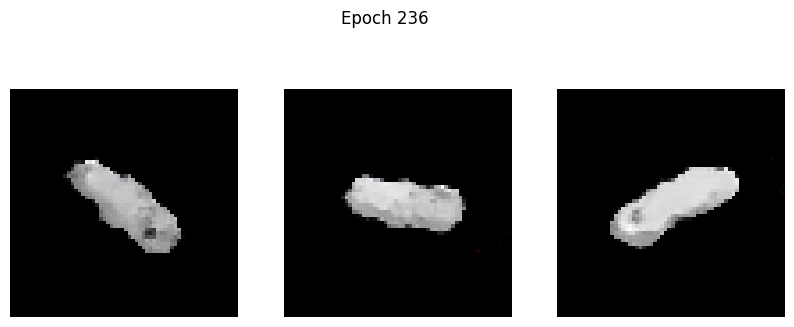

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0857 - g_loss: 3.7899
Epoch 237/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0819 - g_loss: 3.7788

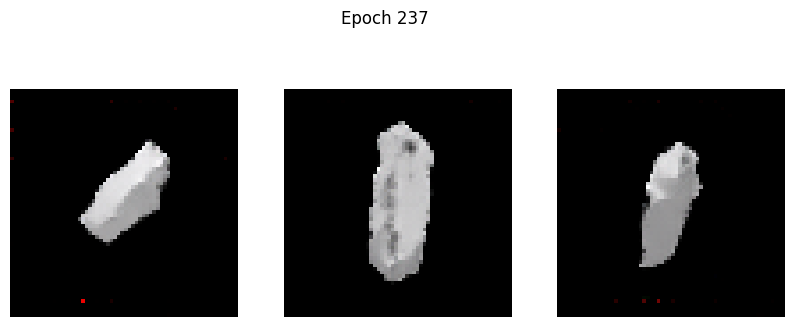

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0821 - g_loss: 3.7793
Epoch 238/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0906 - g_loss: 3.8220

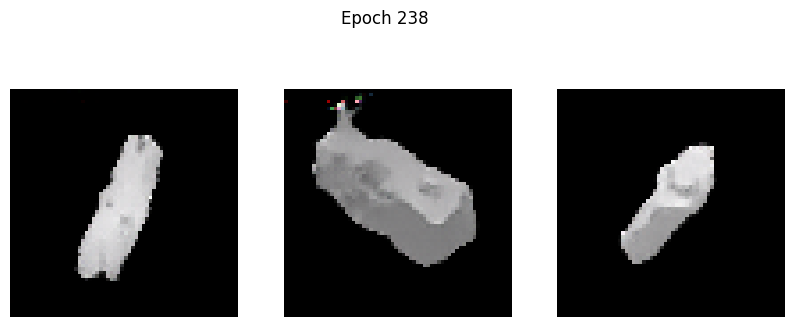

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0908 - g_loss: 3.8229
Epoch 239/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1097 - g_loss: 3.8697

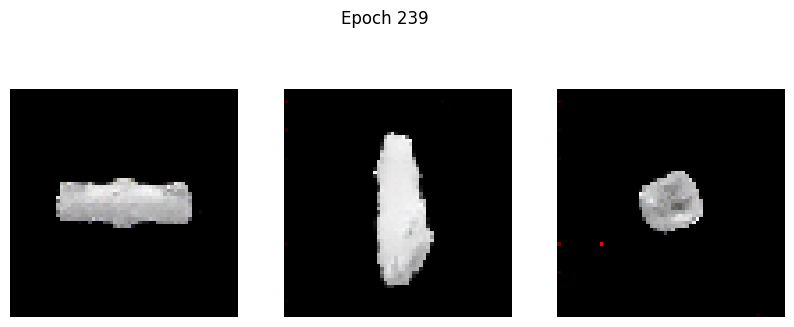

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1097 - g_loss: 3.8695
Epoch 240/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0928 - g_loss: 3.8015

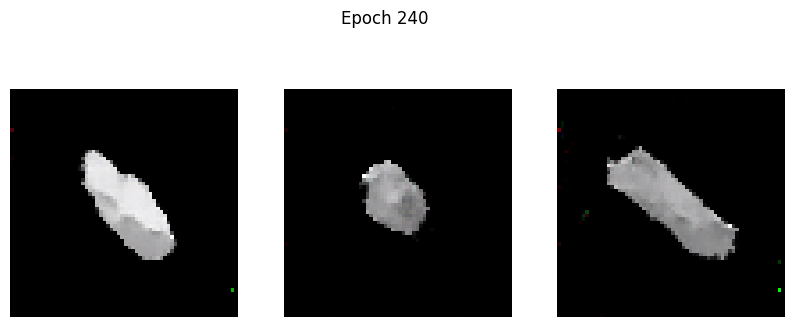

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0929 - g_loss: 3.8019
Epoch 241/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1312 - g_loss: 3.9764

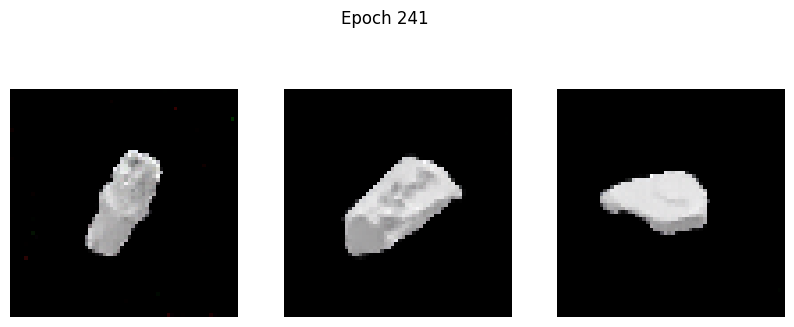

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1312 - g_loss: 3.9761
Epoch 242/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1099 - g_loss: 3.8213

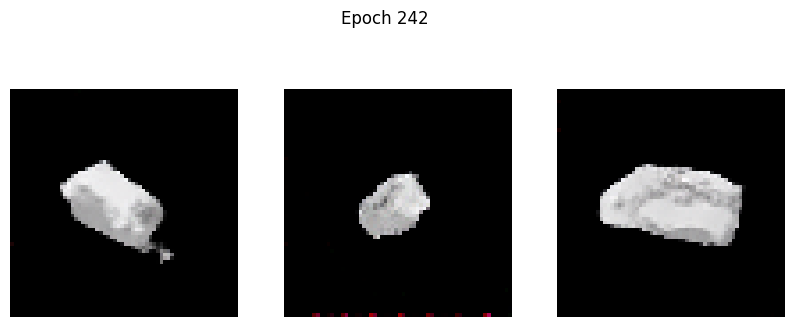

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1098 - g_loss: 3.8214
Epoch 243/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1133 - g_loss: 3.9458

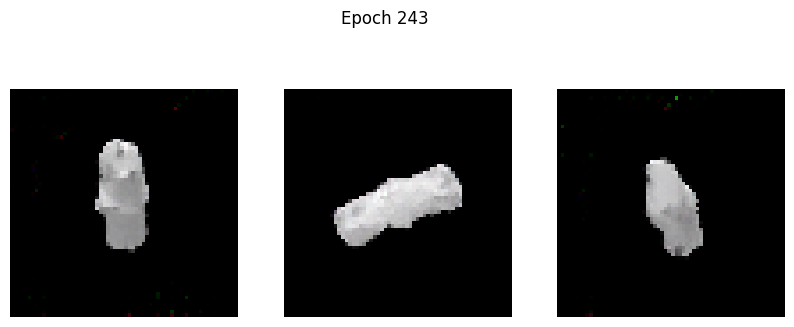

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1137 - g_loss: 3.9460
Epoch 244/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0954 - g_loss: 3.8816

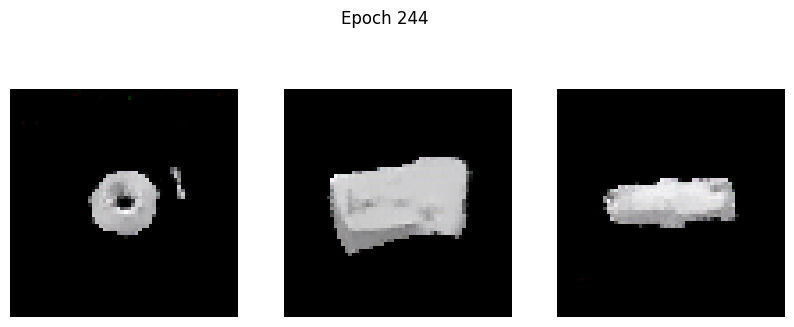

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0954 - g_loss: 3.8817
Epoch 245/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0837 - g_loss: 3.7453

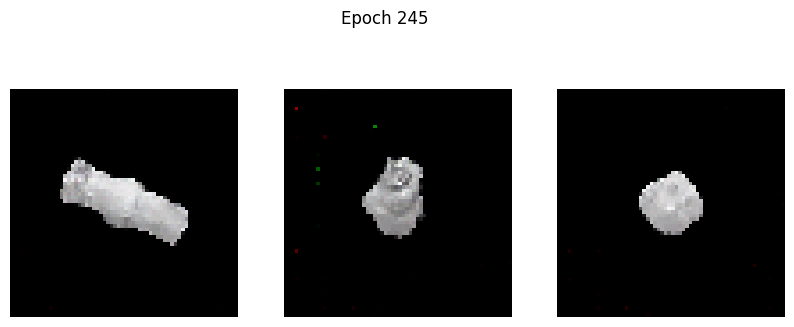

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0837 - g_loss: 3.7464
Epoch 246/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0699 - g_loss: 3.9262

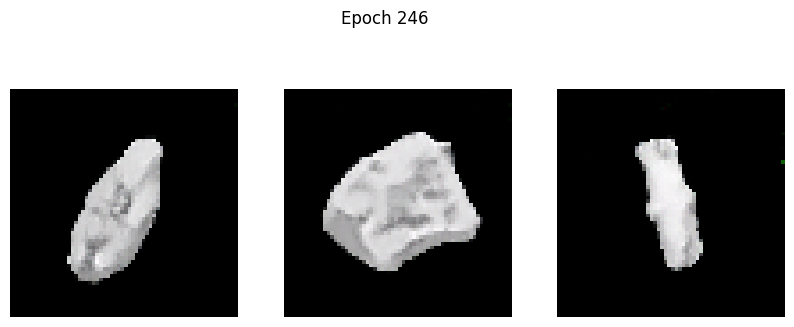

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0700 - g_loss: 3.9264
Epoch 247/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0834 - g_loss: 3.9728

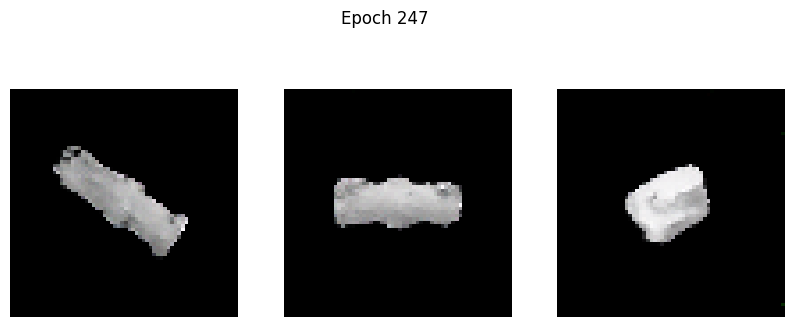

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0836 - g_loss: 3.9731
Epoch 248/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0908 - g_loss: 4.0195

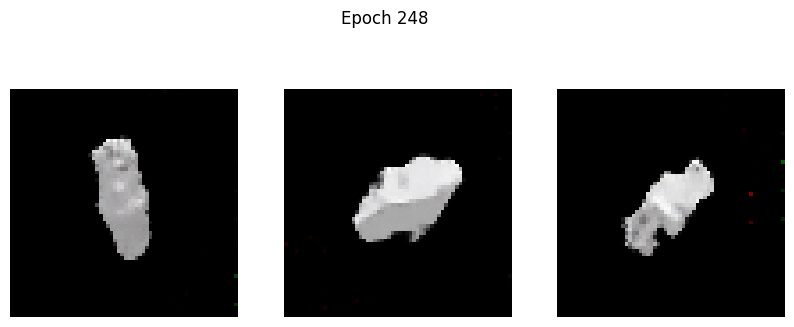

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0908 - g_loss: 4.0191
Epoch 249/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1845 - g_loss: 4.0941

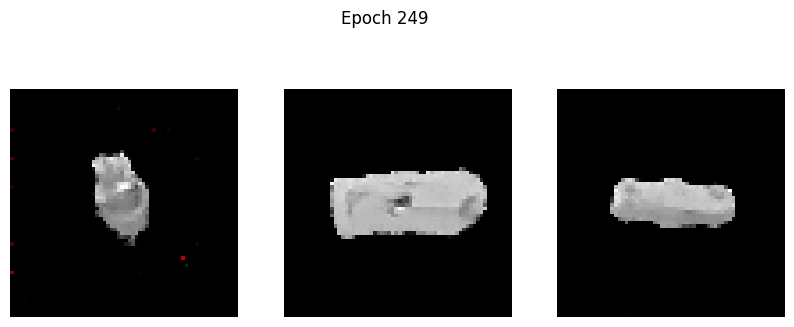

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1852 - g_loss: 4.0939
Epoch 250/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0884 - g_loss: 3.8716

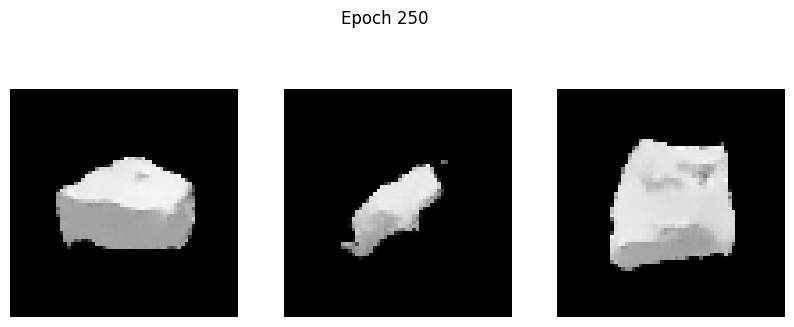

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0885 - g_loss: 3.8712
Epoch 251/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1250 - g_loss: 3.8452

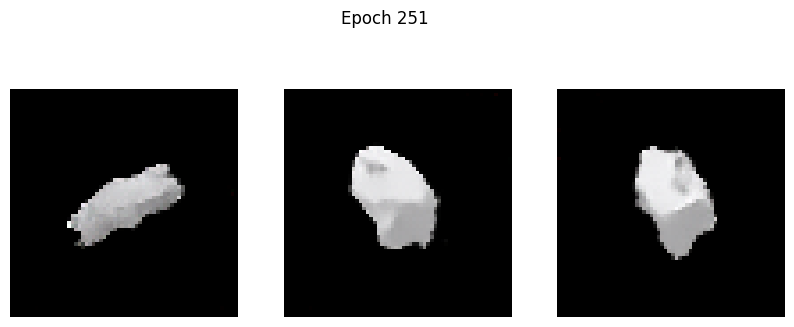

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1250 - g_loss: 3.8461
Epoch 252/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0949 - g_loss: 3.9781

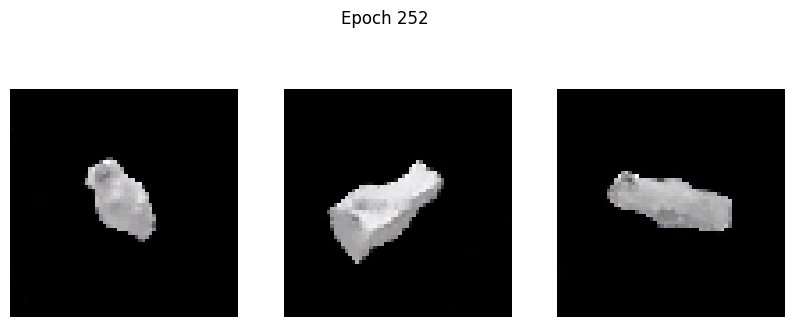

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0947 - g_loss: 3.9777
Epoch 253/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0729 - g_loss: 3.8571

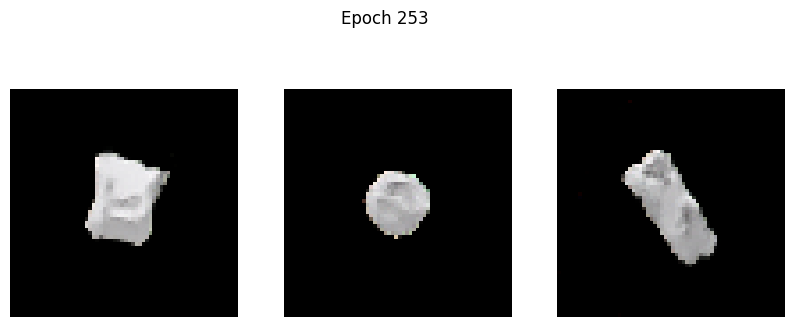

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0732 - g_loss: 3.8574
Epoch 254/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1055 - g_loss: 4.0749

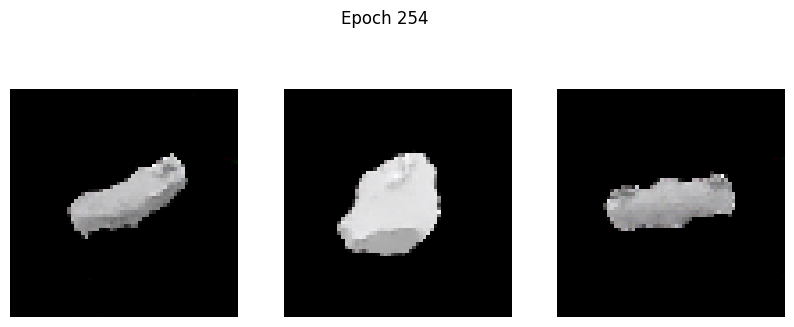

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1053 - g_loss: 4.0740
Epoch 255/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0707 - g_loss: 3.9699

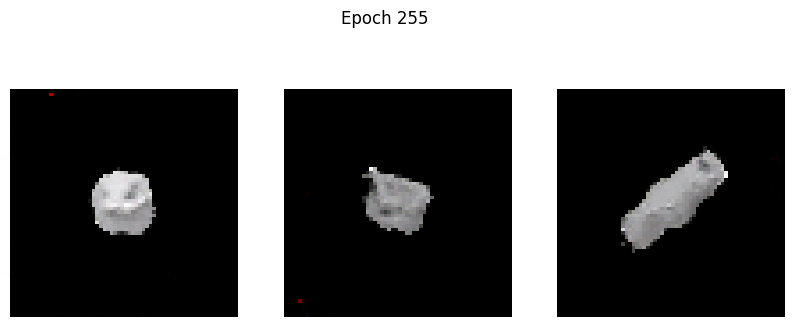

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0707 - g_loss: 3.9697
Epoch 256/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0781 - g_loss: 4.0019

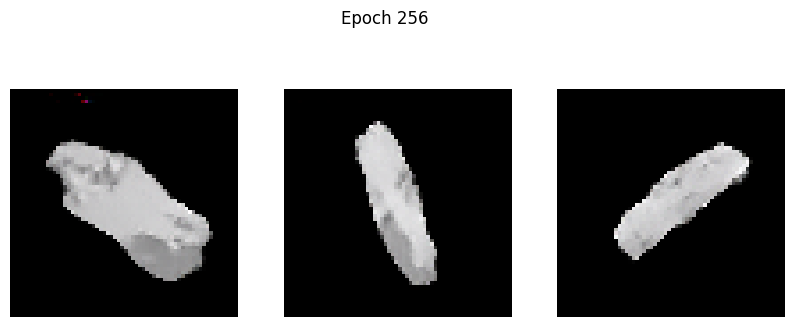

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0781 - g_loss: 4.0016
Epoch 257/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0945 - g_loss: 4.1353

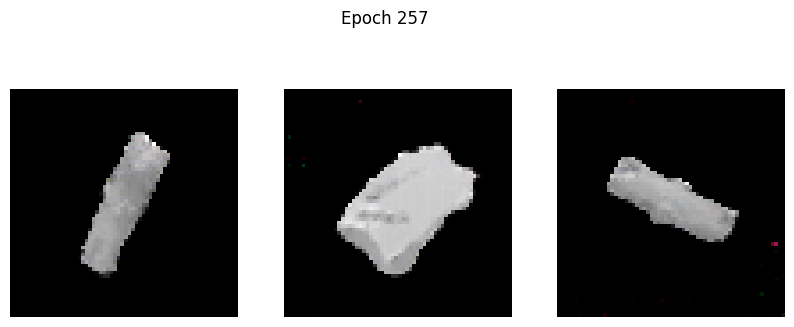

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0953 - g_loss: 4.1354
Epoch 258/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1181 - g_loss: 3.8498

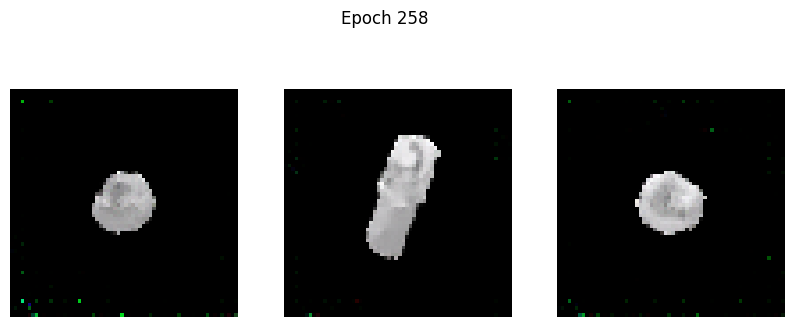

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1177 - g_loss: 3.8498
Epoch 259/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0925 - g_loss: 4.1257

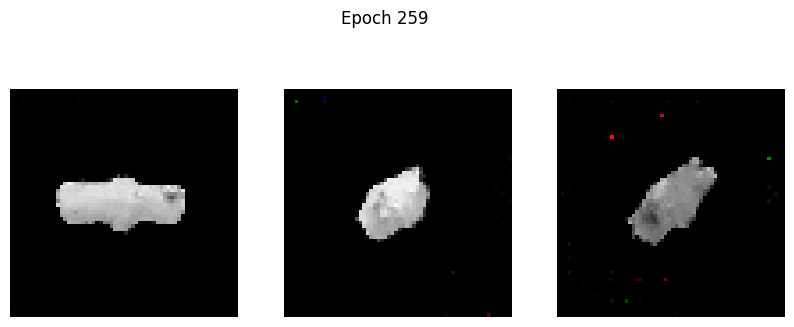

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0929 - g_loss: 4.1261
Epoch 260/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0628 - g_loss: 3.9915

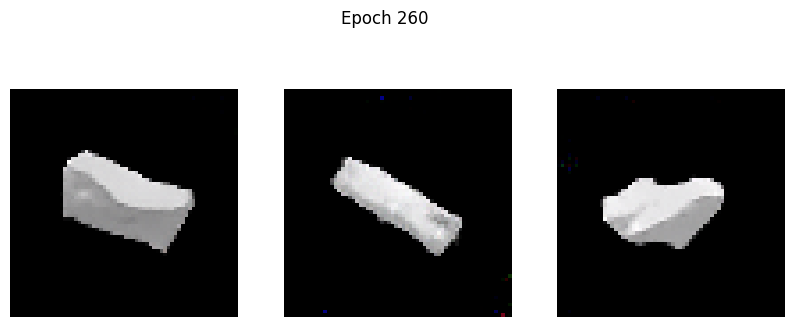

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0628 - g_loss: 3.9908
Epoch 261/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0869 - g_loss: 4.0388

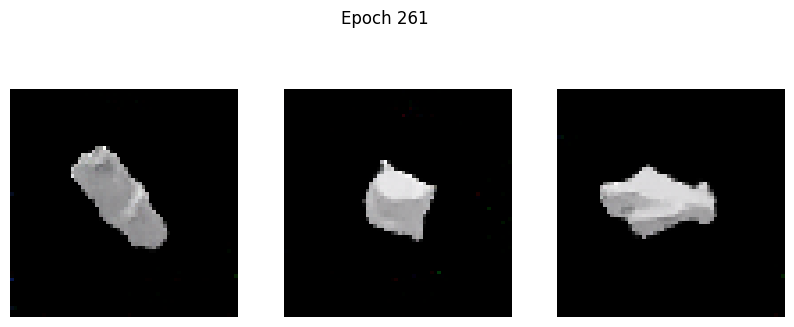

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0870 - g_loss: 4.0388
Epoch 262/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0459 - g_loss: 4.0015

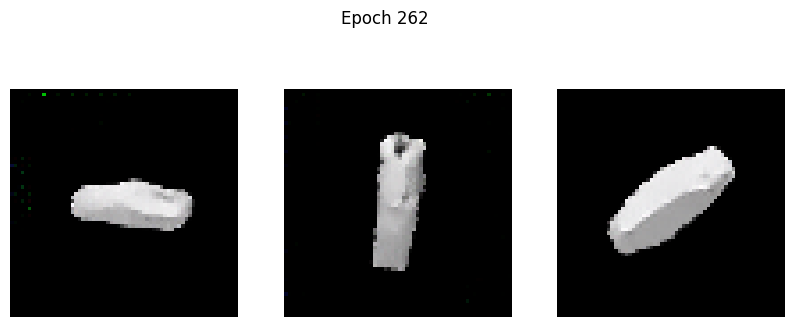

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0460 - g_loss: 4.0024
Epoch 263/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1401 - g_loss: 4.1636

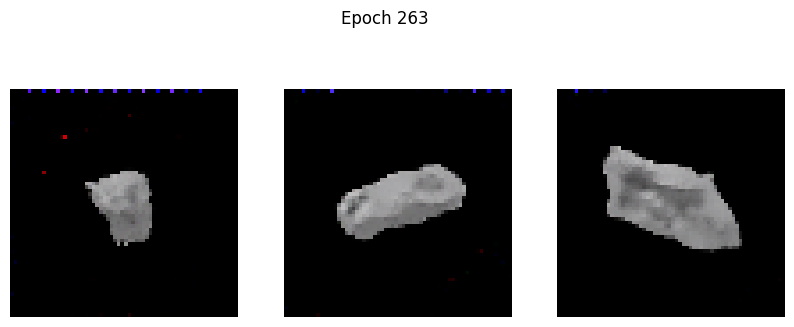

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1405 - g_loss: 4.1628
Epoch 264/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0682 - g_loss: 4.1055

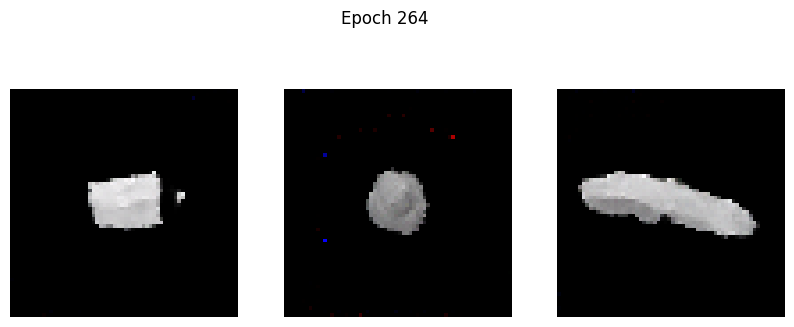

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0682 - g_loss: 4.1043
Epoch 265/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1353 - g_loss: 4.2454

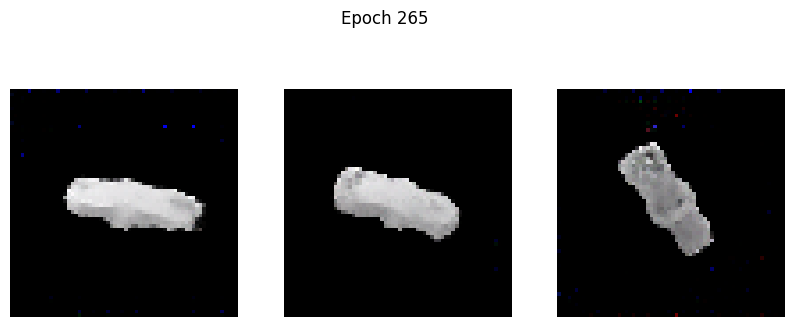

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1352 - g_loss: 4.2450
Epoch 266/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0487 - g_loss: 3.9369

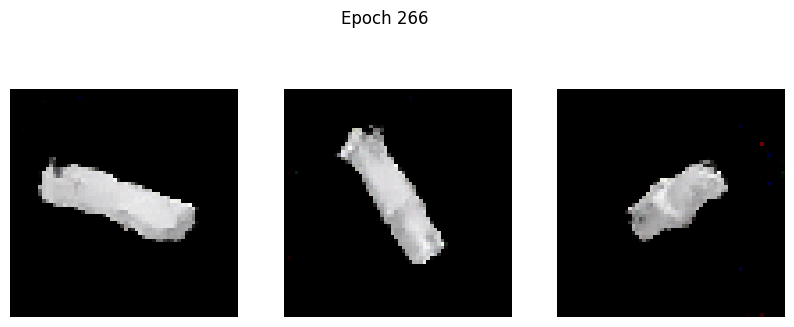

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0488 - g_loss: 3.9378
Epoch 267/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0730 - g_loss: 4.0319

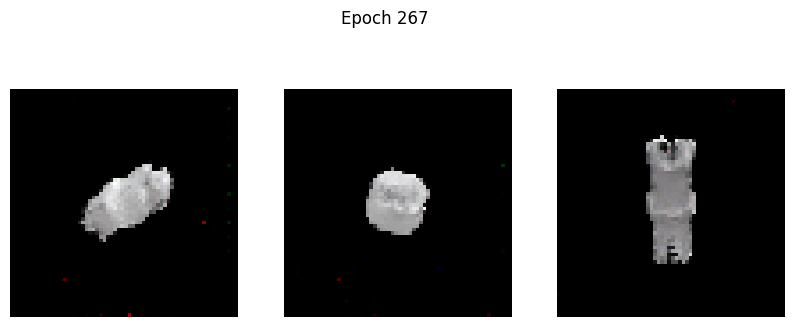

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0730 - g_loss: 4.0324
Epoch 268/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0961 - g_loss: 4.1988

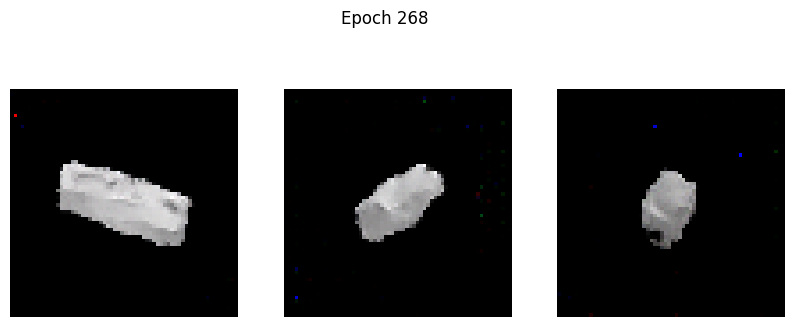

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0962 - g_loss: 4.1990
Epoch 269/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0548 - g_loss: 4.0767

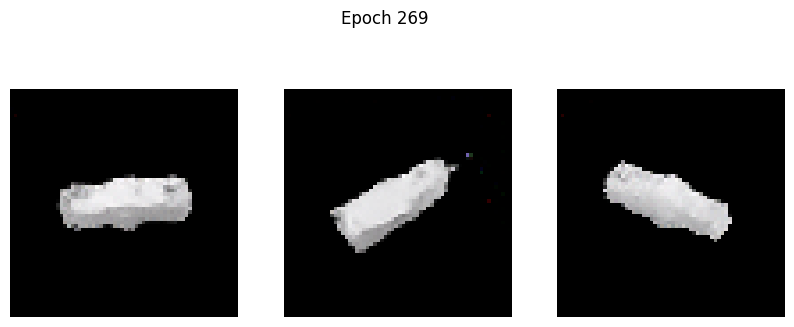

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0550 - g_loss: 4.0772
Epoch 270/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0870 - g_loss: 4.1011

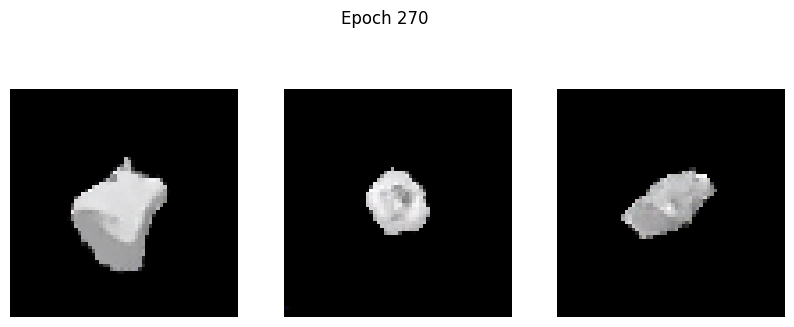

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0880 - g_loss: 4.1026
Epoch 271/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0726 - g_loss: 4.0949

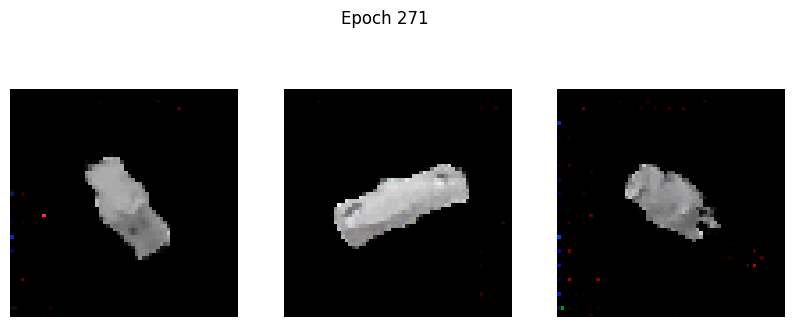

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0732 - g_loss: 4.0960
Epoch 272/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0756 - g_loss: 4.0246

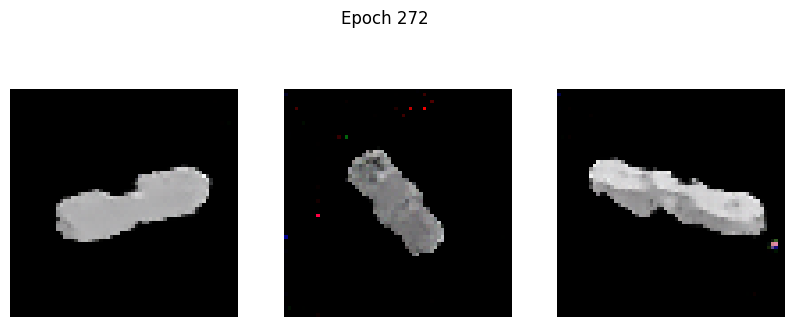

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0755 - g_loss: 4.0247
Epoch 273/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0513 - g_loss: 4.0612

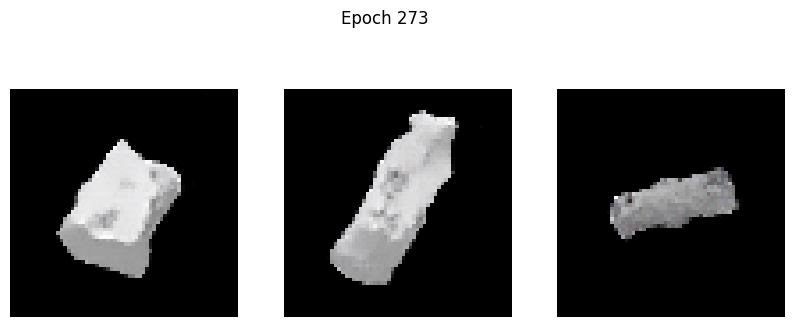

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0512 - g_loss: 4.0609
Epoch 274/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0681 - g_loss: 4.1795

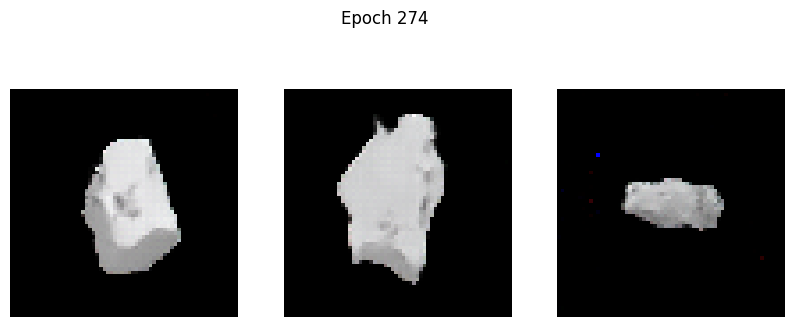

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0690 - g_loss: 4.1810
Epoch 275/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1359 - g_loss: 4.2814

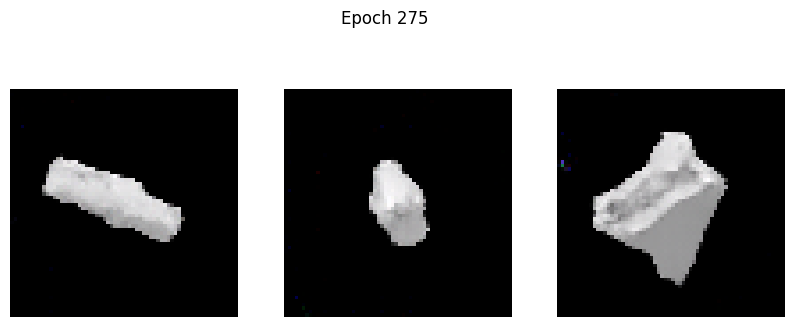

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.1354 - g_loss: 4.2803
Epoch 276/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0558 - g_loss: 4.1934

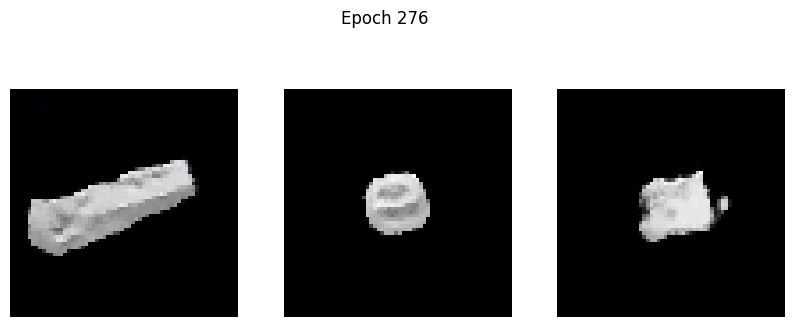

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0558 - g_loss: 4.1923
Epoch 277/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0399 - g_loss: 4.0773

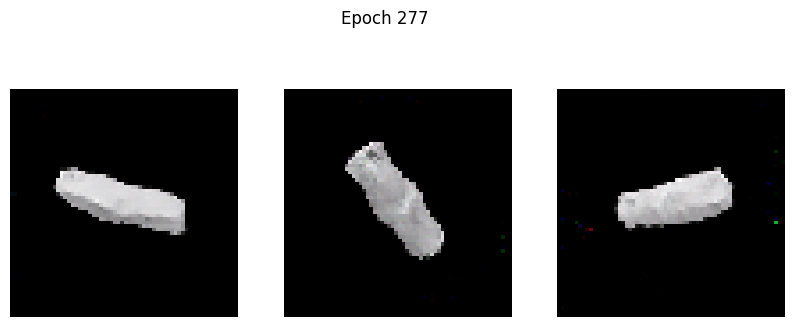

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0400 - g_loss: 4.0783
Epoch 278/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0429 - g_loss: 4.1155

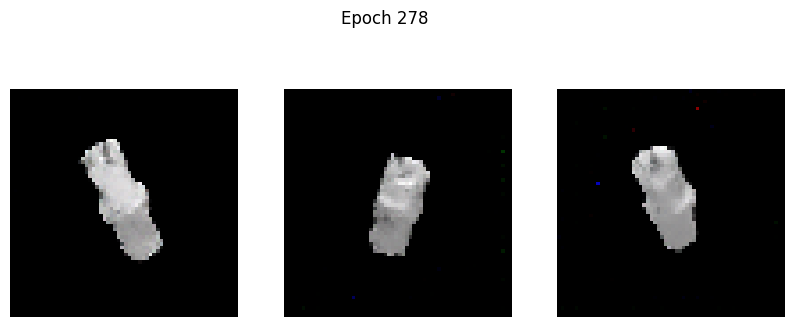

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0432 - g_loss: 4.1161
Epoch 279/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0924 - g_loss: 4.2583

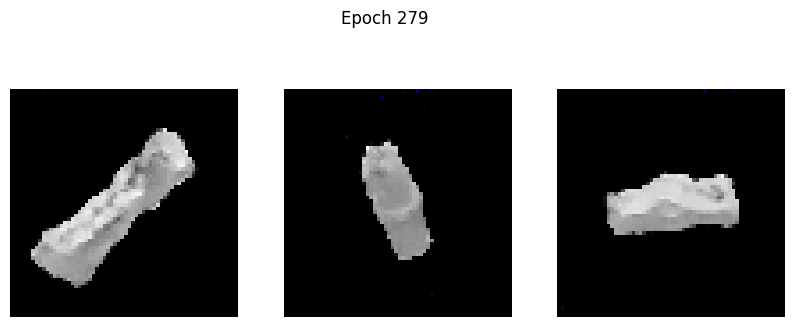

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0922 - g_loss: 4.2579
Epoch 280/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0763 - g_loss: 4.3794

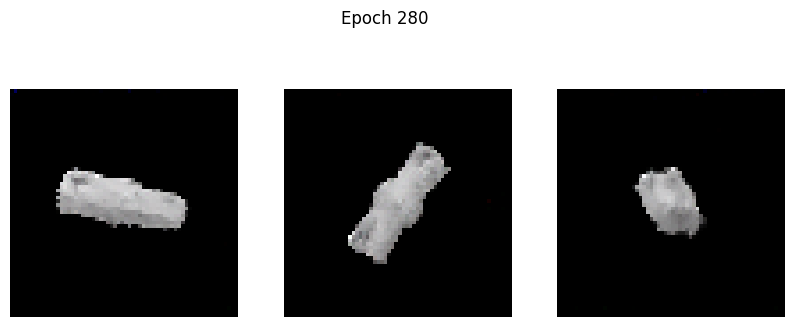

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0764 - g_loss: 4.3786
Epoch 281/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0719 - g_loss: 4.3593

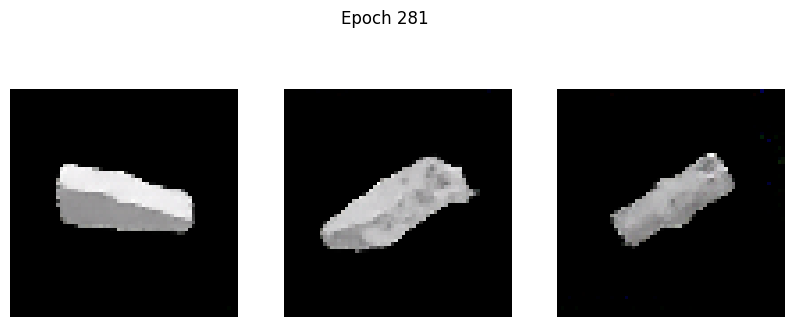

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0719 - g_loss: 4.3590
Epoch 282/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0456 - g_loss: 4.2374

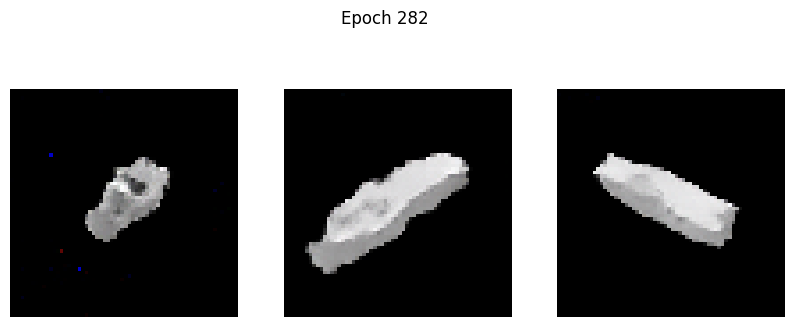

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0456 - g_loss: 4.2376
Epoch 283/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1131 - g_loss: 4.4596

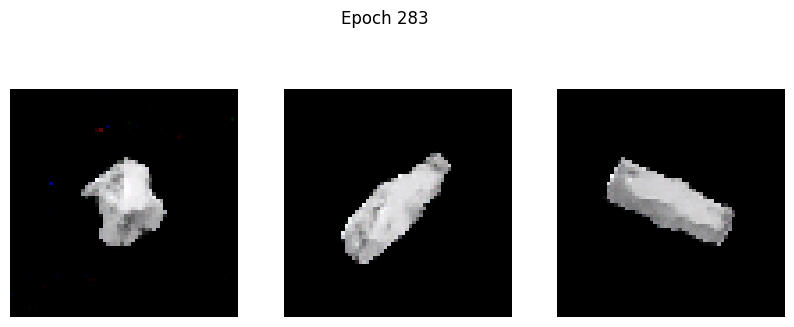

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1131 - g_loss: 4.4589
Epoch 284/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0362 - g_loss: 4.2860

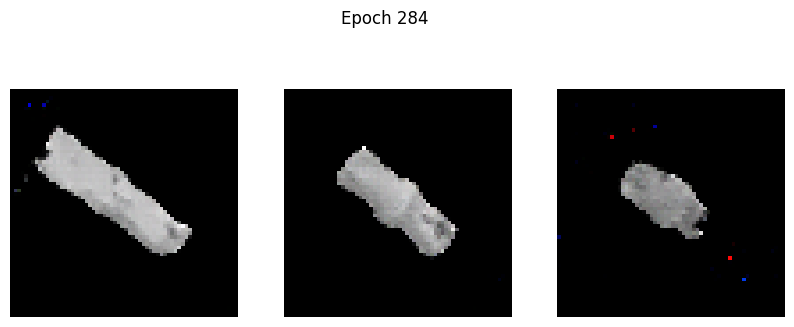

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0363 - g_loss: 4.2857
Epoch 285/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0859 - g_loss: 4.4784

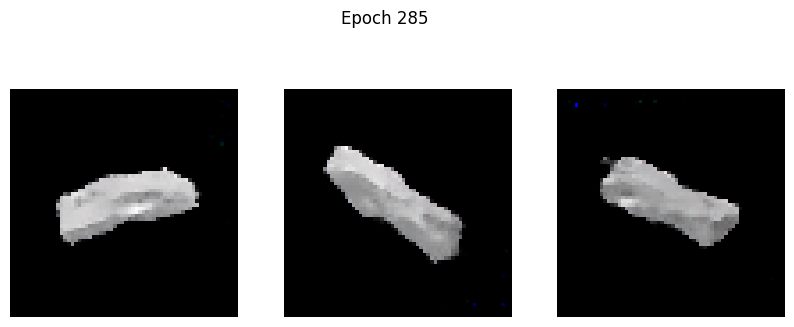

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0865 - g_loss: 4.4794
Epoch 286/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1277 - g_loss: 4.4156

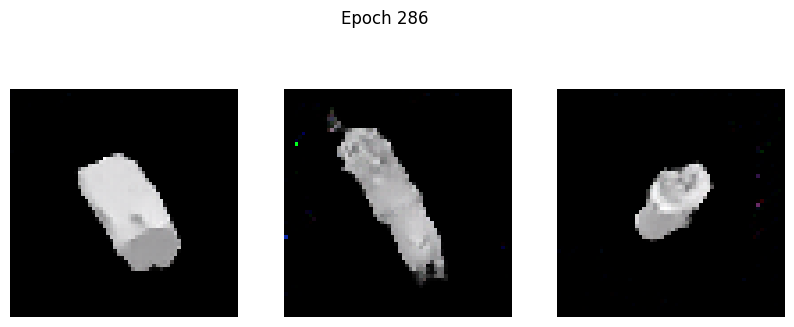

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1274 - g_loss: 4.4148
Epoch 287/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0787 - g_loss: 4.3669

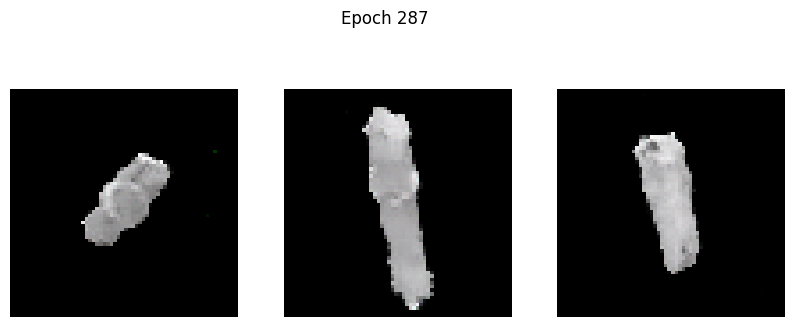

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0785 - g_loss: 4.3657
Epoch 288/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.1292 - g_loss: 4.3976

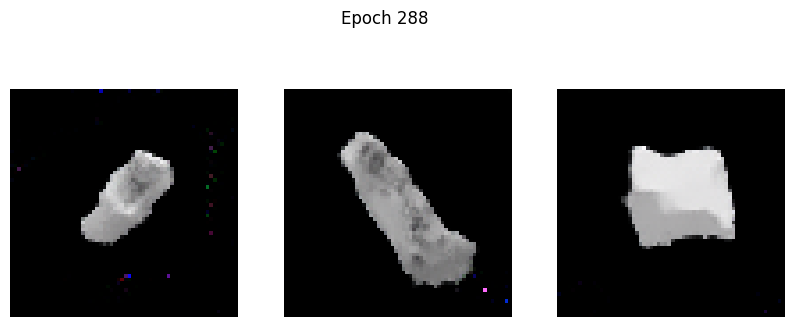

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.1288 - g_loss: 4.3971
Epoch 289/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0556 - g_loss: 4.3837

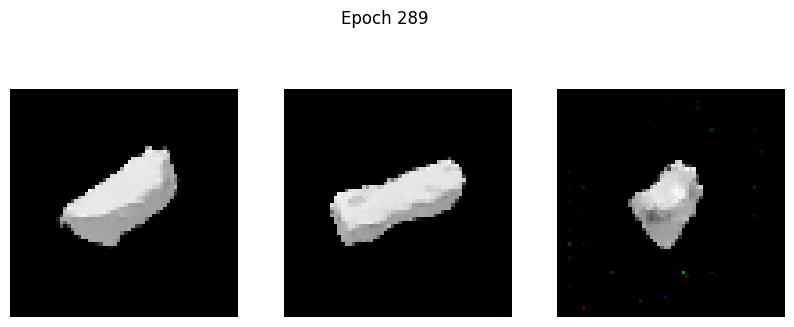

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0558 - g_loss: 4.3837
Epoch 290/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0556 - g_loss: 4.3885

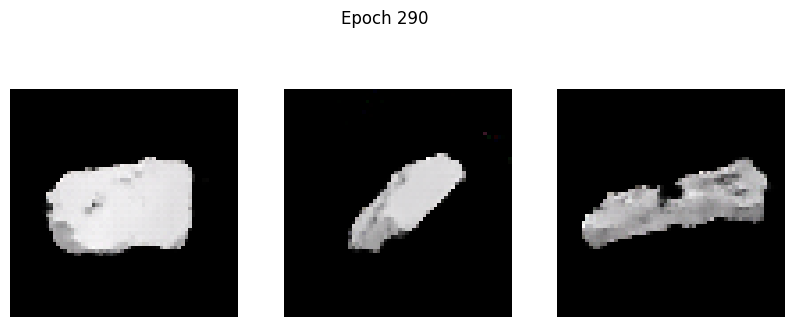

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0557 - g_loss: 4.3882
Epoch 291/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0951 - g_loss: 4.5286

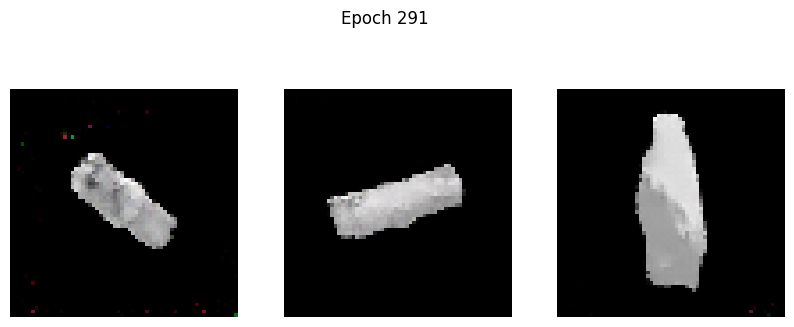

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0950 - g_loss: 4.5275
Epoch 292/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0957 - g_loss: 4.6189

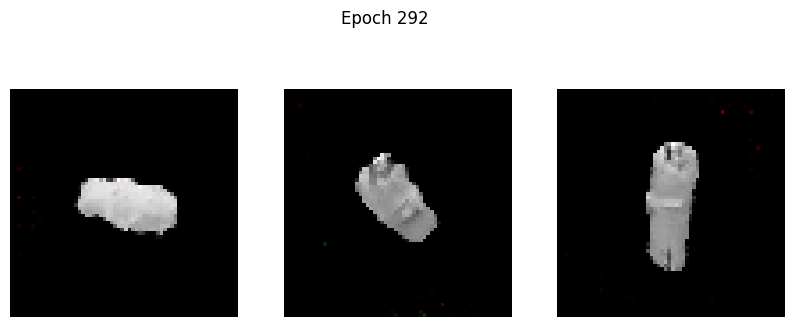

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0959 - g_loss: 4.6187
Epoch 293/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0600 - g_loss: 4.3769

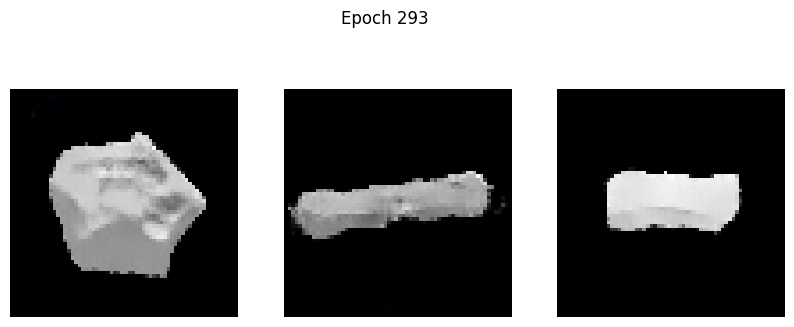

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0601 - g_loss: 4.3764
Epoch 294/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0445 - g_loss: 4.3870

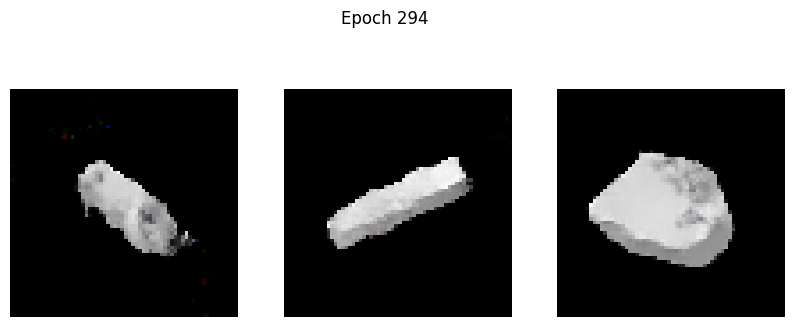

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0445 - g_loss: 4.3869
Epoch 295/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.2257 - g_loss: 4.9508

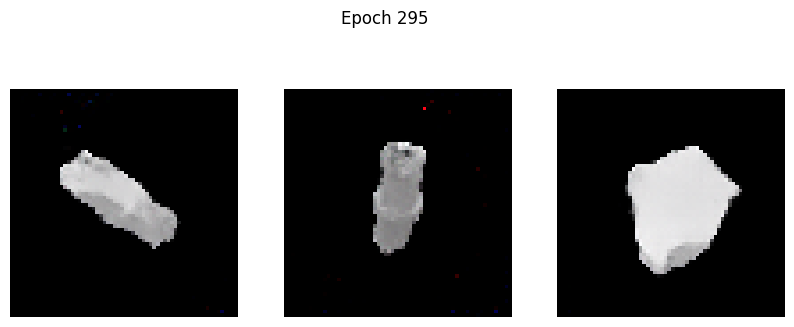

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.2248 - g_loss: 4.9472
Epoch 296/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0409 - g_loss: 4.3221

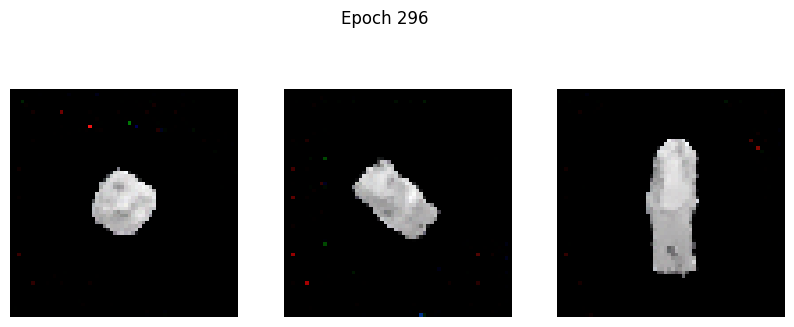

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0409 - g_loss: 4.3222
Epoch 297/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0213 - g_loss: 4.3842

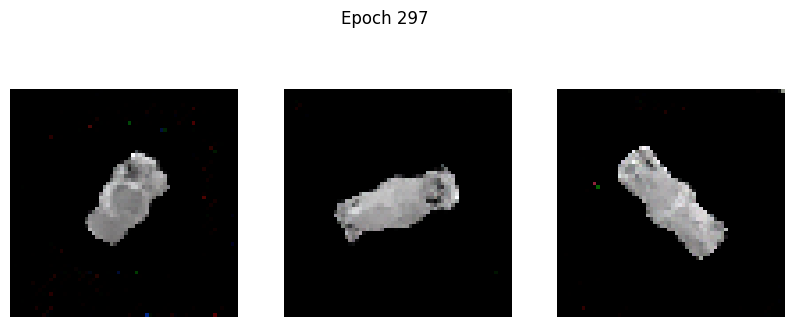

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0215 - g_loss: 4.3846
Epoch 298/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0678 - g_loss: 4.5912

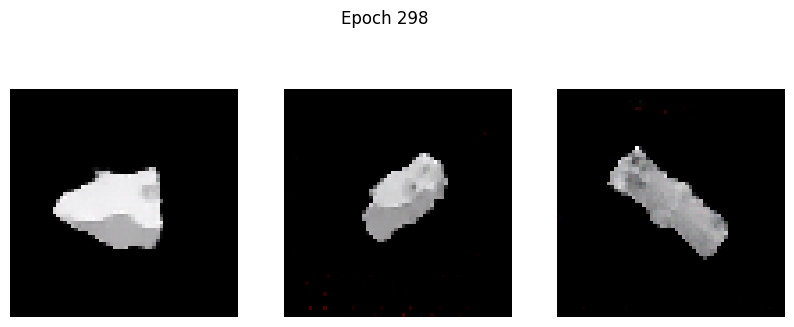

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0677 - g_loss: 4.5902
Epoch 299/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0548 - g_loss: 4.5634

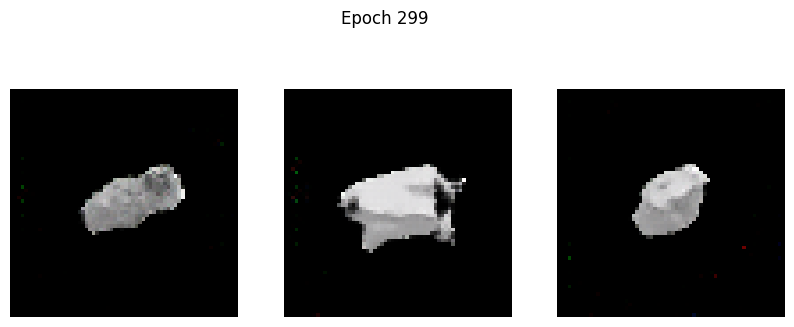

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0551 - g_loss: 4.5637
Epoch 300/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0727 - g_loss: 4.5208

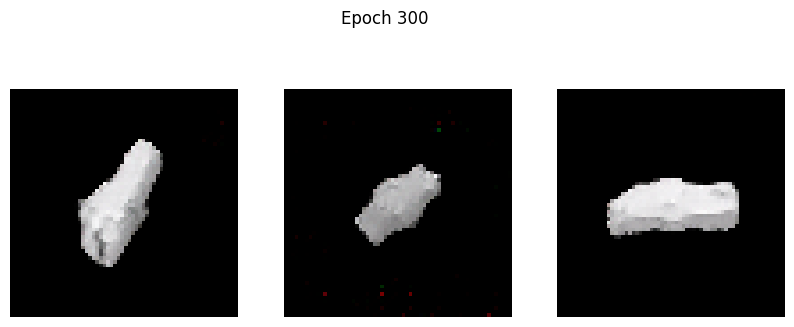

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0730 - g_loss: 4.5210
Epoch 301/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0300 - g_loss: 4.4585

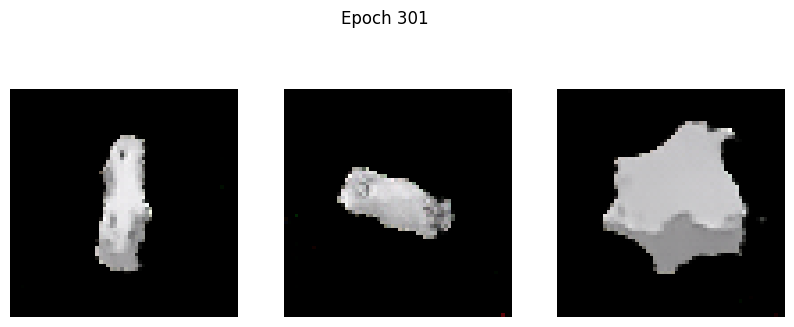

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0302 - g_loss: 4.4588
Epoch 302/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0781 - g_loss: 4.6348

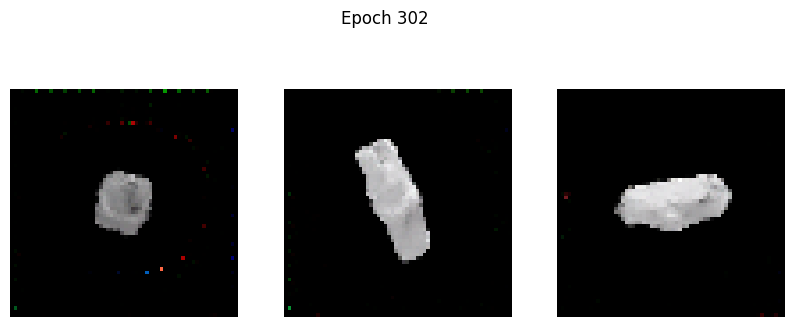

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.0779 - g_loss: 4.6342
Epoch 303/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0900 - g_loss: 4.6342

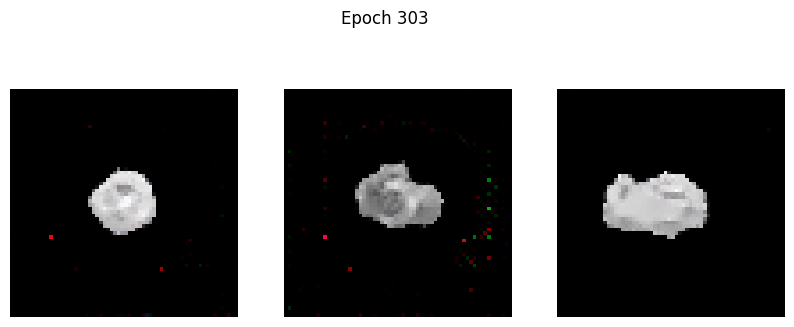

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0900 - g_loss: 4.6340
Epoch 304/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0389 - g_loss: 4.5241

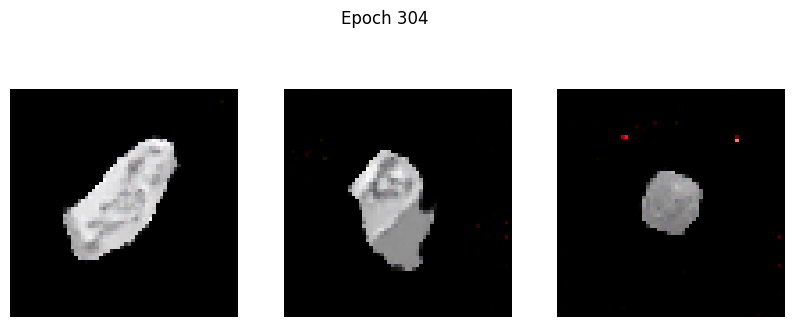

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0390 - g_loss: 4.5238
Epoch 305/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.1288 - g_loss: 4.6767

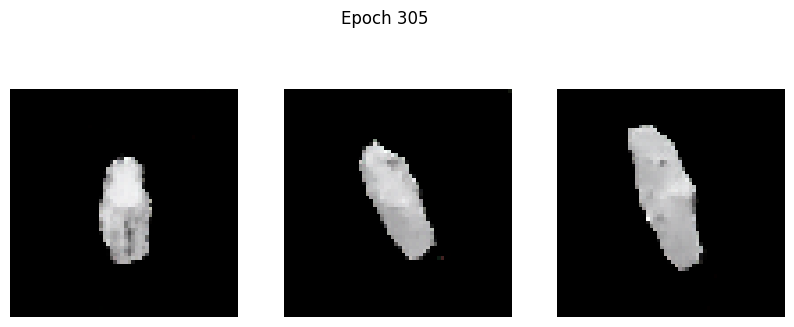

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: 0.1307 - g_loss: 4.6794
Epoch 306/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0684 - g_loss: 4.3046

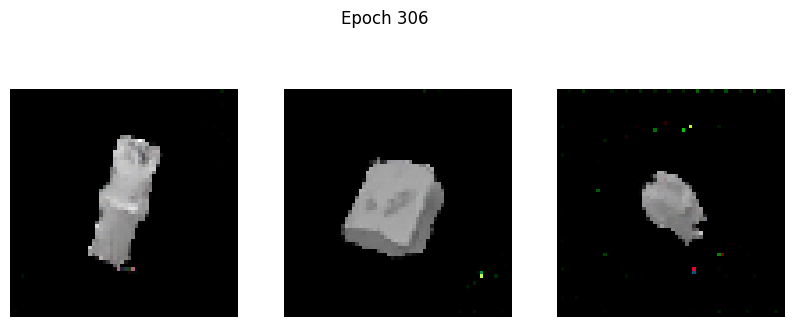

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0682 - g_loss: 4.3044
Epoch 307/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0308 - g_loss: 4.3836

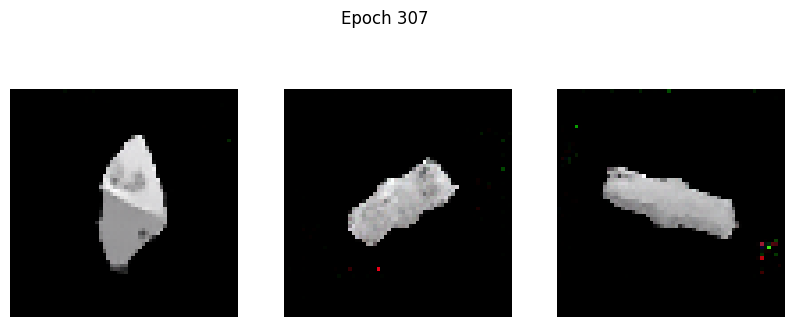

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0308 - g_loss: 4.3838
Epoch 308/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0448 - g_loss: 4.5772

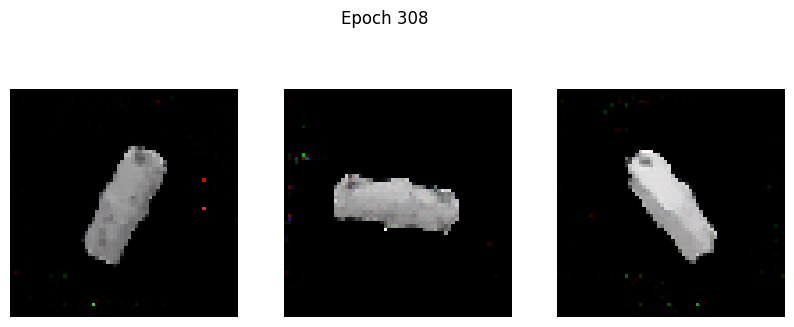

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0448 - g_loss: 4.5769
Epoch 309/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0401 - g_loss: 4.4568

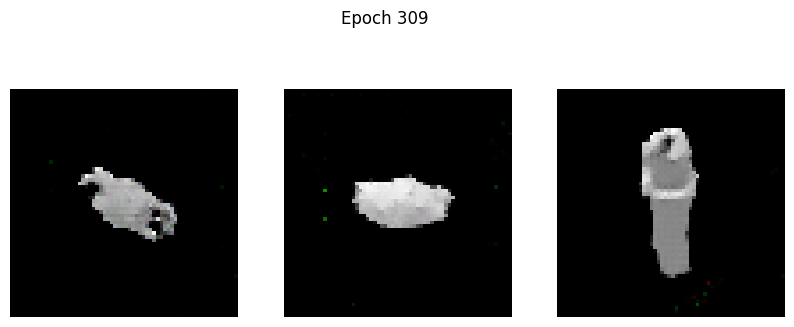

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0401 - g_loss: 4.4571
Epoch 310/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0261 - g_loss: 4.4899

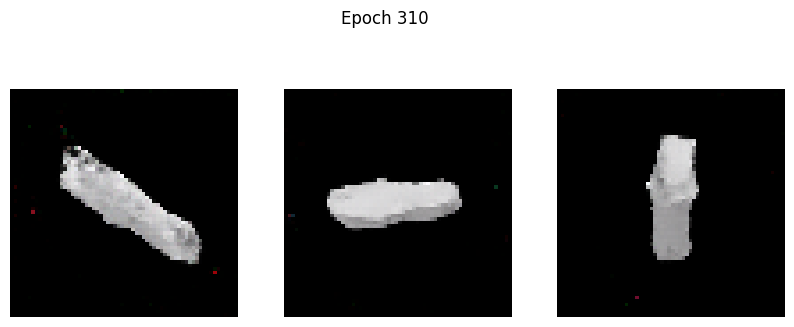

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0261 - g_loss: 4.4901
Epoch 311/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0306 - g_loss: 4.4945

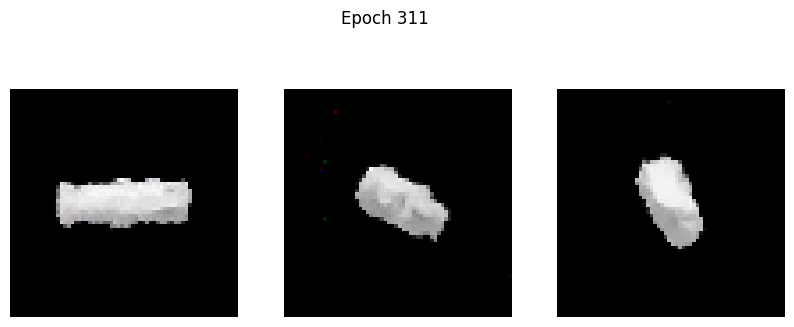

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0305 - g_loss: 4.4943
Epoch 312/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0556 - g_loss: 4.7741

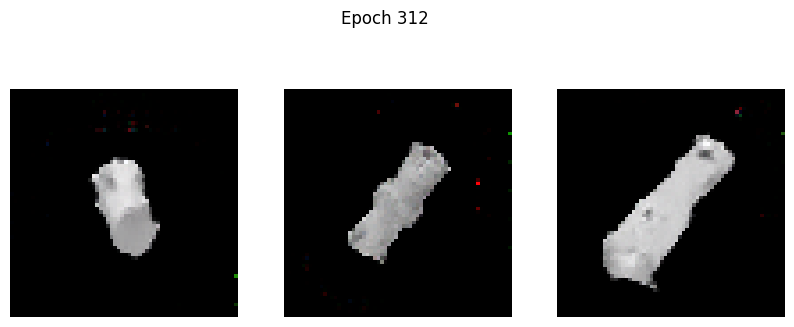

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0555 - g_loss: 4.7725
Epoch 313/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0779 - g_loss: 4.7671

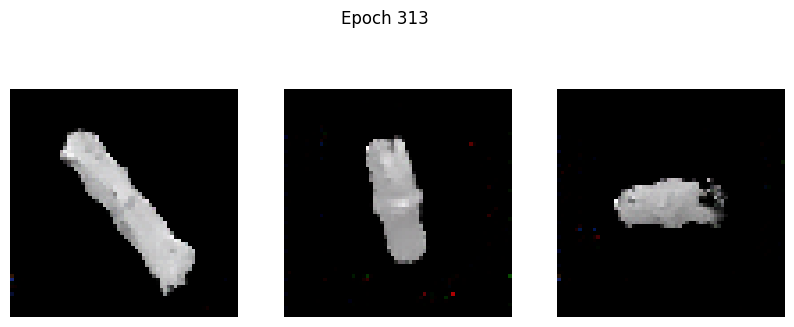

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0776 - g_loss: 4.7658
Epoch 314/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0510 - g_loss: 4.7208

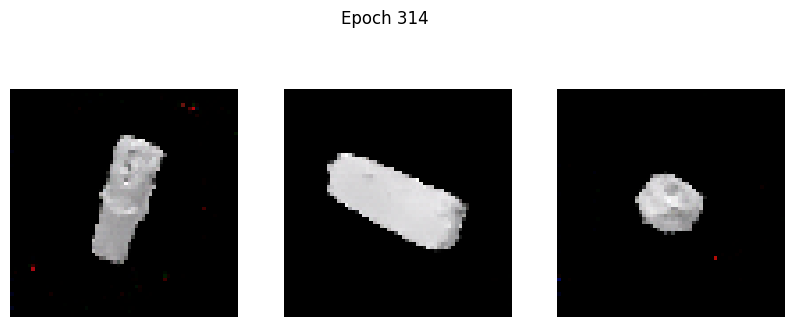

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0509 - g_loss: 4.7204
Epoch 315/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0705 - g_loss: 4.9149

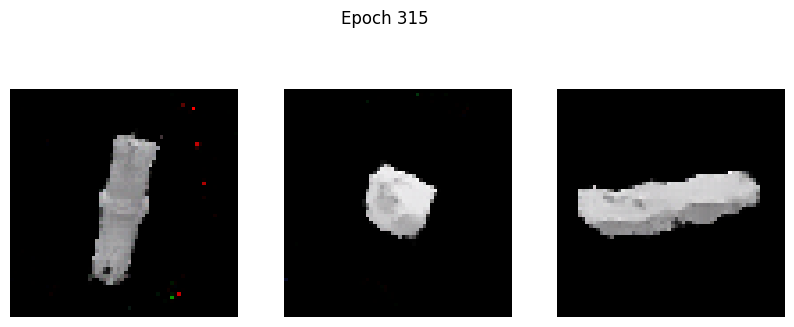

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0705 - g_loss: 4.9142
Epoch 316/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0254 - g_loss: 4.6147

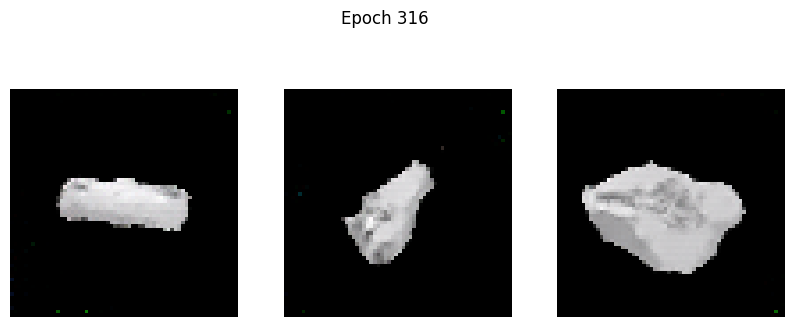

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0255 - g_loss: 4.6151
Epoch 317/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.1776 - g_loss: 5.0845

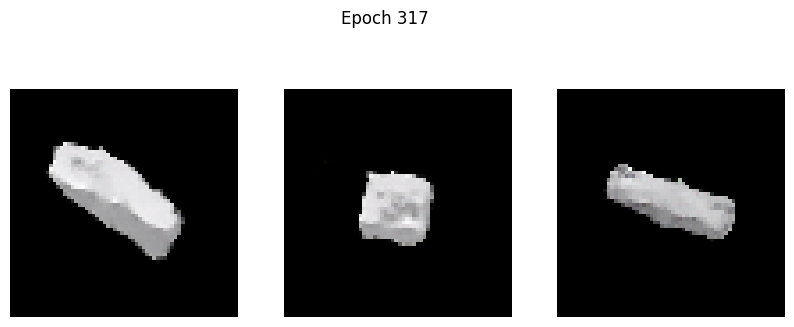

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.1772 - g_loss: 5.0818
Epoch 318/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0338 - g_loss: 4.6943

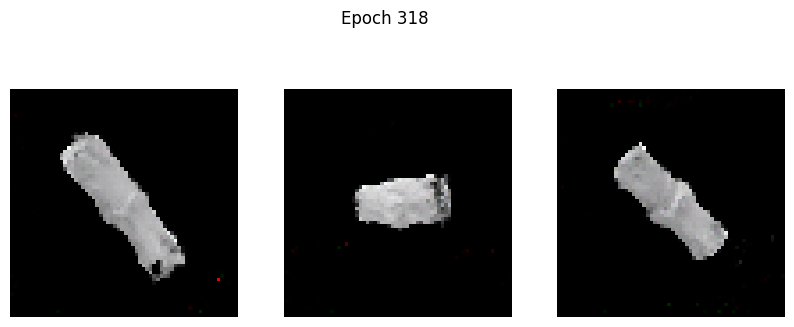

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0340 - g_loss: 4.6946
Epoch 319/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.1864 - g_loss: 4.7711

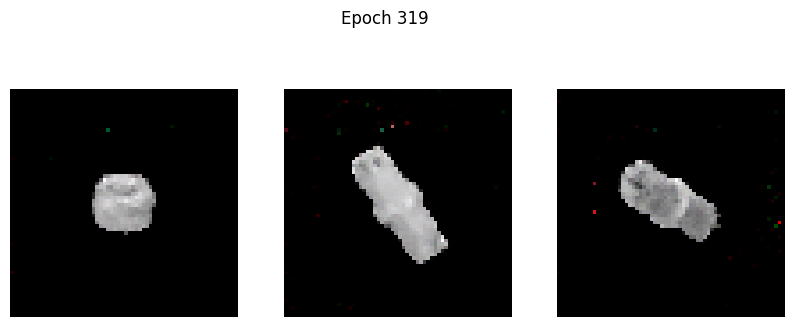

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.1862 - g_loss: 4.7701
Epoch 320/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0238 - g_loss: 4.5467

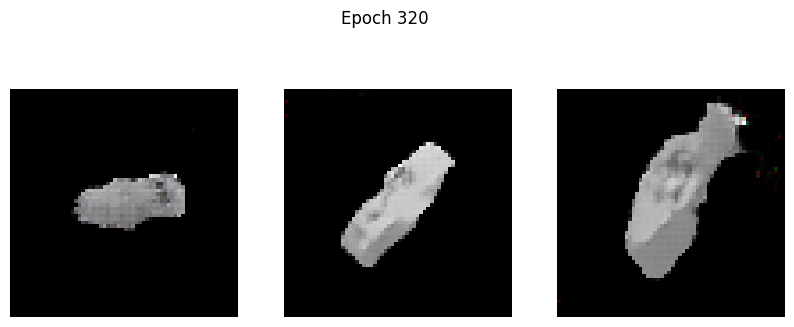

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0238 - g_loss: 4.5460
Epoch 321/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0145 - g_loss: 4.5916

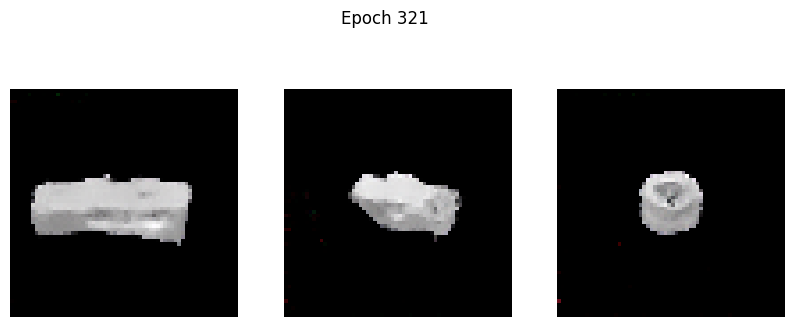

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0147 - g_loss: 4.5925
Epoch 322/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0743 - g_loss: 4.8581

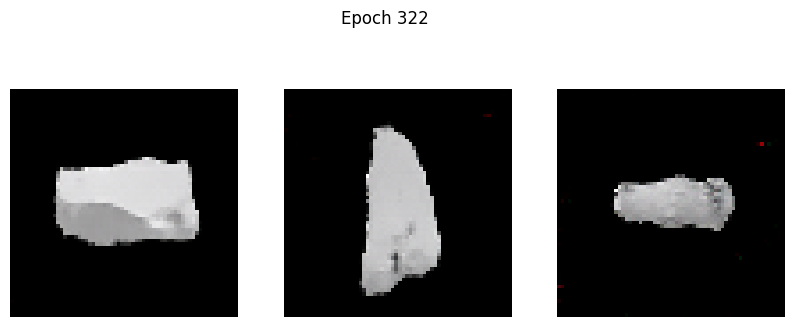

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0741 - g_loss: 4.8567
Epoch 323/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0459 - g_loss: 4.6114

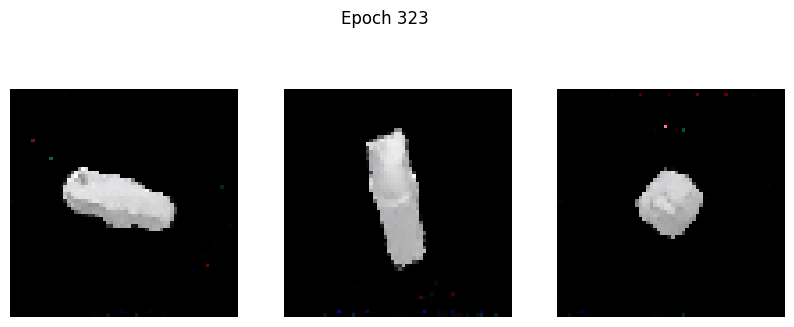

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0459 - g_loss: 4.6120
Epoch 324/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0517 - g_loss: 4.6993

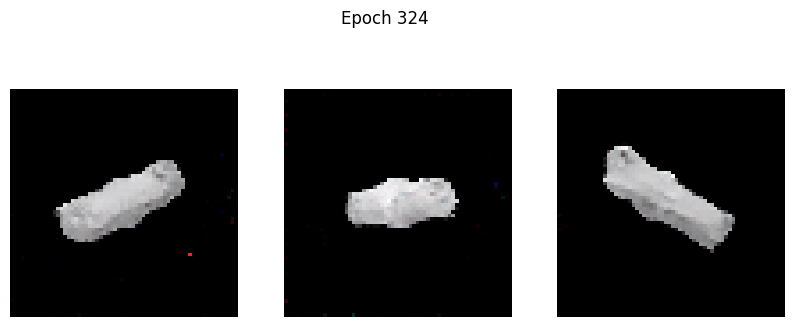

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0516 - g_loss: 4.6997
Epoch 325/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0322 - g_loss: 4.7487

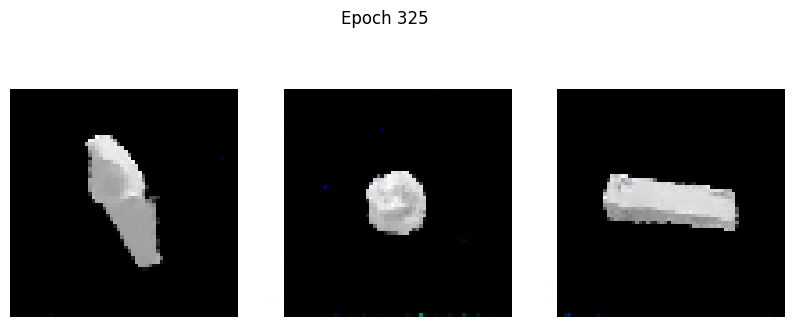

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0324 - g_loss: 4.7492
Epoch 326/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0469 - g_loss: 4.6288

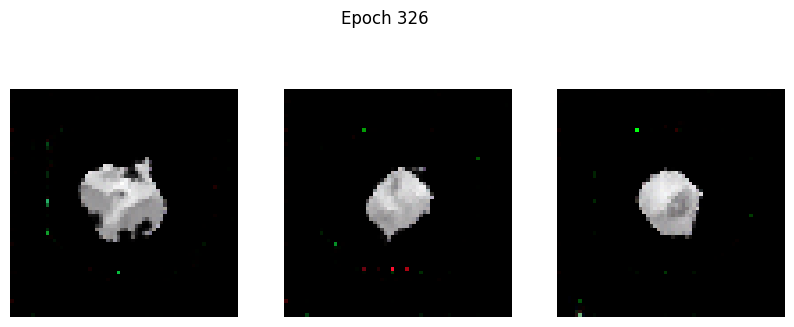

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0473 - g_loss: 4.6304
Epoch 327/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0353 - g_loss: 4.5872

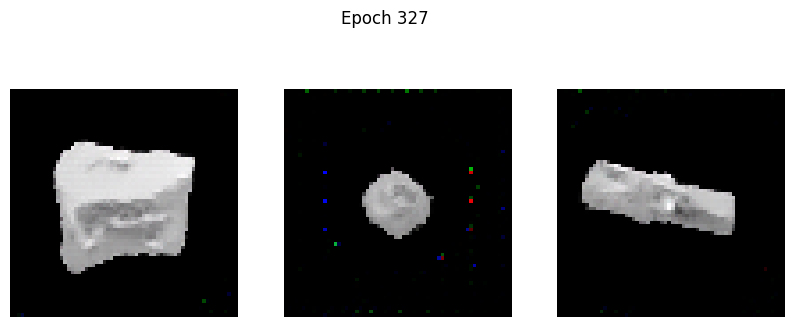

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0353 - g_loss: 4.5876
Epoch 328/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0492 - g_loss: 4.7687

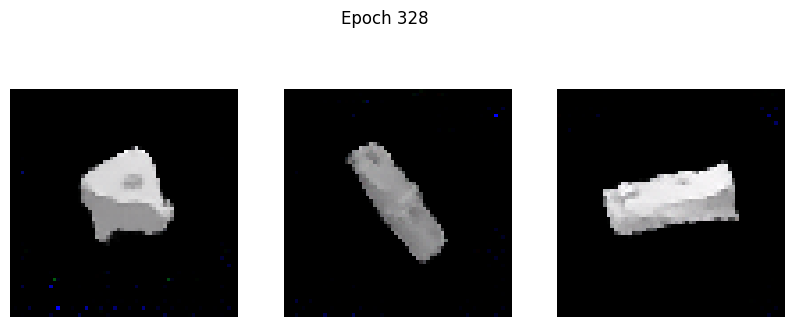

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0494 - g_loss: 4.7692
Epoch 329/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0210 - g_loss: 4.6701

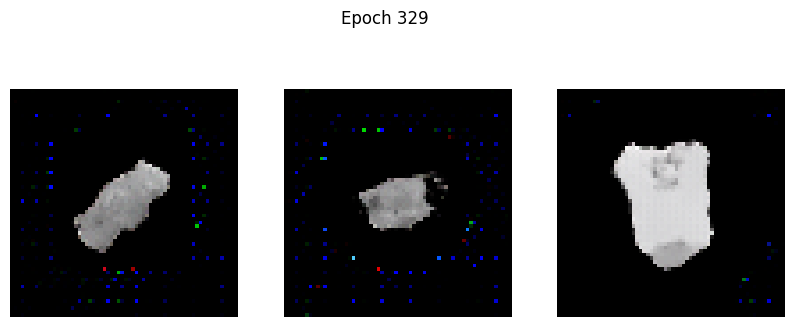

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0215 - g_loss: 4.6729
Epoch 330/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0893 - g_loss: 4.6077

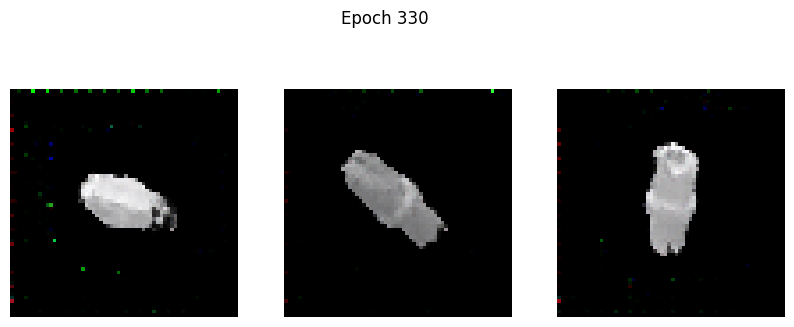

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0889 - g_loss: 4.6087
Epoch 331/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0313 - g_loss: 4.8309

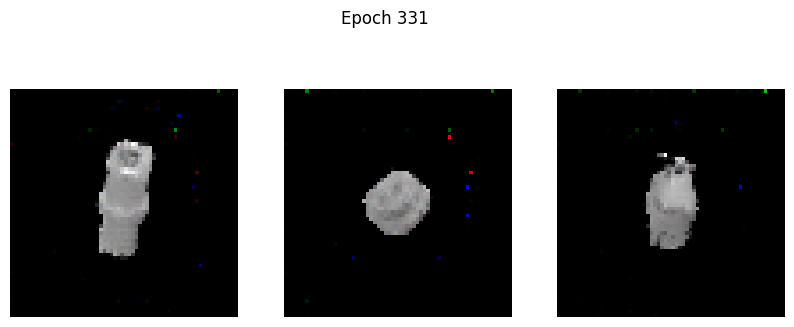

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0314 - g_loss: 4.8310
Epoch 332/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0235 - g_loss: 4.7420

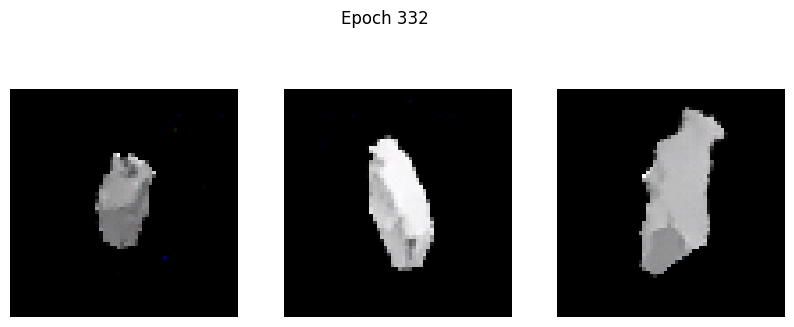

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0237 - g_loss: 4.7437
Epoch 333/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0108 - g_loss: 4.7200

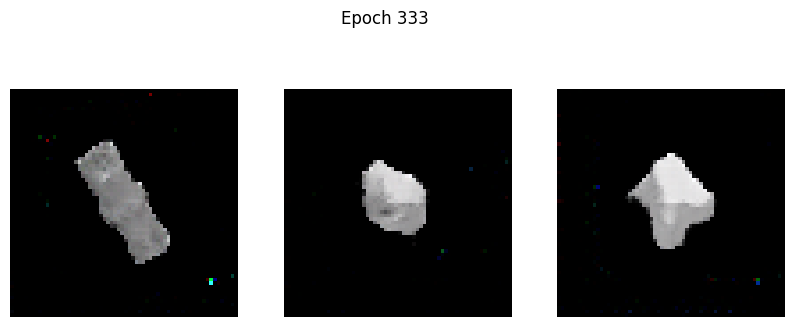

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0109 - g_loss: 4.7203
Epoch 334/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0385 - g_loss: 4.8376

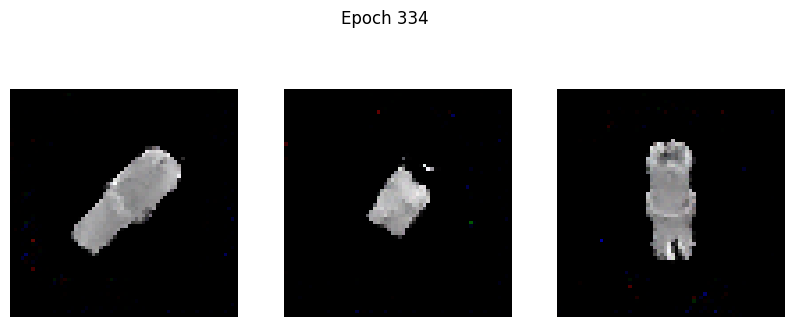

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0387 - g_loss: 4.8386
Epoch 335/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0164 - g_loss: 4.9120

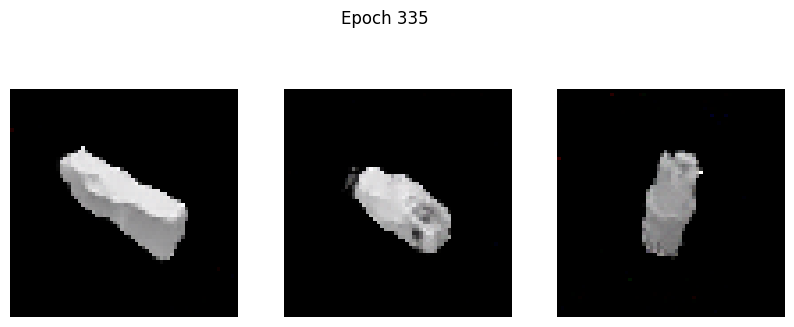

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0164 - g_loss: 4.9113
Epoch 336/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0326 - g_loss: 4.9564

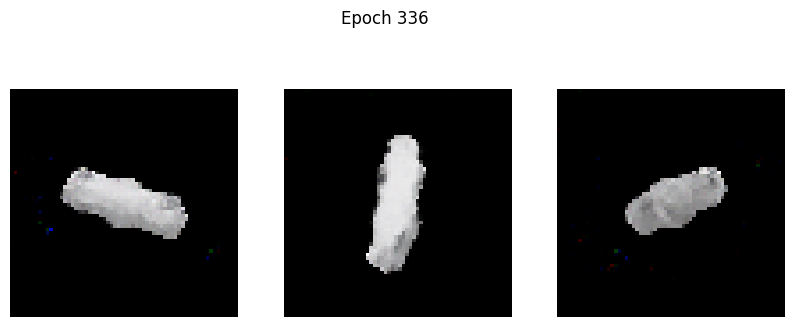

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0327 - g_loss: 4.9563
Epoch 337/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0176 - g_loss: 4.9480

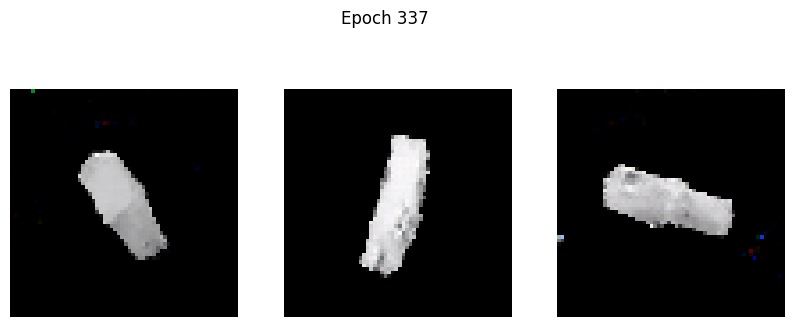

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0176 - g_loss: 4.9485
Epoch 338/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0235 - g_loss: 4.7515

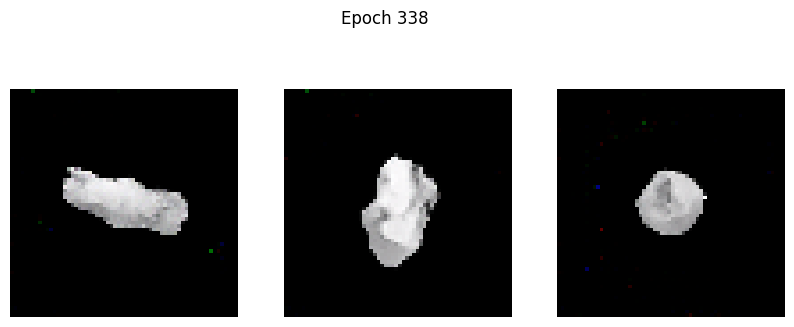

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0236 - g_loss: 4.7523
Epoch 339/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0648 - g_loss: 4.8236

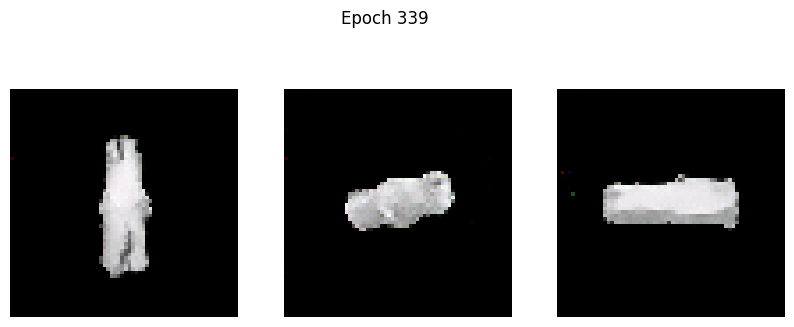

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0654 - g_loss: 4.8248
Epoch 340/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0639 - g_loss: 4.8389

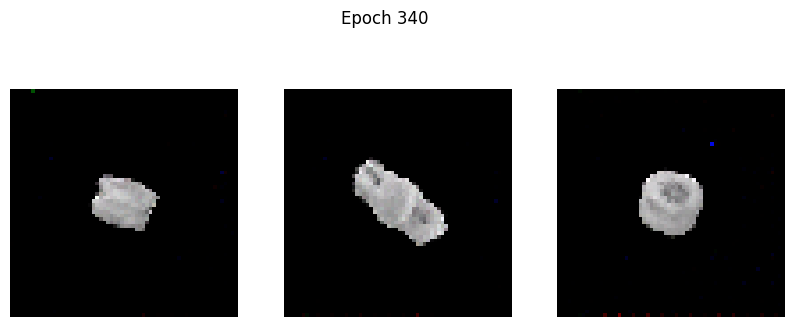

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0639 - g_loss: 4.8399
Epoch 341/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 0.0204 - g_loss: 4.8558

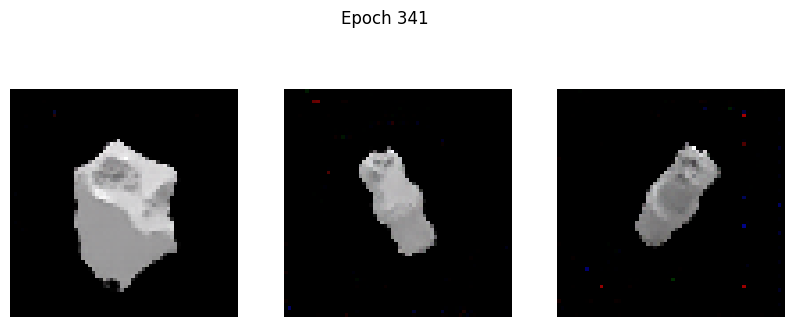

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - d_loss: 0.0204 - g_loss: 4.8557
Epoch 342/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.1225 - g_loss: 5.0194

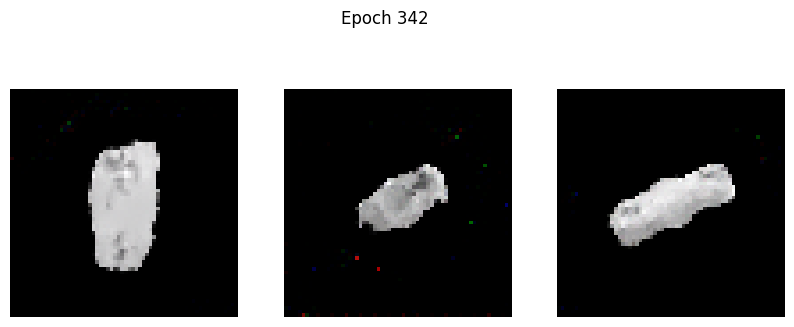

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1223 - g_loss: 5.0194
Epoch 343/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0010 - g_loss: 4.8976

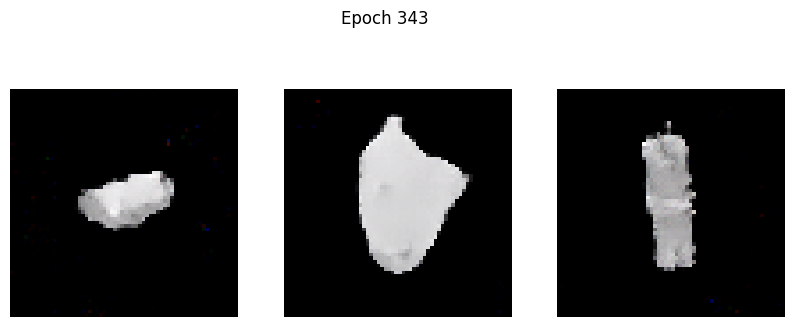

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -8.6036e-04 - g_loss: 4.8978
Epoch 344/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0513 - g_loss: 5.0284

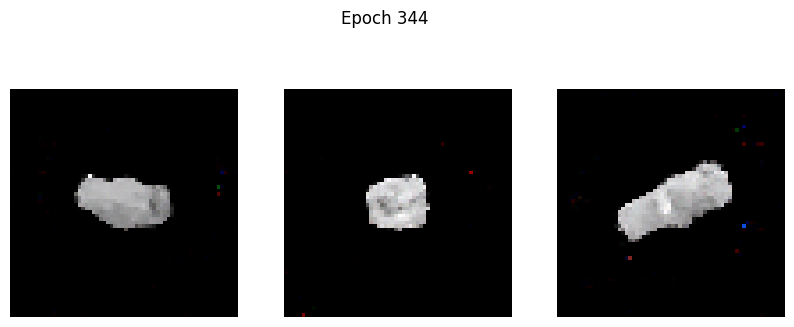

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0512 - g_loss: 5.0277
Epoch 345/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0123 - g_loss: 4.8571

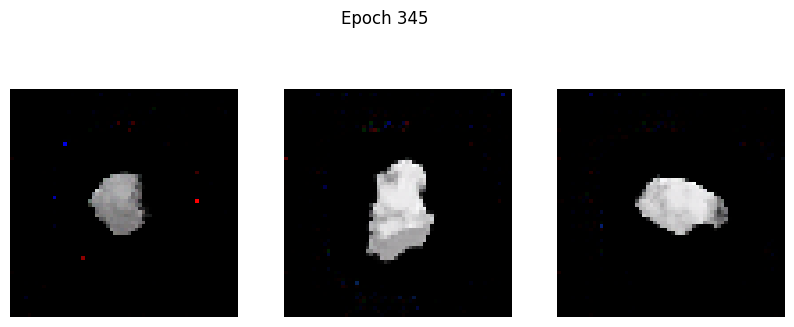

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0122 - g_loss: 4.8567
Epoch 346/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0313 - g_loss: 5.0195

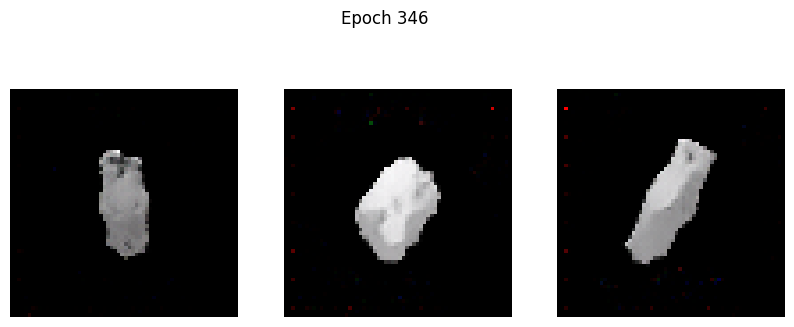

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0315 - g_loss: 5.0196
Epoch 347/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0042 - g_loss: 4.8551

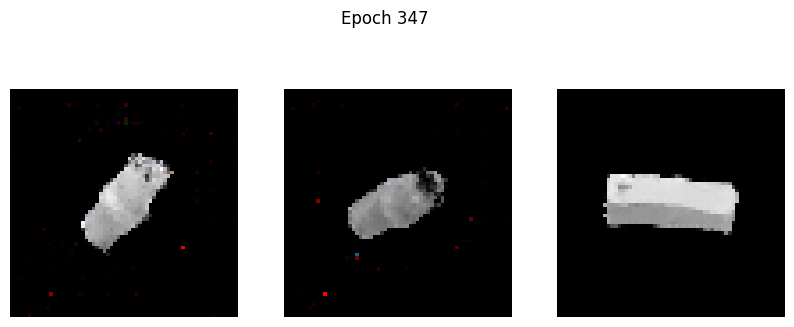

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - d_loss: -0.0042 - g_loss: 4.8554
Epoch 348/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0133 - g_loss: 4.9132

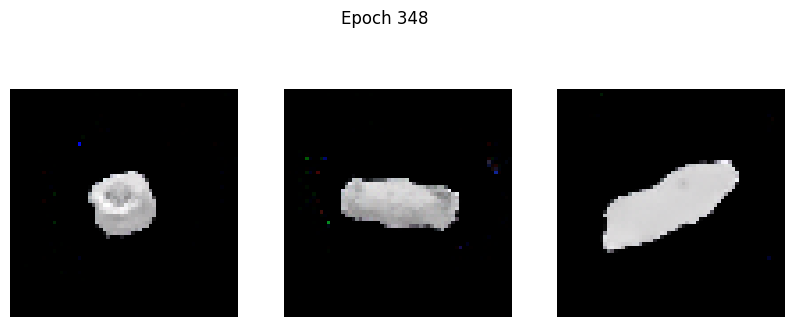

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0131 - g_loss: 4.9147
Epoch 349/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0337 - g_loss: 5.1475

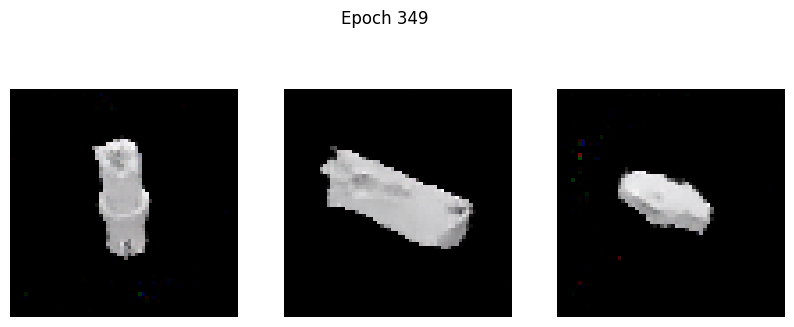

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0336 - g_loss: 5.1475
Epoch 350/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0015 - g_loss: 4.9530

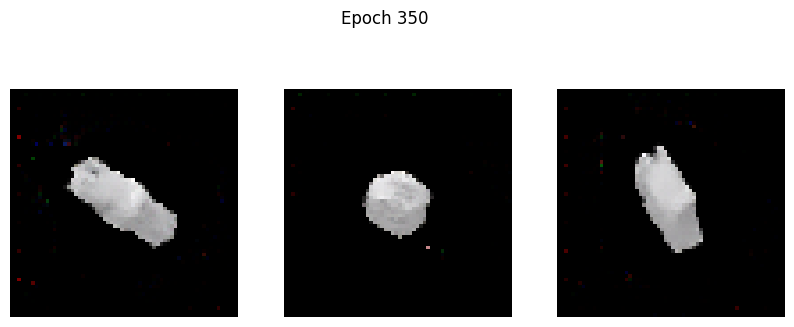

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0015 - g_loss: 4.9525
Epoch 351/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.1371 - g_loss: 5.5938

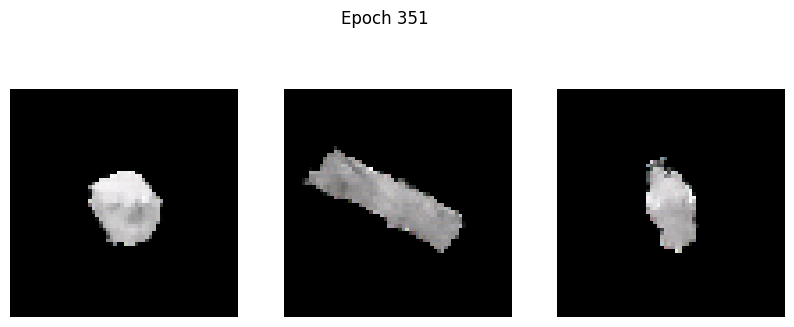

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.1386 - g_loss: 5.5960
Epoch 352/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0385 - g_loss: 4.9728

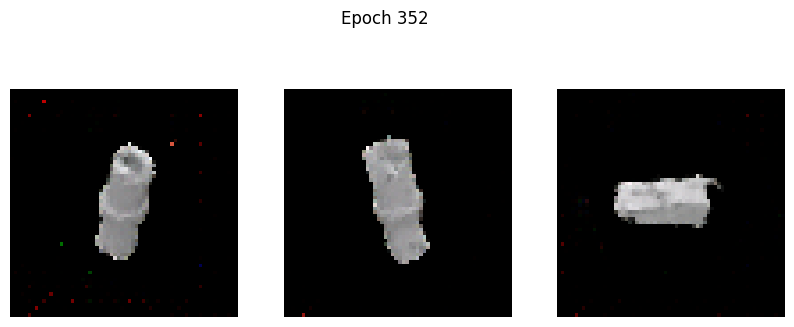

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0386 - g_loss: 4.9729
Epoch 353/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0281 - g_loss: 4.9768

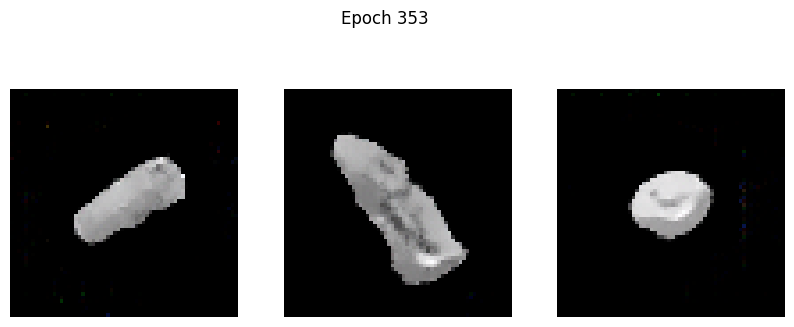

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0281 - g_loss: 4.9763
Epoch 354/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0176 - g_loss: 4.9631

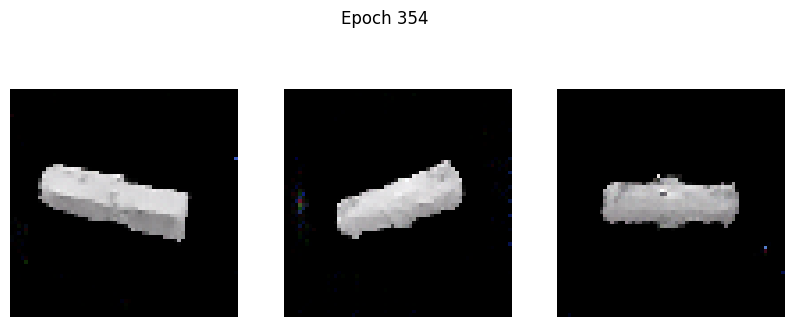

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -0.0173 - g_loss: 4.9640
Epoch 355/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 5.9300e-05 - g_loss: 5.1566

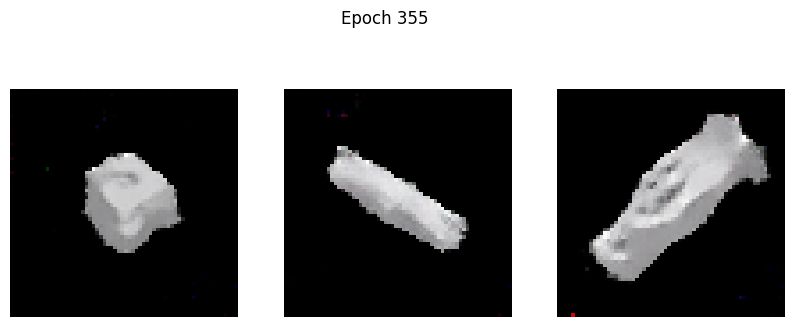

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 3.8307e-05 - g_loss: 5.1556
Epoch 356/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0167 - g_loss: 5.1627

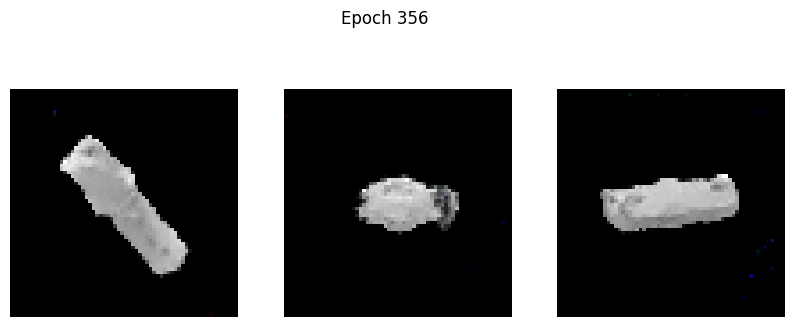

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0167 - g_loss: 5.1621
Epoch 357/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0788 - g_loss: 5.6868

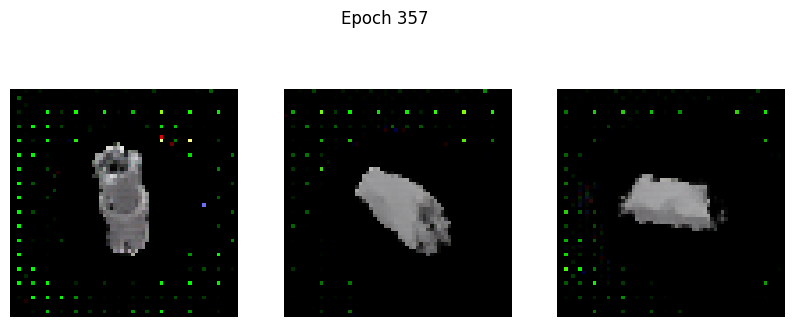

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0784 - g_loss: 5.6823
Epoch 358/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0112 - g_loss: 5.1546

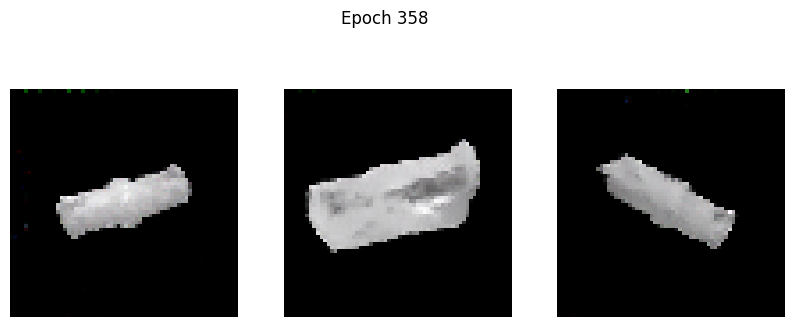

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0115 - g_loss: 5.1555
Epoch 359/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0348 - g_loss: 5.2178

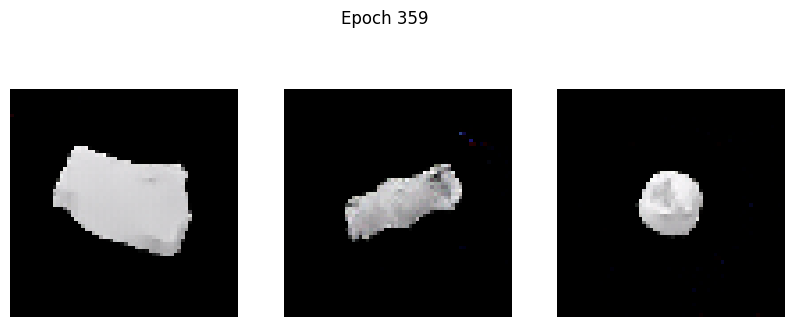

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0349 - g_loss: 5.2182
Epoch 360/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0097 - g_loss: 5.0078

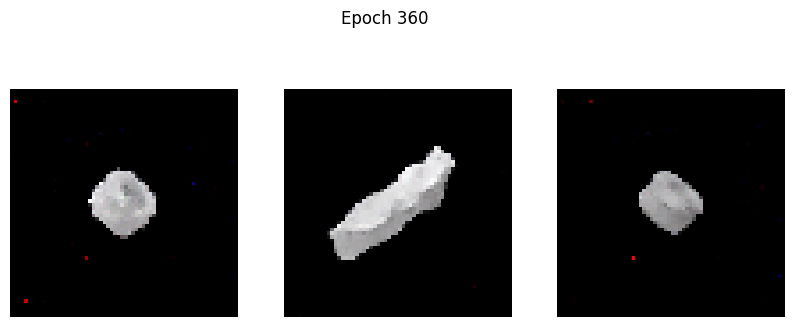

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0099 - g_loss: 5.0088
Epoch 361/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0124 - g_loss: 4.9031

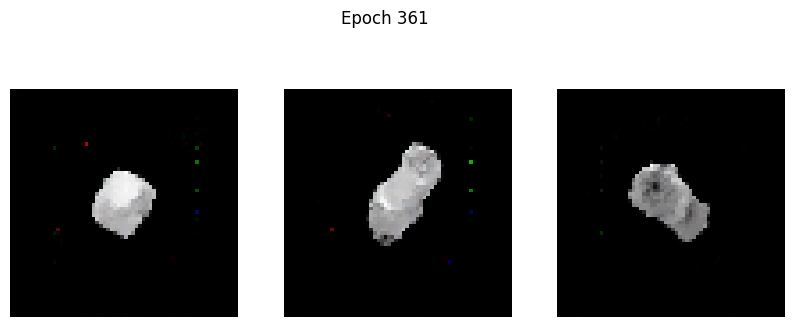

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0125 - g_loss: 4.9056
Epoch 362/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0017 - g_loss: 5.1079

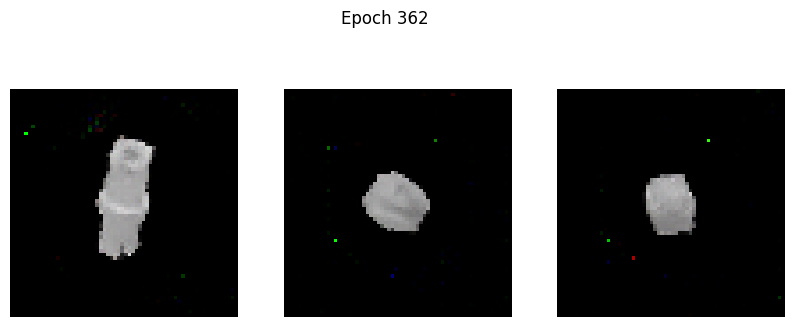

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -0.0011 - g_loss: 5.1105
Epoch 363/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0054 - g_loss: 4.9430

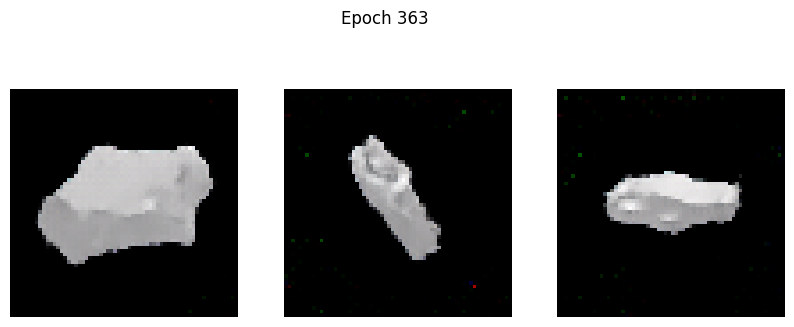

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0051 - g_loss: 4.9448
Epoch 364/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.1167 - g_loss: 5.5154

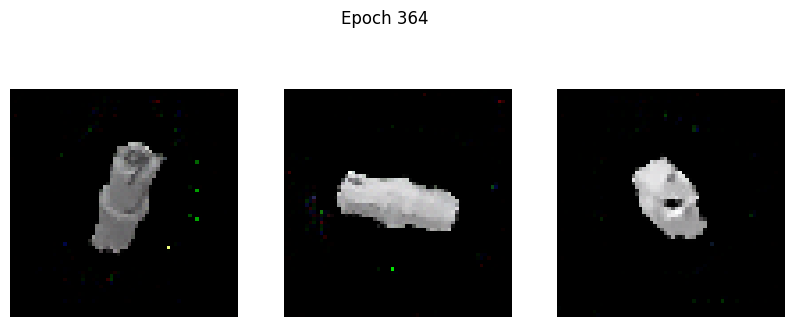

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.1161 - g_loss: 5.5123
Epoch 365/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0155 - g_loss: 5.1585

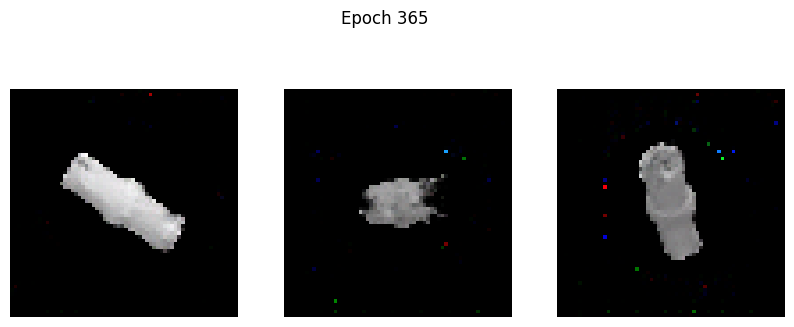

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -0.0155 - g_loss: 5.1582
Epoch 366/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0044 - g_loss: 5.2291

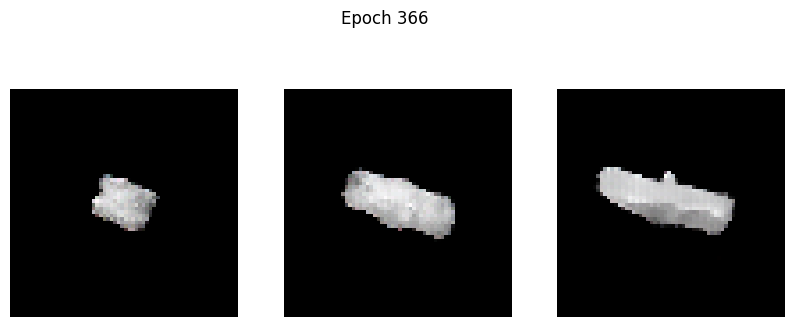

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0039 - g_loss: 5.2312
Epoch 367/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: -0.0044 - g_loss: 6.1069

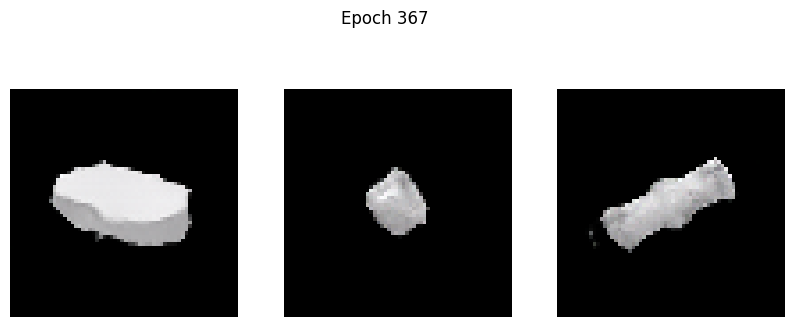

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - d_loss: -0.0045 - g_loss: 6.1014
Epoch 368/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0080 - g_loss: 5.1945

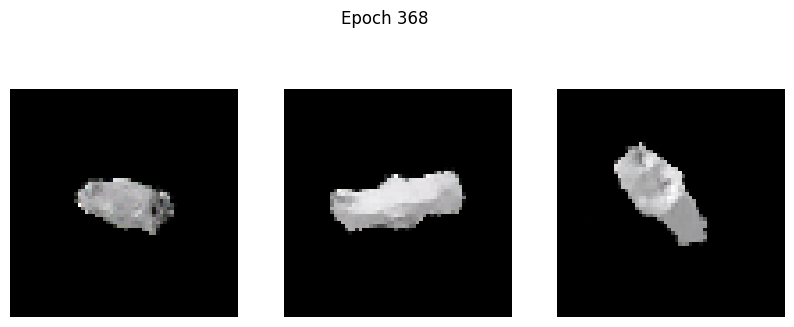

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -0.0080 - g_loss: 5.1954
Epoch 369/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0098 - g_loss: 5.2220

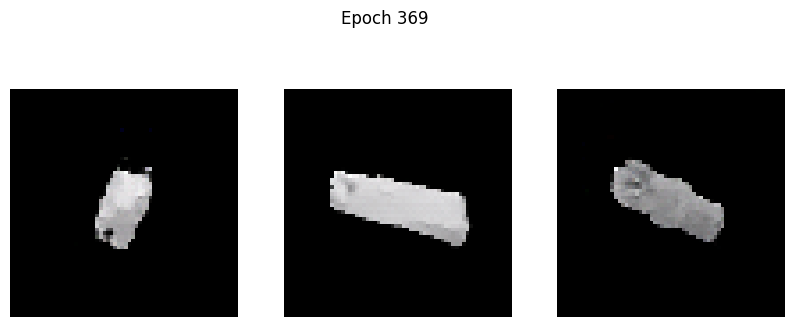

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -0.0098 - g_loss: 5.2230
Epoch 370/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0026 - g_loss: 5.4698

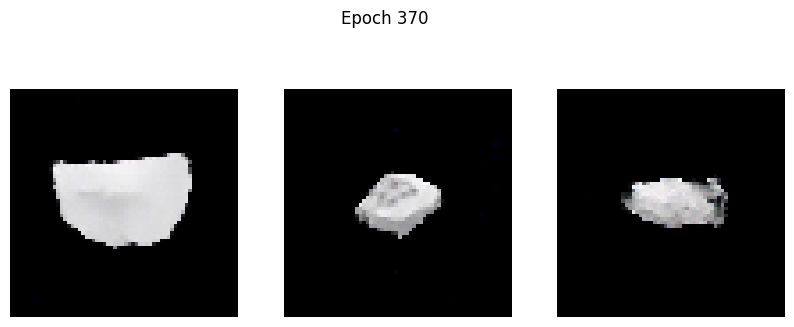

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0025 - g_loss: 5.4677
Epoch 371/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0196 - g_loss: 5.4186

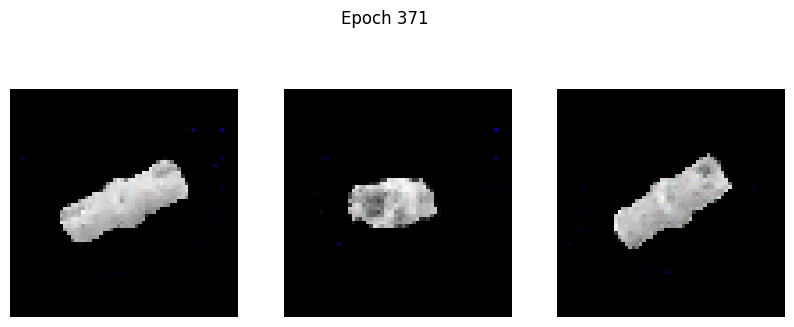

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0194 - g_loss: 5.4172
Epoch 372/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0416 - g_loss: 5.6248

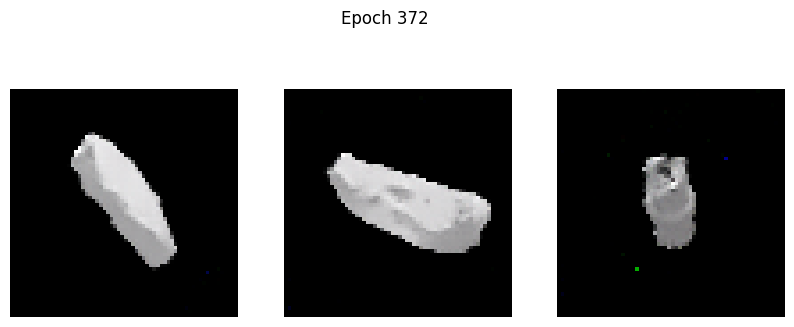

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0417 - g_loss: 5.6246
Epoch 373/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0205 - g_loss: 5.3505

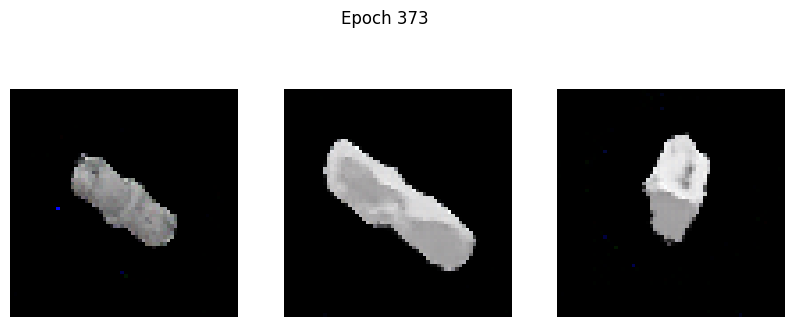

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0212 - g_loss: 5.3515
Epoch 374/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.1139 - g_loss: 5.7039

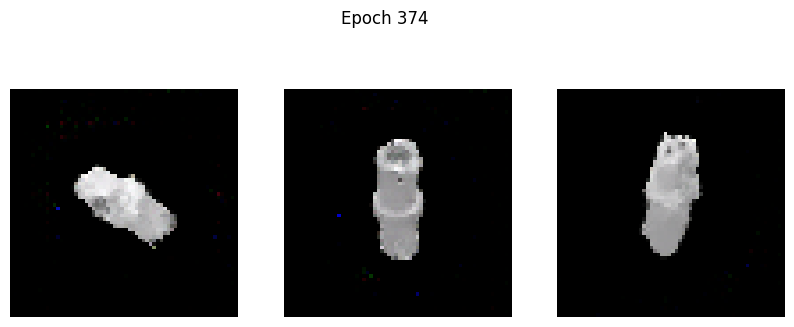

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.1136 - g_loss: 5.7031
Epoch 375/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0097 - g_loss: 5.3882

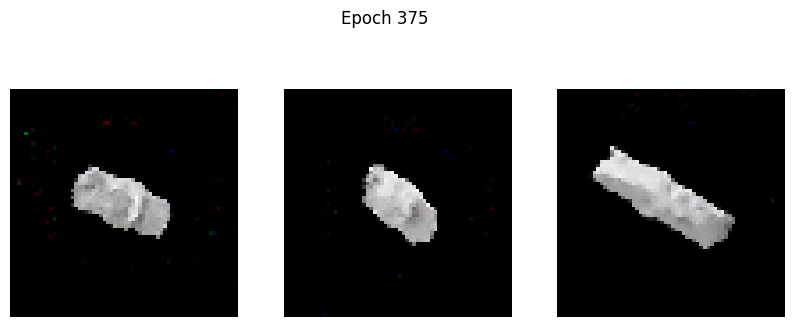

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0096 - g_loss: 5.3876
Epoch 376/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0545 - g_loss: 5.6467

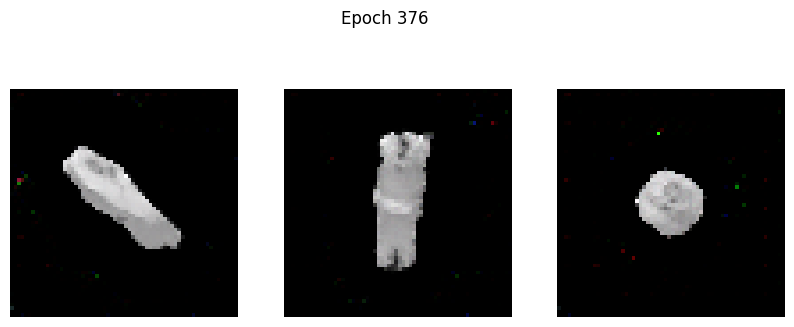

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0541 - g_loss: 5.6449
Epoch 377/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0085 - g_loss: 5.5047

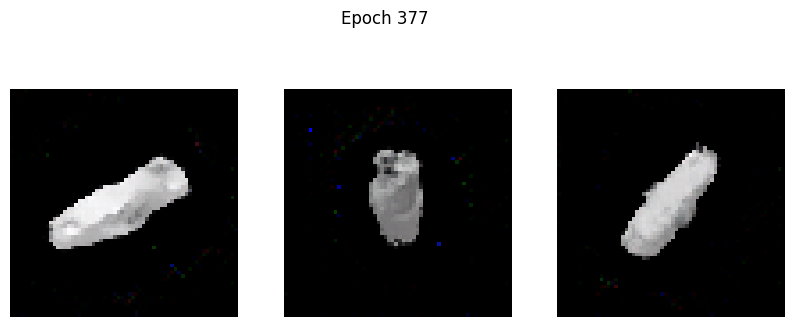

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -0.0084 - g_loss: 5.5055
Epoch 378/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0333 - g_loss: 5.3374

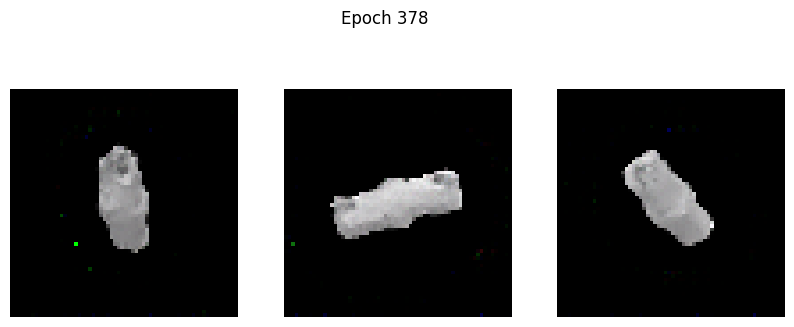

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -0.0333 - g_loss: 5.3382
Epoch 379/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0246 - g_loss: 5.3229

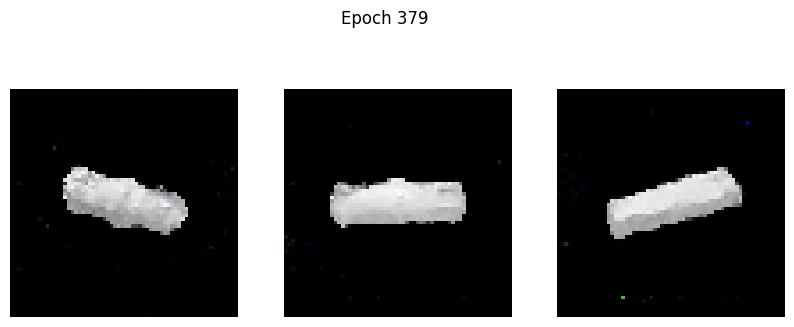

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0246 - g_loss: 5.3238
Epoch 380/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0374 - g_loss: 5.5456

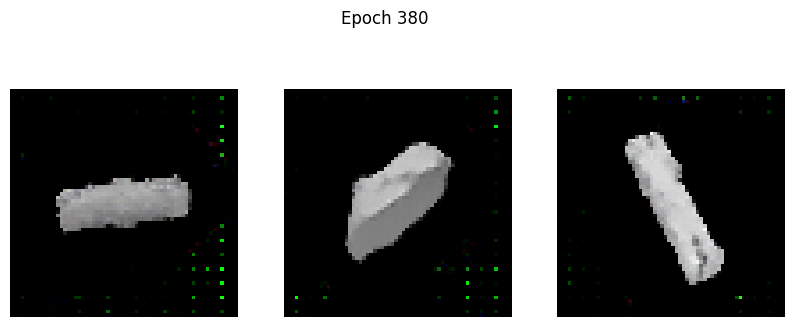

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0373 - g_loss: 5.5455
Epoch 381/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0075 - g_loss: 5.6461

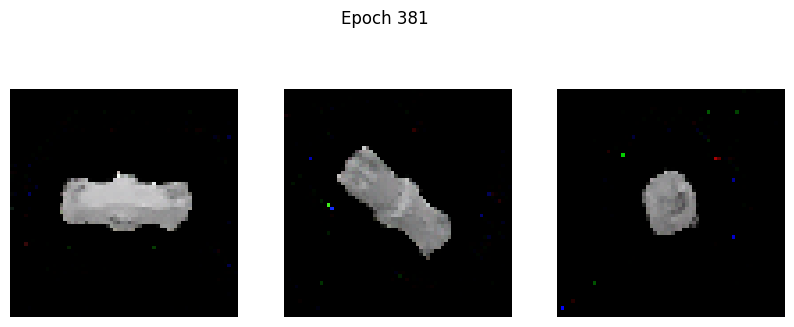

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0073 - g_loss: 5.6465
Epoch 382/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0236 - g_loss: 5.9471

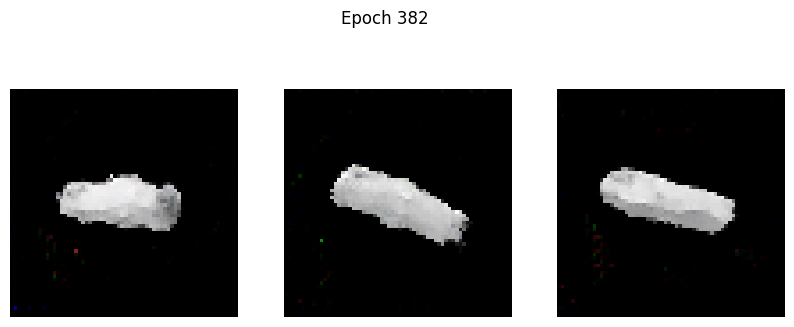

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0236 - g_loss: 5.9450
Epoch 383/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0245 - g_loss: 5.5295

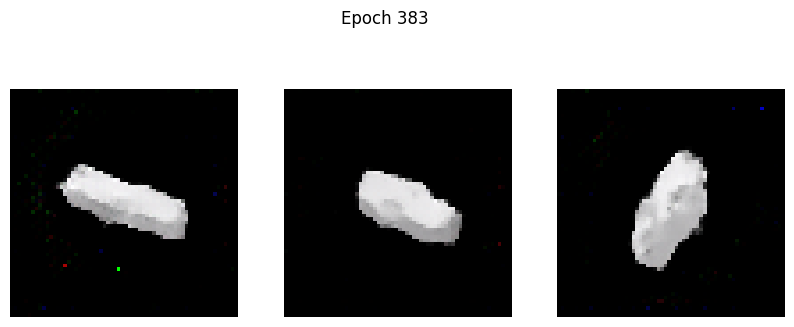

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0246 - g_loss: 5.5288
Epoch 384/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0401 - g_loss: 5.8590

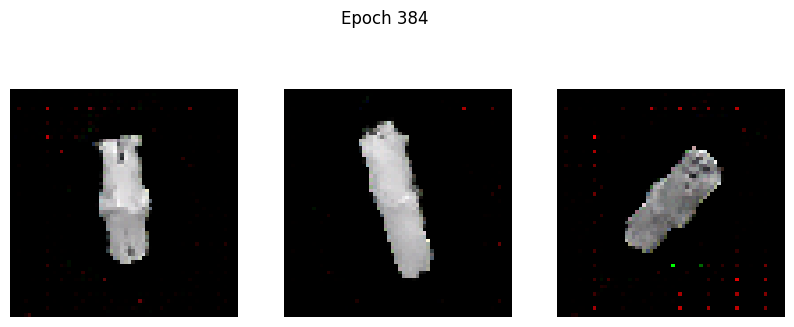

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0410 - g_loss: 5.8597
Epoch 385/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0156 - g_loss: 5.1810

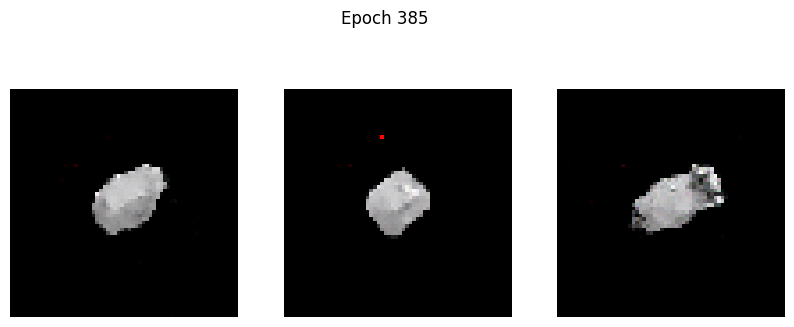

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0154 - g_loss: 5.1842
Epoch 386/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0120 - g_loss: 5.5785

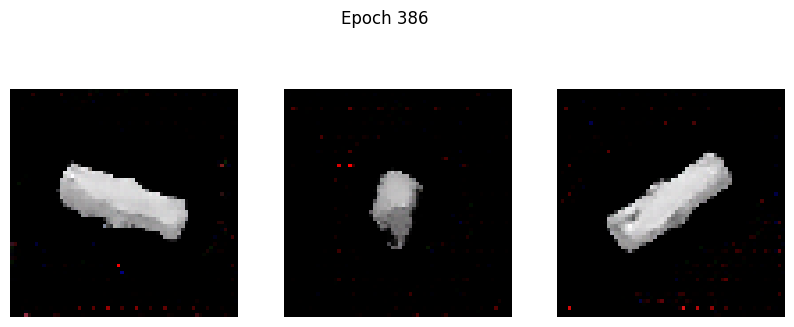

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0120 - g_loss: 5.5789
Epoch 387/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0240 - g_loss: 5.3609

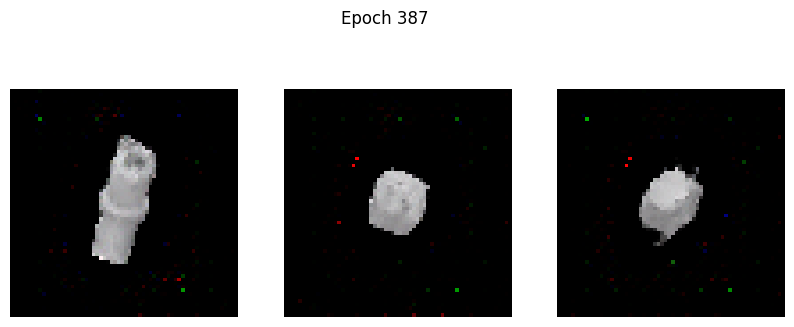

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0239 - g_loss: 5.3624
Epoch 388/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0166 - g_loss: 5.4204

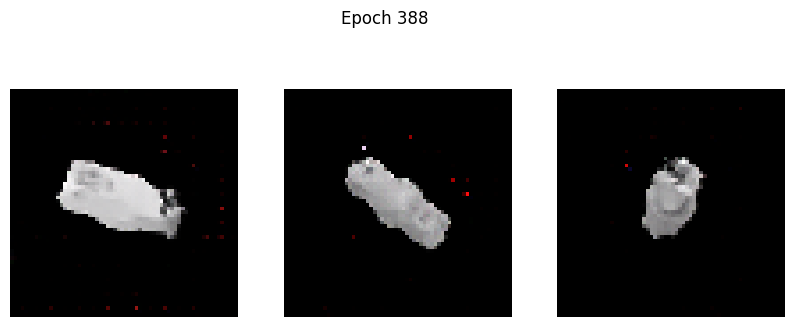

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0164 - g_loss: 5.4225
Epoch 389/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -4.0446e-05 - g_loss: 5.6890

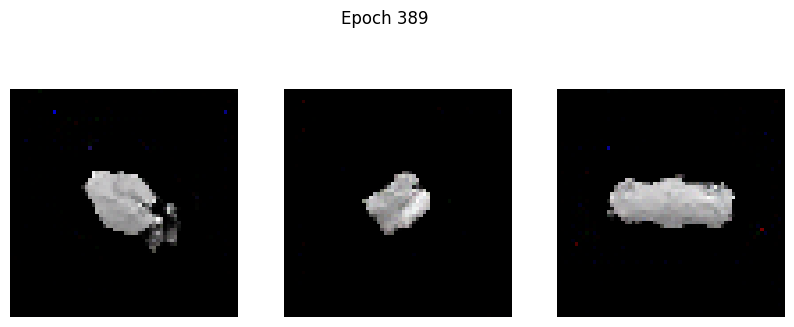

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -7.4100e-05 - g_loss: 5.6887
Epoch 390/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0101 - g_loss: 5.5459

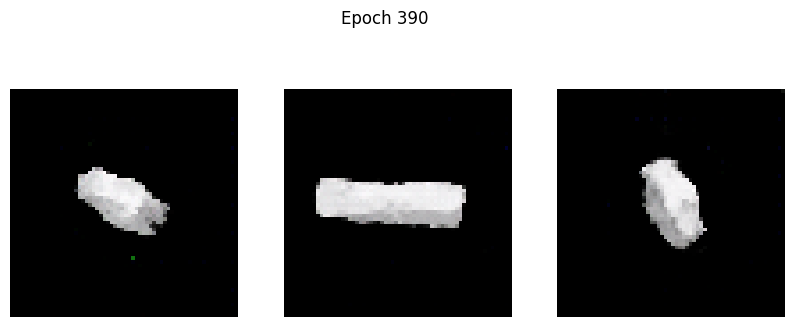

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0098 - g_loss: 5.5480
Epoch 391/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0159 - g_loss: 5.5838

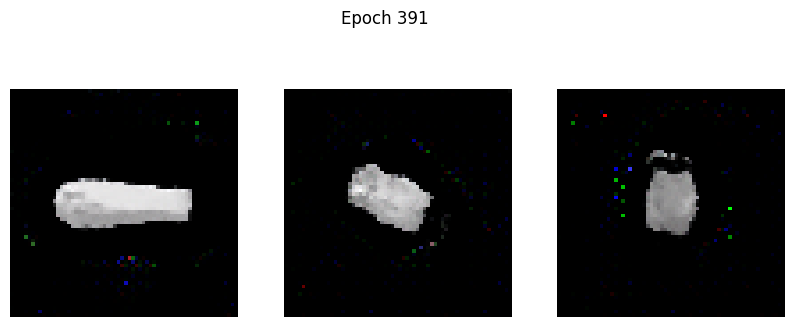

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0159 - g_loss: 5.5828
Epoch 392/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0200 - g_loss: 5.7181

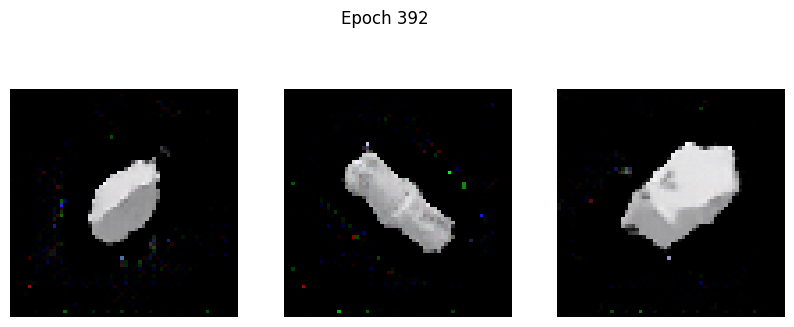

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0197 - g_loss: 5.7187
Epoch 393/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0298 - g_loss: 5.3952

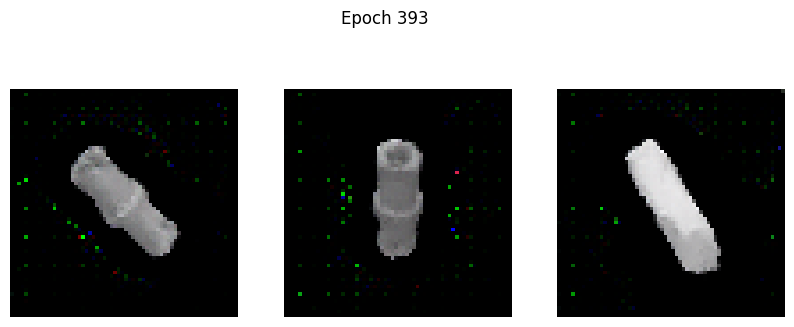

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0298 - g_loss: 5.3964
Epoch 394/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0047 - g_loss: 5.6873

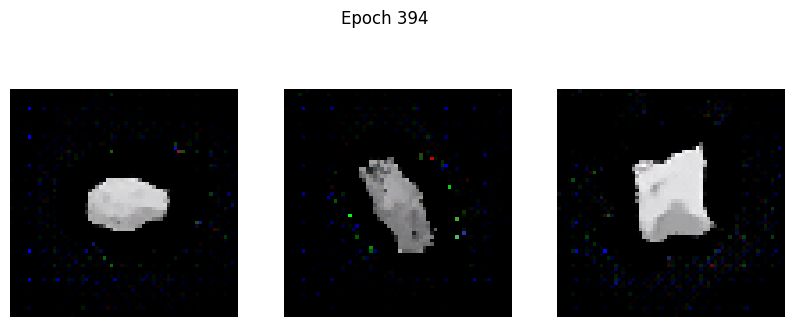

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0046 - g_loss: 5.6875
Epoch 395/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0177 - g_loss: 5.7085

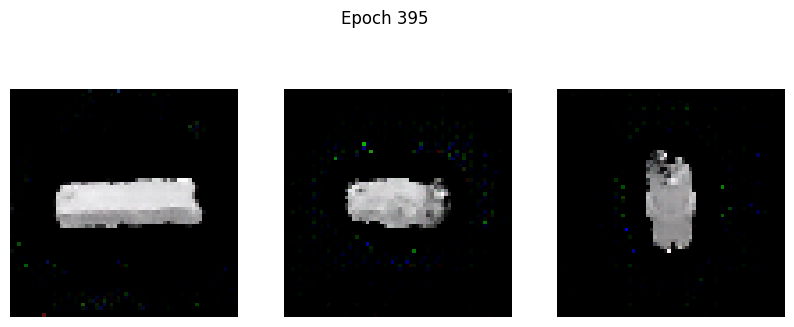

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0174 - g_loss: 5.7113
Epoch 396/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0313 - g_loss: 6.1360

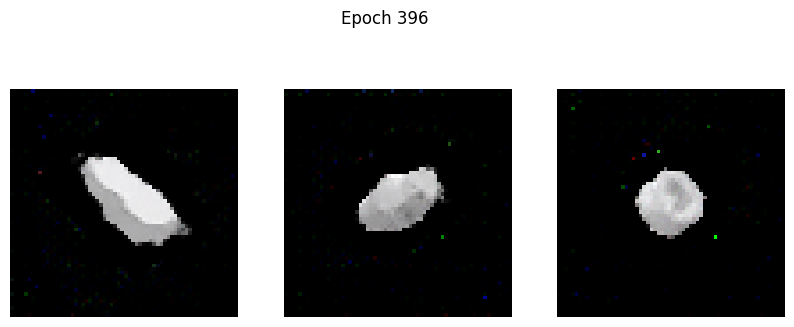

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0312 - g_loss: 6.1320
Epoch 397/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0110 - g_loss: 5.8344

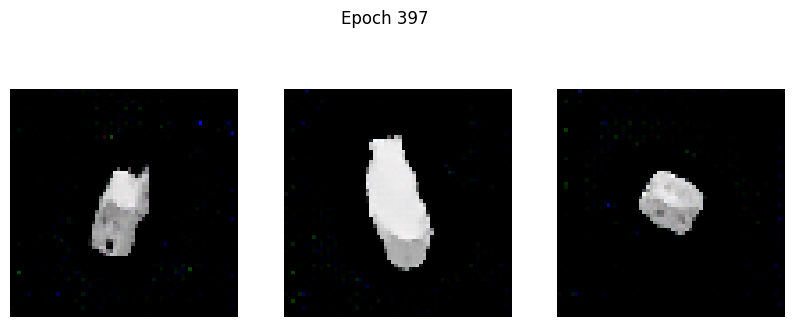

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0111 - g_loss: 5.8356
Epoch 398/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0262 - g_loss: 5.7784

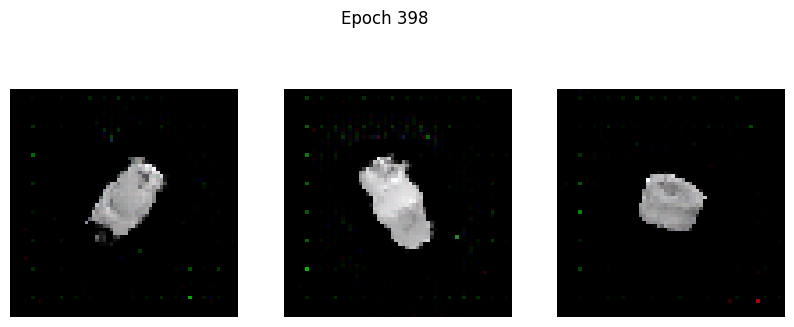

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0261 - g_loss: 5.7793
Epoch 399/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0052 - g_loss: 6.0508

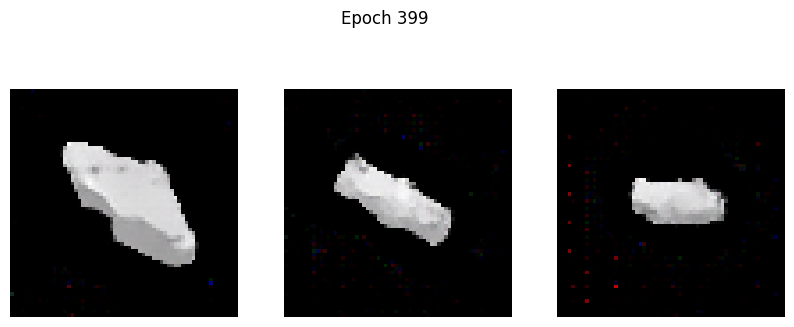

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0051 - g_loss: 6.0497
Epoch 400/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0197 - g_loss: 5.6140

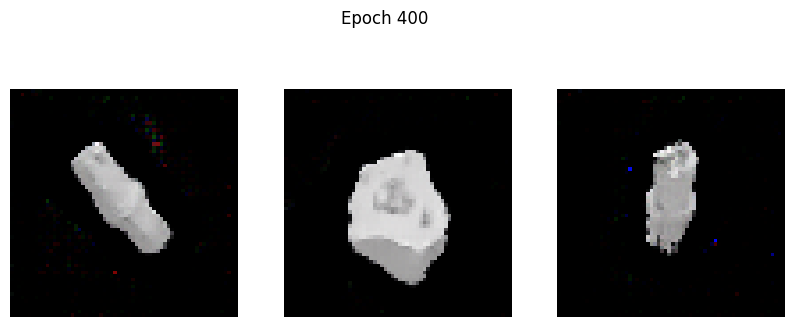

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0191 - g_loss: 5.6163
Epoch 401/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0322 - g_loss: 5.6997

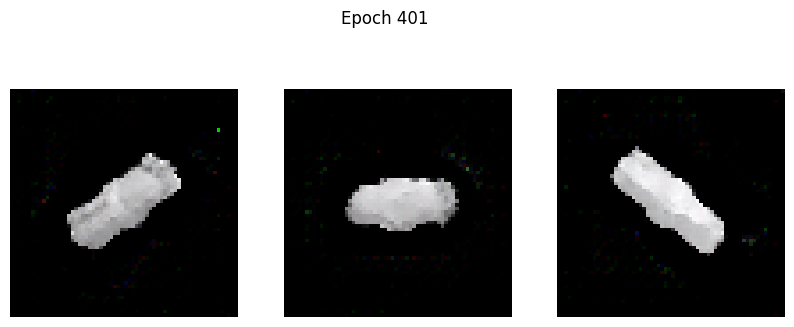

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0324 - g_loss: 5.6994
Epoch 402/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0660 - g_loss: 5.6259

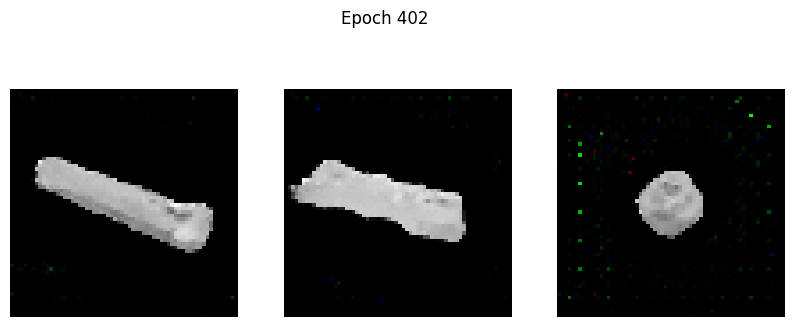

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0659 - g_loss: 5.6263
Epoch 403/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0012 - g_loss: 6.1743

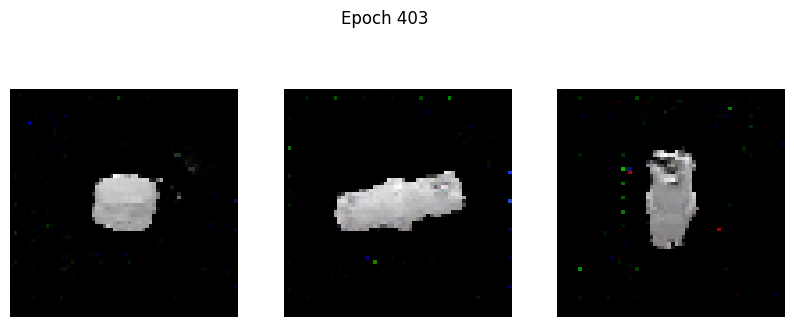

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0011 - g_loss: 6.1724
Epoch 404/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0133 - g_loss: 6.2211

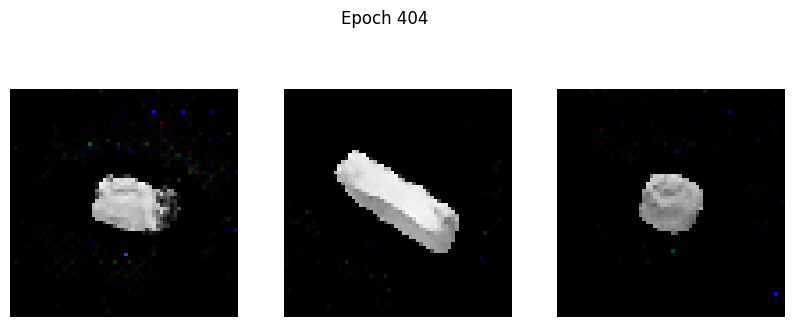

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0134 - g_loss: 6.2198
Epoch 405/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.1265 - g_loss: 6.7077

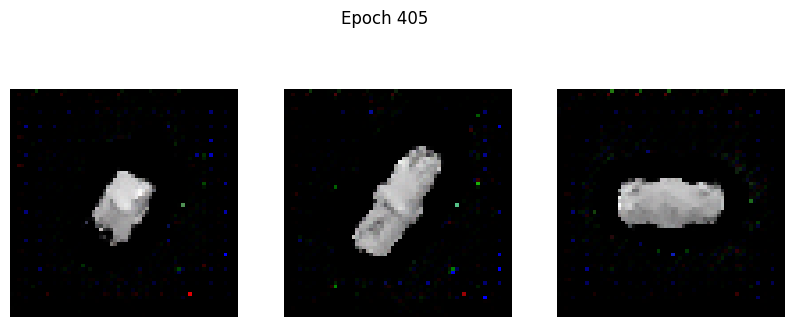

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.1259 - g_loss: 6.7025
Epoch 406/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0184 - g_loss: 6.2024

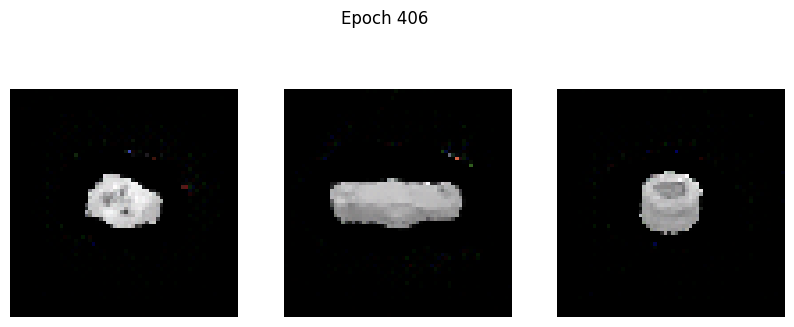

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0182 - g_loss: 6.1993
Epoch 407/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0275 - g_loss: 5.8988

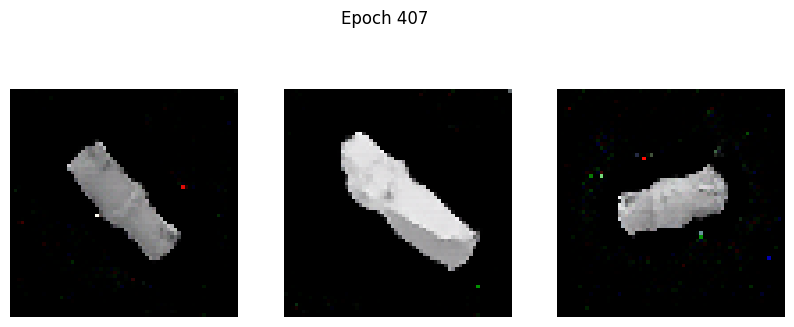

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0276 - g_loss: 5.8973
Epoch 408/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0549 - g_loss: 5.6582

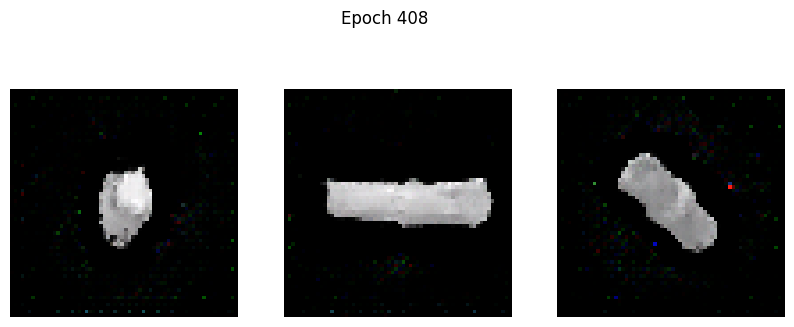

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0545 - g_loss: 5.6616
Epoch 409/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0636 - g_loss: 5.6414

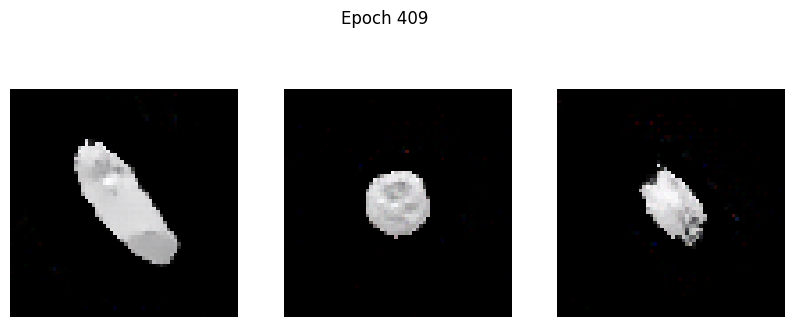

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0633 - g_loss: 5.6436
Epoch 410/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0576 - g_loss: 5.5596

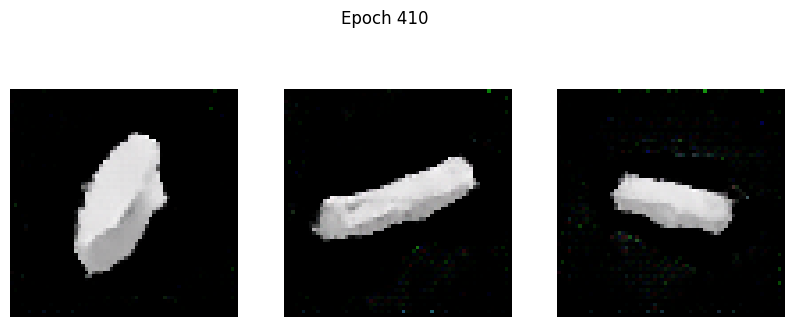

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0576 - g_loss: 5.5608
Epoch 411/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0767 - g_loss: 6.1249

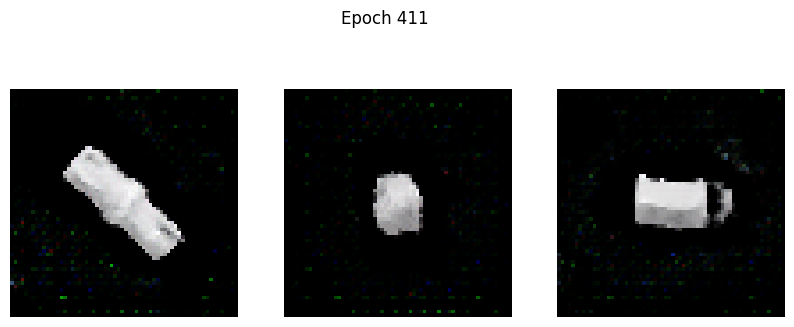

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0761 - g_loss: 6.1241
Epoch 412/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0070 - g_loss: 6.1703

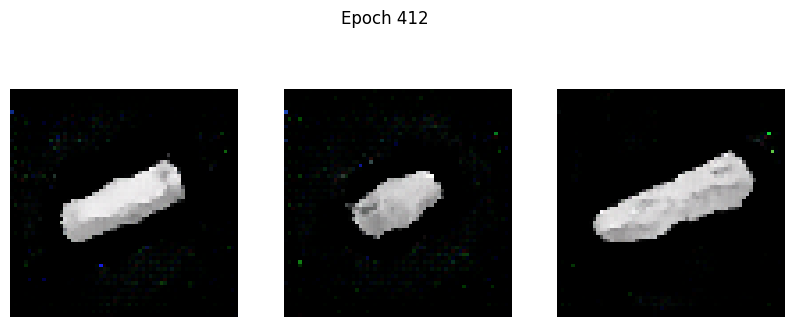

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0072 - g_loss: 6.1681
Epoch 413/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.1022 - g_loss: 5.7350

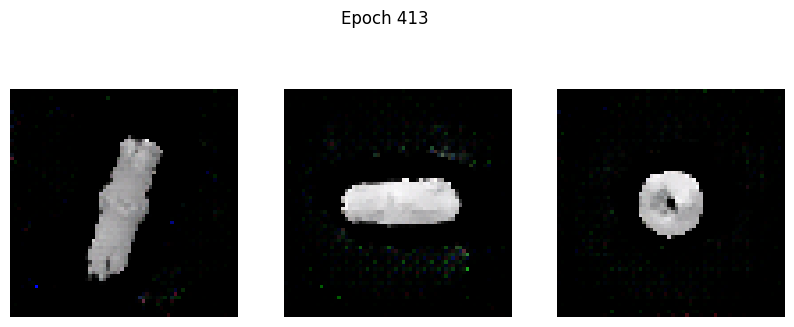

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.1020 - g_loss: 5.7362
Epoch 414/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.0390 - g_loss: 7.6926

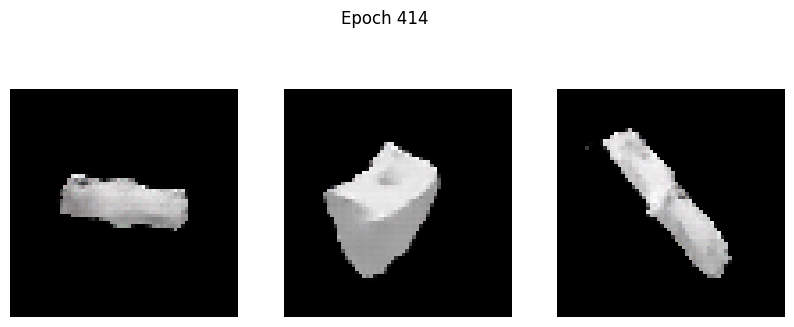

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0384 - g_loss: 7.6922
Epoch 415/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.1277 - g_loss: 6.4340

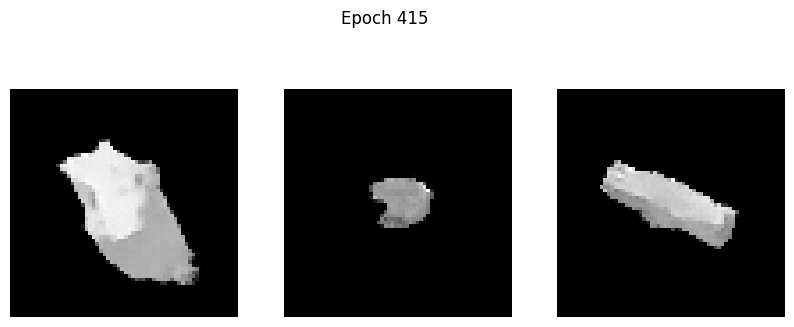

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -0.1276 - g_loss: 6.4337
Epoch 416/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0737 - g_loss: 6.7161

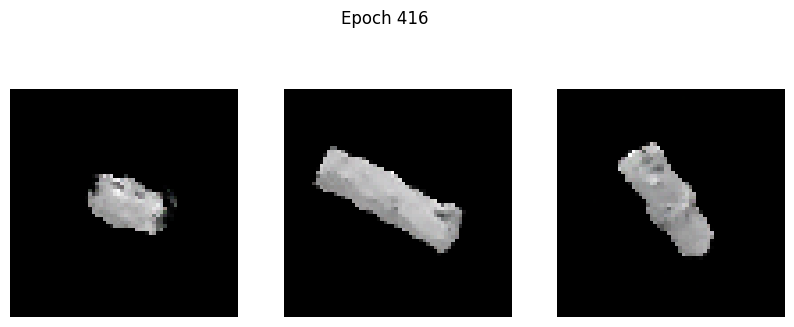

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0737 - g_loss: 6.7132
Epoch 417/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0677 - g_loss: 6.4667

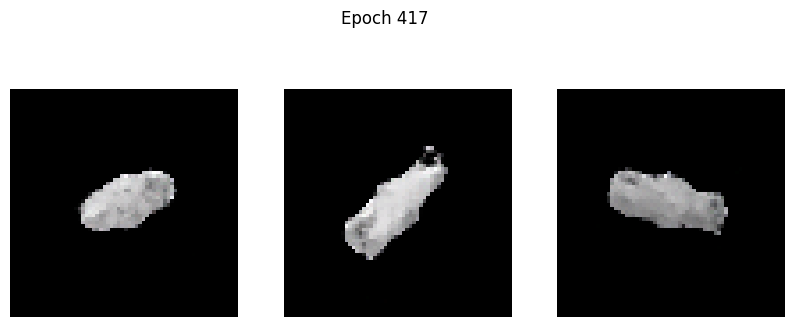

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -0.0678 - g_loss: 6.4657
Epoch 418/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0163 - g_loss: 6.3510

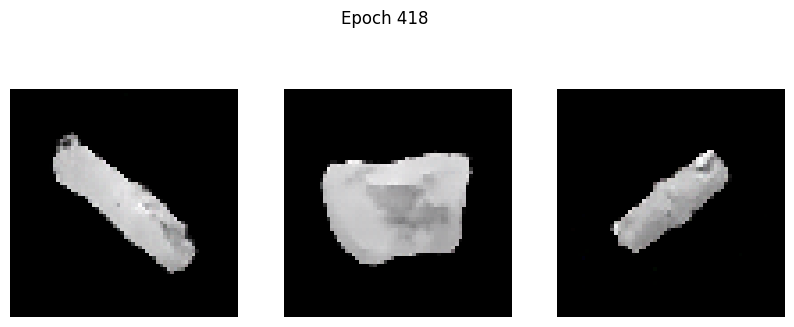

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0162 - g_loss: 6.3509
Epoch 419/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0313 - g_loss: 6.3050

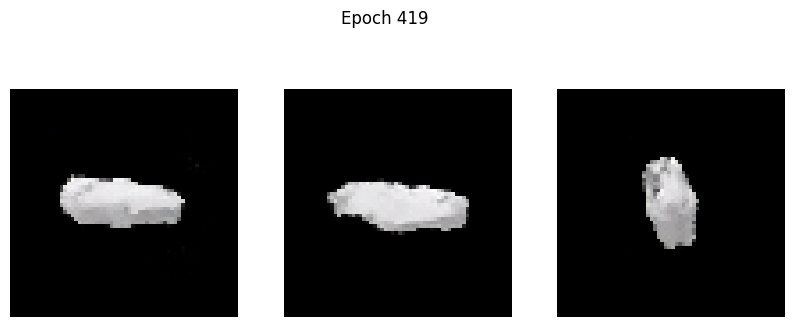

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0311 - g_loss: 6.3063
Epoch 420/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0524 - g_loss: 6.2665

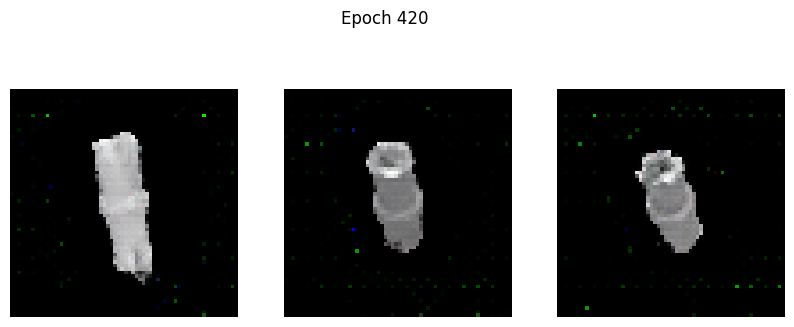

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0523 - g_loss: 6.2673
Epoch 421/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0291 - g_loss: 6.6793

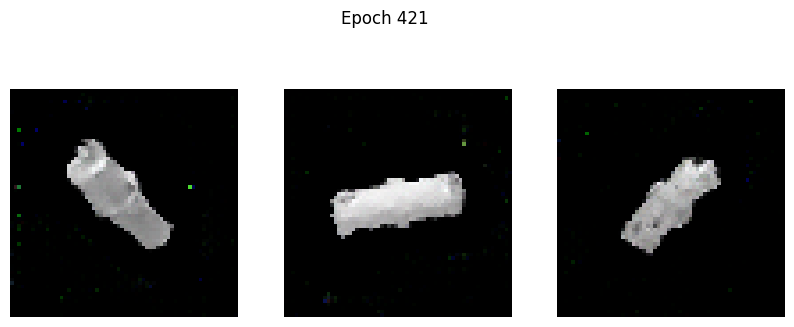

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0289 - g_loss: 6.6776
Epoch 422/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0579 - g_loss: 6.0315

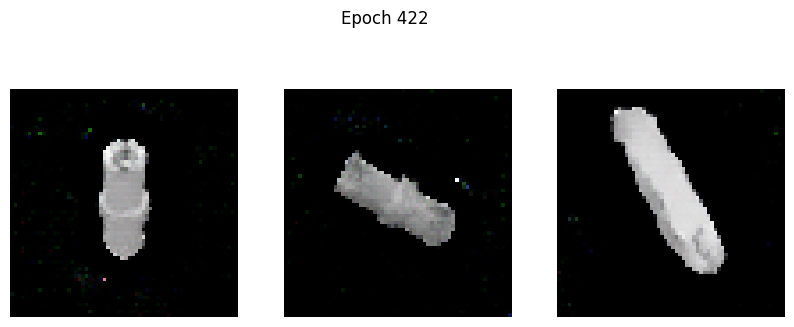

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0579 - g_loss: 6.0315
Epoch 423/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0778 - g_loss: 7.2683

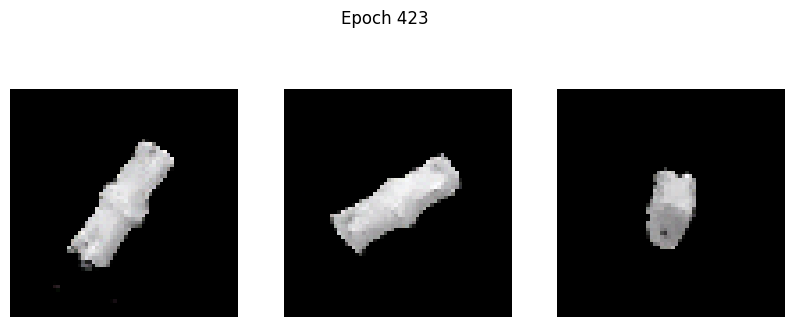

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: -0.0780 - g_loss: 7.2646
Epoch 424/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0557 - g_loss: 6.3549

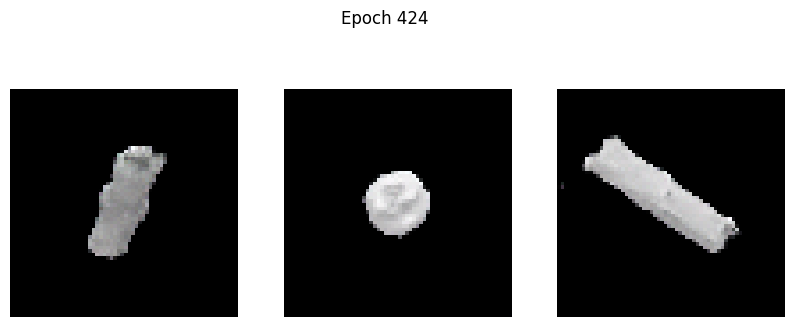

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0555 - g_loss: 6.3556
Epoch 425/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0399 - g_loss: 6.5194

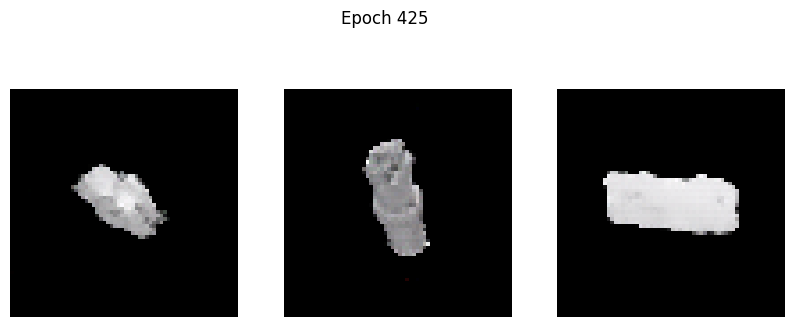

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0398 - g_loss: 6.5182
Epoch 426/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0286 - g_loss: 6.7726

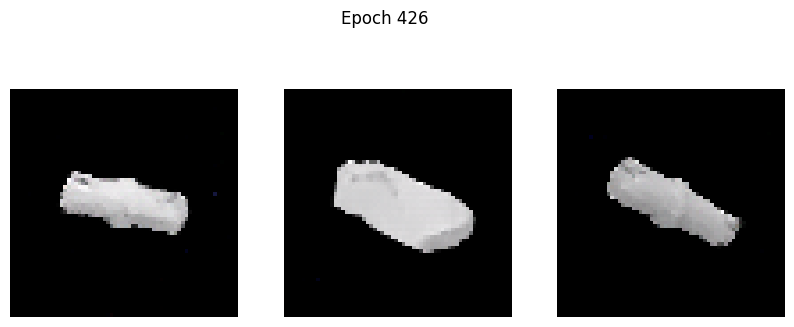

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0286 - g_loss: 6.7690
Epoch 427/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0152 - g_loss: 6.3991

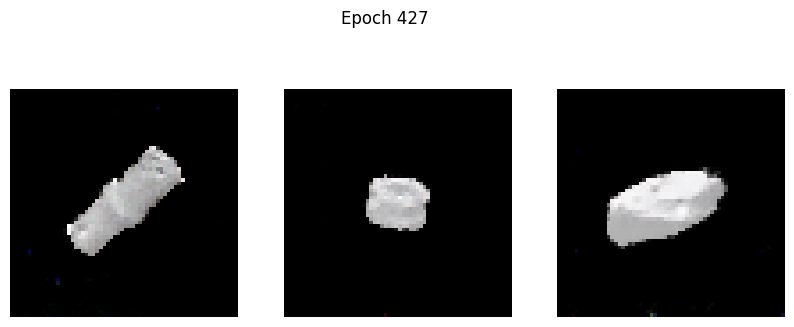

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0152 - g_loss: 6.3993
Epoch 428/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0771 - g_loss: 6.0771

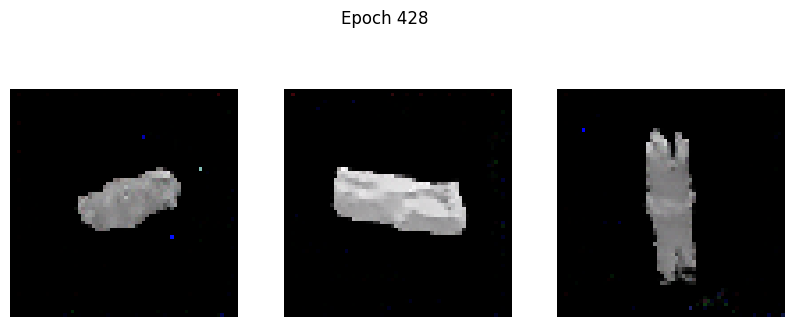

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0768 - g_loss: 6.0786
Epoch 429/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0817 - g_loss: 6.1948

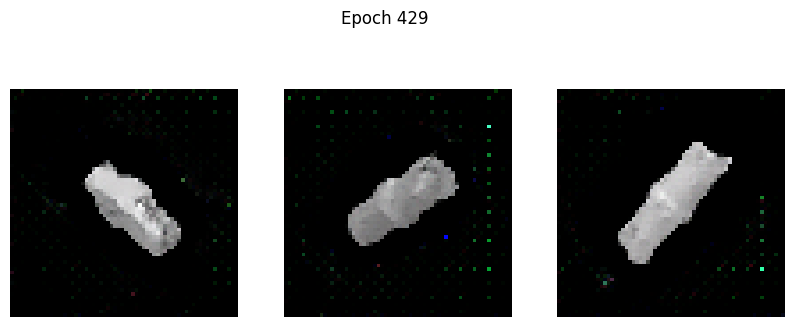

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - d_loss: -0.0817 - g_loss: 6.1946
Epoch 430/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0341 - g_loss: 6.8849

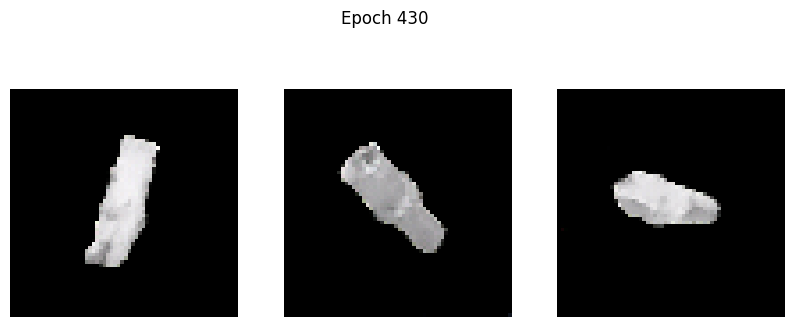

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0339 - g_loss: 6.8874
Epoch 431/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0649 - g_loss: 6.9396

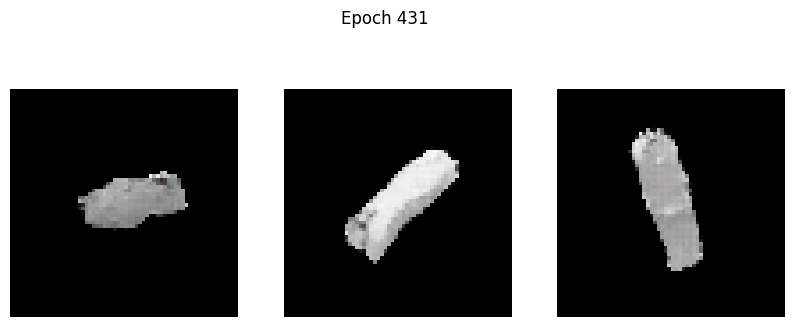

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0649 - g_loss: 6.9364
Epoch 432/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0912 - g_loss: 6.0345

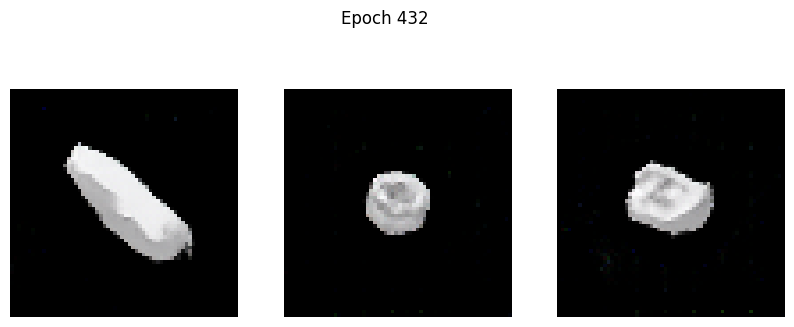

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0908 - g_loss: 6.0367
Epoch 433/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0042 - g_loss: 6.4589

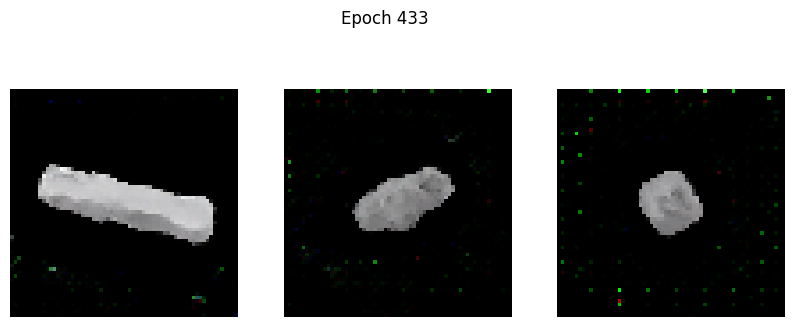

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0043 - g_loss: 6.4588
Epoch 434/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0263 - g_loss: 6.4520

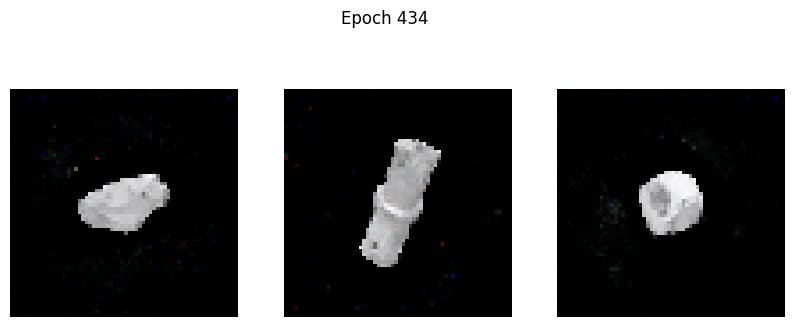

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0268 - g_loss: 6.4501
Epoch 435/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0650 - g_loss: 6.6045

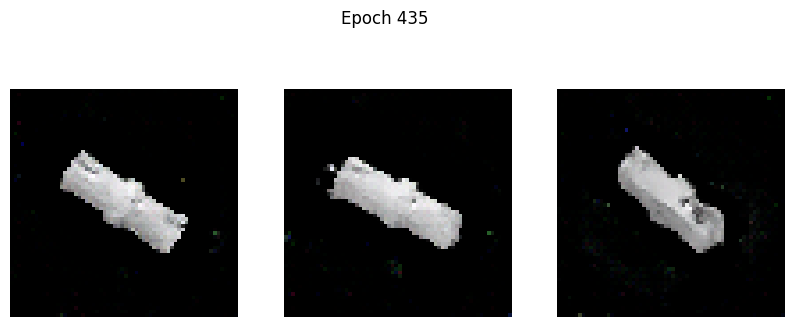

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0648 - g_loss: 6.6048
Epoch 436/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0175 - g_loss: 6.6267

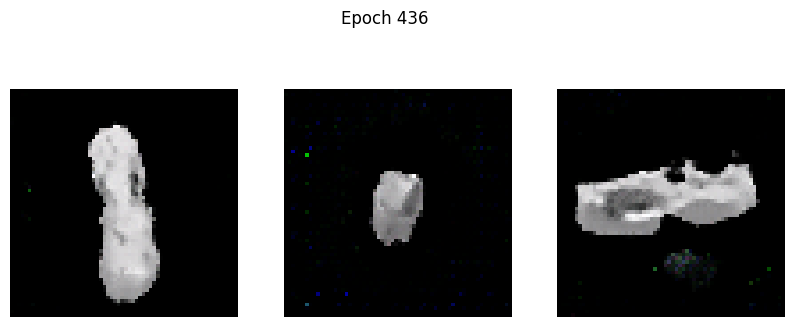

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0174 - g_loss: 6.6270
Epoch 437/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0496 - g_loss: 6.5275

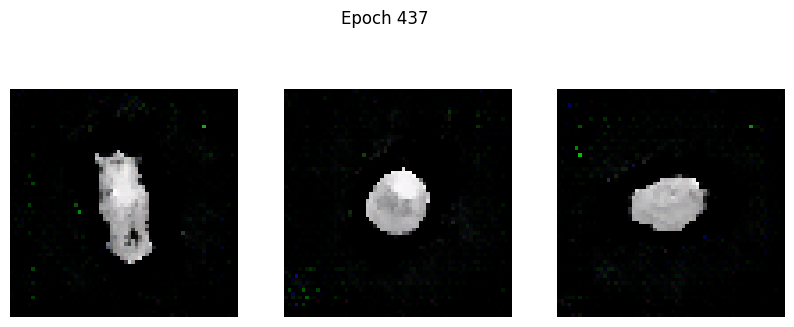

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0497 - g_loss: 6.5269
Epoch 438/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0861 - g_loss: 6.6280

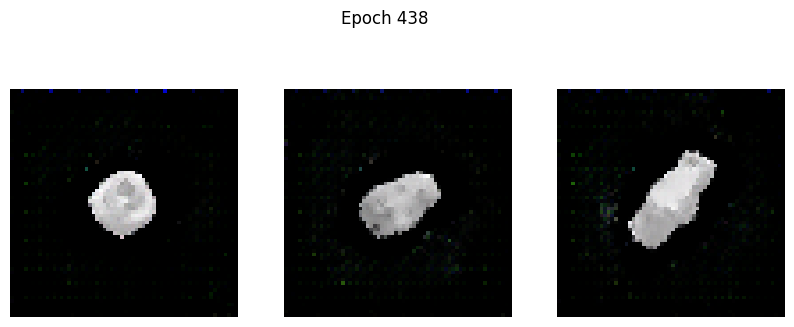

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0857 - g_loss: 6.6293
Epoch 439/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0060 - g_loss: 6.9031

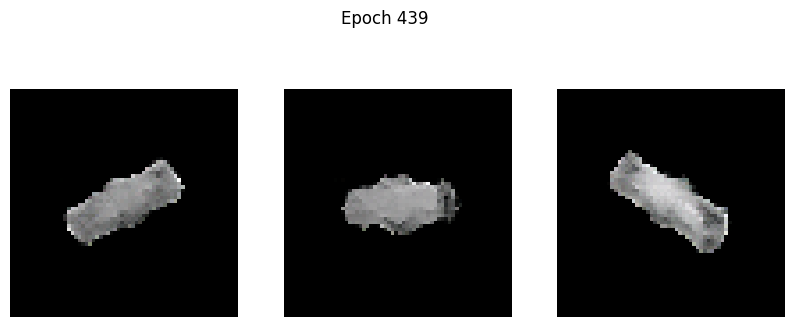

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0072 - g_loss: 6.9087
Epoch 440/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0282 - g_loss: 6.6192

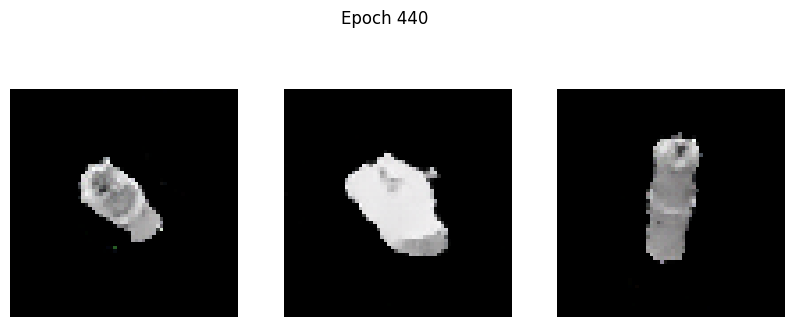

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0272 - g_loss: 6.6156
Epoch 441/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.1059 - g_loss: 6.1590

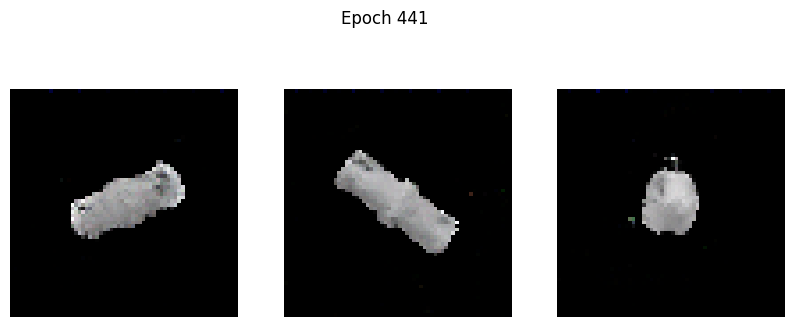

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.1060 - g_loss: 6.1584
Epoch 442/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0532 - g_loss: 6.3897

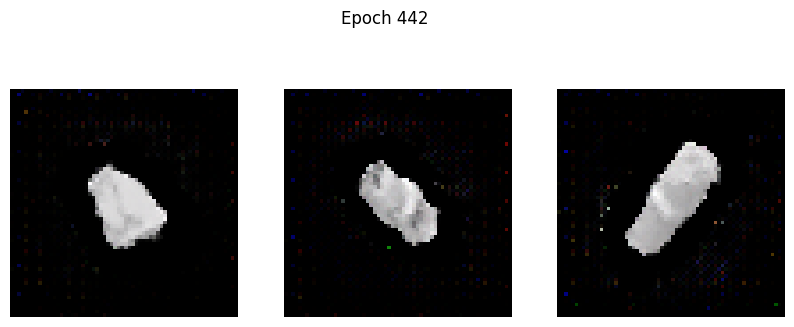

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0535 - g_loss: 6.3894
Epoch 443/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0436 - g_loss: 6.5874

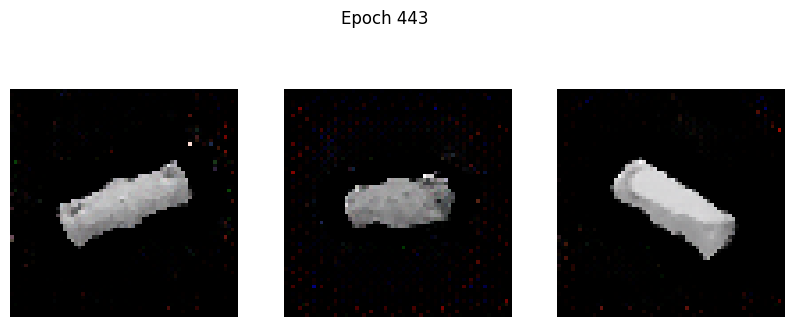

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - d_loss: -0.0436 - g_loss: 6.5866
Epoch 444/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0219 - g_loss: 6.8491

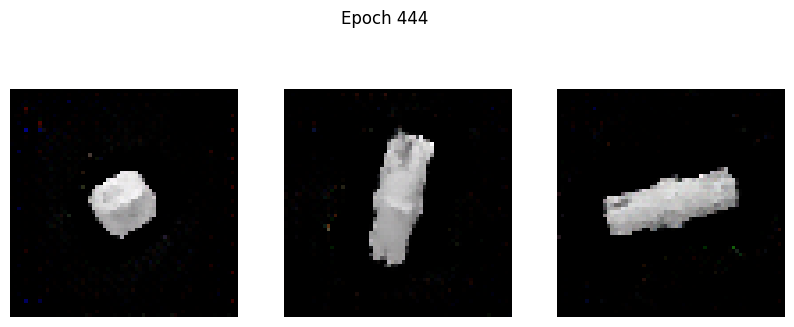

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0215 - g_loss: 6.8478
Epoch 445/600
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: -0.0873 - g_loss: 6.3848

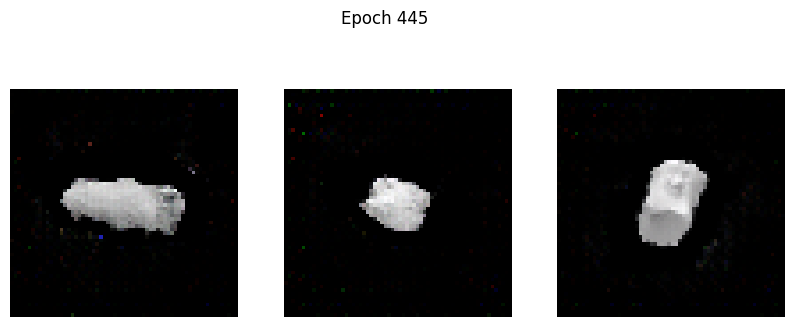

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0873 - g_loss: 6.3848
Epoch 446/600
 60/100 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - d_loss: -0.0394 - g_loss: 6.5549

In [ ]:
# Hyperparameters
EPOCHS = 600  # Tambahkan jumlah epoch untuk hasil lebih baik (misal: 100-200)
lr_generator = 0.0002
lr_discriminator = 0.0002

# Inisialisasi DCGAN
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Compile
dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=lr_discriminator, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=lr_generator, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Jalankan Training
print("Mulai Training...")
dcgan.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)